# Neuroblastoma Gene Signature Survival Analysis in Bulk RNA-seq data

## Getting Started

In [8]:
# Code cell to be removed in the final version
from IPython.display import Javascript

keep_alive = Javascript('''
    function KeepAlive(){
        console.log("Keeping notebook alive");
        setInterval(function(){
            var xhr = new XMLHttpRequest();
            xhr.open("GET", "/", true);
            xhr.send();
        }, 60000);  // 60 seconds interval
    }
    KeepAlive();
''')

display(keep_alive)

<IPython.core.display.Javascript object>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
import seaborn as sns
import statsmodels.api as sm

## Gene Expression Data

In [10]:
# Load gene expression data
gene_expression_file = "dataset/GSE49711_SEQC_NB_TAV_G_log2.final.txt"
gene_data = pd.read_csv(gene_expression_file, sep='\t')

In [11]:
# veiw data
gene_data.head(200)

Gene      Gene_set NCBI_gene_ID  \
0    2-oxoacid_dh  Gene_AceView            .   
1          A1BGAS  Gene_AceView       503538   
2            A1CF  Gene_AceView        29974   
3           A2BP1  Gene_AceView        54715   
4           A2LD1  Gene_AceView        87769   
..            ...           ...          ...   
195         ACSS2  Gene_AceView        55902   
196         ACSS3  Gene_AceView        79611   
197         ACTA1  Gene_AceView           58   
198         ACTA2  Gene_AceView           59   
199          ACTB  Gene_AceView           60   

                                  RefSeq_transcript_ID Chromosome Strand  \
0                                                    .         11      -   
1                                          NR_015380.1         19      +   
2    NM_001198818.1;NM_001198819.1;NM_001198820.1;N...         10      -   
3    NM_001142333.1;NM_001142334.1;NM_018723.3;NM_1...         16      +   
4                           NM_001195087.1;NM_033110.2         13      -   
..                                                 ...        ...    ...   
195  NM_001076552.2;NM_001242393.1;NM_018677.3;NM_1...         20      +   
196                                        NM_024560.2         12      +   
197                                        NM_001100.3          1      -   
198                         NM_001141945.1;NM_001613.2         10      -   
199                                        NM_001101.3          7      -   

         Start        End  SEQC_NB001  SEQC_NB002  ...  SEQC_NB489  \
0    111933358  111934981     16.1928     16.5853  ...     16.8862   
1     58859074   58866555     17.2744     15.3742  ...     16.8690   
2     52566307   52645436      8.7985      0.0000  ...      0.0000   
3      6068990    7763341     16.8905     18.6162  ...     14.9643   
4    101182342  101241782     13.8812     14.0487  ...     13.9839   
..         ...        ...         ...         ...  ...         ...   
195   33460250   33515775     18.1079     18.6159  ...     17.8572   
196   81331595   81650746     13.8122     13.4059  ...     12.2479   
197  229566986  229569840     13.2074     13.5339  ...     12.3445   
198   90694826   90751572     20.6453     19.3269  ...     19.7273   
199    5566772    5602421     24.7943     25.2958  ...     24.0672   

     SEQC_NB490  SEQC_NB491  SEQC_NB492  SEQC_NB493  SEQC_NB494  SEQC_NB495  \
0       17.7853     16.3760     16.9434     17.3701     17.8362     17.8373   
1       16.7470     15.6558     16.7318     16.6318     16.4946     16.8059   
2       10.8696      0.0000      0.0000      0.0000      0.0000      0.0000   
3       16.0162     15.5955     15.4929     17.4806     20.0256     19.4085   
4       16.1991     14.4934     15.0323     15.1812     14.7423     14.6655   
..          ...         ...         ...         ...         ...         ...   
195     17.7807     18.1700     18.0642     18.3047     17.9795     18.4696   
196     14.2277     12.9950     13.7934     14.3377     14.5500     14.9275   
197     11.3854     11.5715     11.2827     13.3193     11.5634     12.8683   
198     22.8411     18.3877     20.7247     20.1034     21.7489     20.5502   
199     25.2192     25.2333     24.2262     24.8157     25.4461     25.1602   

     SEQC_NB496  SEQC_NB497  SEQC_NB498  
0       17.4535     17.3726     16.8897  
1       16.2498     17.6346     16.8966  
2        0.0000     11.4219      0.0000  
3       19.4109     20.0640     19.3468  
4       13.7998     15.1968     14.5997  
..          ...         ...         ...  
195     18.2811     18.0744     18.3548  
196     14.9621     15.0501     15.2317  
197     12.0049     13.4456     12.4486  
198     22.1927     20.8221     21.0784  
199     25.1211     24.7802     25.0471  

[200 rows x 506 columns]

## Metadata

In [12]:
# Read and print the first few lines of the file
with open("dataset/GSE49711_series_matrix.txt", 'r') as file:
    for _ in range(66):
        print(file.readline())

!Series_title	"RNA-Seq reveals an unprecedented complexity of the neuroblastoma transcriptome and is suitable for clinical endpoint prediction [RNA-Seq]"

!Series_geo_accession	"GSE49711"

!Series_status	"Public on May 22 2015"

!Series_submission_date	"Aug 09 2013"

!Series_last_update_date	"Feb 08 2017"

!Series_pubmed_id	"25150839"

!Series_pubmed_id	"25150838"

!Series_pubmed_id	"25254650"

!Series_summary	"We generated gene expression profiles from 498 primary neuroblastomas using RNA-Seq and microarrays. We sought to systematically evaluate the capability of RNA deep-sequencing (RNA-Seq)-based classification for clinical endpoint prediction in comparison to microarray-based ones. The neuroblastoma cohort was randomly divided into training and validation sets, and 360 predictive models on six clinical endpoints were generated and evaluated. While prediction performances did not differ considerably between the two technical platforms, the RNA-Seq data processing pipelines, or featu

In [13]:
# Read metadata with more controlled handling
metadata_file = "dataset/GSE49711_series_matrix.txt"

# Adjusted this value based on where the data starts as showen above
skip_lines = 66

# Read the file, skipping initial lines and ensuring correct delimiter
metadata = pd.read_csv(metadata_file, sep='\t', skiprows=skip_lines)

# Display first few rows of metadata
metadata.head(50)

!Sample_title  \
0             !Sample_geo_accession   
1                    !Sample_status   
2           !Sample_submission_date   
3          !Sample_last_update_date   
4                      !Sample_type   
5             !Sample_channel_count   
6           !Sample_source_name_ch1   
7              !Sample_organism_ch1   
8       !Sample_characteristics_ch1   
9       !Sample_characteristics_ch1   
10      !Sample_characteristics_ch1   
11      !Sample_characteristics_ch1   
12      !Sample_characteristics_ch1   
13      !Sample_characteristics_ch1   
14      !Sample_characteristics_ch1   
15      !Sample_characteristics_ch1   
16      !Sample_characteristics_ch1   
17      !Sample_characteristics_ch1   
18   !Sample_treatment_protocol_ch1   
19      !Sample_growth_protocol_ch1   
20             !Sample_molecule_ch1   
21     !Sample_extract_protocol_ch1   
22     !Sample_extract_protocol_ch1   
23                !Sample_taxid_ch1   
24          !Sample_data_processing   
25          !Sample_data_processing   
26          !Sample_data_processing   
27          !Sample_data_processing   
28          !Sample_data_processing   
29              !Sample_platform_id   
30             !Sample_contact_name   
31            !Sample_contact_email   
32            !Sample_contact_phone   
33       !Sample_contact_laboratory   
34       !Sample_contact_department   
35        !Sample_contact_institute   
36          !Sample_contact_address   
37             !Sample_contact_city   
38  !Sample_contact_zip/postal_code   
39          !Sample_contact_country   
40           !Sample_data_row_count   
41         !Sample_instrument_model   
42        !Sample_library_selection   
43           !Sample_library_source   
44         !Sample_library_strategy   
45                 !Sample_relation   
46     !Sample_supplementary_file_1   
47       !series_matrix_table_begin   
48                           ID_REF   
49         !series_matrix_table_end   

                                           SEQC_NB001  \
0                                          GSM1205736   
1                               Public on May 22 2015   
2                                         Aug 09 2013   
3                                         May 22 2015   
4                                                 SRA   
5                                                   1   
6                                       neuroblastoma   
7                                        Homo sapiens   
8                               tissue: neuroblastoma   
9                                          dataset: 1   
10                                             Sex: M   
11                              age at diagnosis: 987   
12                                     mycn status: 0   
13                                       high risk: 1   
14                                      inss stage: 4   
15                                     class label: 1   
16                                     progression: 1   
17                              death from disease: 1   
18  All neuroblastoma samples of this set were obt...   
19                                                NaN   
20                                          total RNA   
21  30-60mg of snap-frozen neuroblastoma specimen ...   
22  Library construction was performed according t...   
23                                               9606   
24  Software used for basecalling are HCS1.4.8+RTA...   
25  Sequenced reads were masked for low-complexity...   
26  The Magic expression index for the gene is mea...   
27               Genome_build: human genome (NCBI 37)   
28  Supplementary_files_format_and_content: tab-de...   
29                                           GPL17553   
30                                        Leming,,Shi   
31                             lemingshi@fudan.edu.cn   
32                                    +86-18616827008   
33                        Center for Pharmacogenomics   
34                            School 

In [14]:
# Read and print the first few lines of the file
with open("dataset/GSE62564_series_matrix.txt", 'r') as file:
    for _ in range(50):
        print(file.readline())

!Series_title	"An Investigation of Biomarkers Derived from Legacy Microarray Data for Their Utility in the RNA-Seq Era"

!Series_geo_accession	"GSE62564"

!Series_status	"Public on Oct 22 2014"

!Series_submission_date	"Oct 21 2014"

!Series_last_update_date	"Mar 27 2019"

!Series_pubmed_id	"25150839"

!Series_pubmed_id	"25150838"

!Series_pubmed_id	"25254650"

!Series_pubmed_id	"25633159"

!Series_summary	"Gene expression microarray has been the primary biomarker platform ubiquitously applied in biomedical research, resulting in enormous data, predictive models and biomarkers accrued. Recently, RNA-seq has looked likely to replace microarrays, but there will be a period where both technologies coexist. This raises two important questions: can microarray-based models and biomarkers be directly applied to RNA-Seq data? Can future RNA-Seq-based predictive models and biomarkers be applied to microarray data to leverage past investment? We systematically evaluated the transferability of pr

In [15]:
# Read metadata with more controlled handling
metadata_file = "dataset/GSE62564_series_matrix.txt"

# Adjusted this value based on where the data starts as showen above
skip_lines = 50

# Read the file, skipping initial lines and ensuring correct delimiter
metadata = pd.read_csv(metadata_file, sep='\t', skiprows=skip_lines)

# Display first few rows of metadata
metadata.head(100)

!Sample_title  \
0             !Sample_geo_accession   
1                    !Sample_status   
2           !Sample_submission_date   
3          !Sample_last_update_date   
4                      !Sample_type   
5             !Sample_channel_count   
6           !Sample_source_name_ch1   
7              !Sample_organism_ch1   
8       !Sample_characteristics_ch1   
9       !Sample_characteristics_ch1   
10      !Sample_characteristics_ch1   
11      !Sample_characteristics_ch1   
12      !Sample_characteristics_ch1   
13      !Sample_characteristics_ch1   
14      !Sample_characteristics_ch1   
15      !Sample_characteristics_ch1   
16      !Sample_characteristics_ch1   
17      !Sample_characteristics_ch1   
18      !Sample_characteristics_ch1   
19      !Sample_characteristics_ch1   
20      !Sample_characteristics_ch1   
21      !Sample_characteristics_ch1   
22      !Sample_characteristics_ch1   
23             !Sample_molecule_ch1   
24     !Sample_extract_protocol_ch1   
25                !Sample_taxid_ch1   
26          !Sample_data_processing   
27          !Sample_data_processing   
28          !Sample_data_processing   
29          !Sample_data_processing   
30              !Sample_platform_id   
31             !Sample_contact_name   
32            !Sample_contact_email   
33            !Sample_contact_phone   
34       !Sample_contact_laboratory   
35       !Sample_contact_department   
36        !Sample_contact_institute   
37          !Sample_contact_address   
38             !Sample_contact_city   
39  !Sample_contact_zip/postal_code   
40          !Sample_contact_country   
41           !Sample_data_row_count   
42         !Sample_instrument_model   
43        !Sample_library_selection   
44           !Sample_library_source   
45         !Sample_library_strategy   
46                 !Sample_relation   
47     !Sample_supplementary_file_1   
48       !series_matrix_table_begin   
49                           ID_REF   
50         !series_matrix_table_end   

                                       SEQC_NB001 [2]  \
0                                          GSM1528894   
1                               Public on Oct 22 2014   
2                                         Oct 21 2014   
3                                         Feb 27 2017   
4                                                 SRA   
5                                                   1   
6                                       neuroblastoma   
7                                        Homo sapiens   
8                       training/validation: Training   
9                                              Sex: M   
10                                           age: 987   
11                                       efs day: 593   
12                                         efs bin: 1   
13                                       os day: 1362   
14                                          os bin: 1   
15                                      high risk: HR   
16                                       a_efs_all: 1   
17                                        b_os_all: 1   
18                                       c_sex_all: 0   
19                                       d_fav_all: 1   
20                                        e_efs_hr: 1   
21                                         f_os_hr: 1   
22                              tissue: neuroblastoma   
23                                          total RNA   
24  Illumina libraries were prepared using standar...   
25                                               9606   
26  Illumina Casava1.8 software used for Illumina ...   
27  Reads were aligned with Novoalign and quantifi...   
28                                 Genome_build: hg19   
29  Supplementary_files_format_and_content: tab-de...   
30                                           GPL11154   
31                                        Leming,,Shi   
32                             lemingshi@fudan.edu.cn   
33                                    +86-18616827008  

In [16]:
# Remove " [2]" from sample titles
metadata.columns = metadata.columns.str.replace(' \[2\]', '', regex=True)


In [17]:
# Display the first few rows to verify
metadata.head(100)

!Sample_title  \
0             !Sample_geo_accession   
1                    !Sample_status   
2           !Sample_submission_date   
3          !Sample_last_update_date   
4                      !Sample_type   
5             !Sample_channel_count   
6           !Sample_source_name_ch1   
7              !Sample_organism_ch1   
8       !Sample_characteristics_ch1   
9       !Sample_characteristics_ch1   
10      !Sample_characteristics_ch1   
11      !Sample_characteristics_ch1   
12      !Sample_characteristics_ch1   
13      !Sample_characteristics_ch1   
14      !Sample_characteristics_ch1   
15      !Sample_characteristics_ch1   
16      !Sample_characteristics_ch1   
17      !Sample_characteristics_ch1   
18      !Sample_characteristics_ch1   
19      !Sample_characteristics_ch1   
20      !Sample_characteristics_ch1   
21      !Sample_characteristics_ch1   
22      !Sample_characteristics_ch1   
23             !Sample_molecule_ch1   
24     !Sample_extract_protocol_ch1   
25                !Sample_taxid_ch1   
26          !Sample_data_processing   
27          !Sample_data_processing   
28          !Sample_data_processing   
29          !Sample_data_processing   
30              !Sample_platform_id   
31             !Sample_contact_name   
32            !Sample_contact_email   
33            !Sample_contact_phone   
34       !Sample_contact_laboratory   
35       !Sample_contact_department   
36        !Sample_contact_institute   
37          !Sample_contact_address   
38             !Sample_contact_city   
39  !Sample_contact_zip/postal_code   
40          !Sample_contact_country   
41           !Sample_data_row_count   
42         !Sample_instrument_model   
43        !Sample_library_selection   
44           !Sample_library_source   
45         !Sample_library_strategy   
46                 !Sample_relation   
47     !Sample_supplementary_file_1   
48       !series_matrix_table_begin   
49                           ID_REF   
50         !series_matrix_table_end   

                                           SEQC_NB001  \
0                                          GSM1528894   
1                               Public on Oct 22 2014   
2                                         Oct 21 2014   
3                                         Feb 27 2017   
4                                                 SRA   
5                                                   1   
6                                       neuroblastoma   
7                                        Homo sapiens   
8                       training/validation: Training   
9                                              Sex: M   
10                                           age: 987   
11                                       efs day: 593   
12                                         efs bin: 1   
13                                       os day: 1362   
14                                          os bin: 1   
15                                      high risk: HR   
16                                       a_efs_all: 1   
17                                        b_os_all: 1   
18                                       c_sex_all: 0   
19                                       d_fav_all: 1   
20                                        e_efs_hr: 1   
21                                         f_os_hr: 1   
22                              tissue: neuroblastoma   
23                                          total RNA   
24  Illumina libraries were prepared using standar...   
25                                               9606   
26  Illumina Casava1.8 software used for Illumina ...   
27  Reads were aligned with Novoalign and quantifi...   
28                                 Genome_build: hg19   
29  Supplementary_files_format_and_content: tab-de...   
30                                           GPL11154   
31                                        Leming,,Shi   
32                             lemingshi@fudan.edu.cn   
33                                    +86-18616827008  

## Gene Signature Scores

### Prepare Data

In [18]:
# Extract 'os day' and 'os bin' rows and transpose the DataFrame for easier manipulation
os_day_row = metadata.iloc[13, 1:].str.split(': ').str[1].astype(int)  # Splitting and converting to integer
os_bin_row = metadata.iloc[14, 1:].str.split(': ').str[1].astype(int)

# Creating new DataFrame
data = pd.DataFrame({
    'Sample ID': metadata.columns[1:],  # Extracting Sample IDs from the column headers, skipping the first entry
    'os days': os_day_row.values,
    'os bin': os_bin_row.values
})

In [19]:
data

Sample ID  os days  os bin
0    SEQC_NB001     1362       1
1    SEQC_NB002     2836       1
2    SEQC_NB003     1191       1
3    SEQC_NB004     2046       0
4    SEQC_NB005      220       1
..          ...      ...     ...
493  SEQC_NB494     4828       0
494  SEQC_NB495     2467       0
495  SEQC_NB496     5780       0
496  SEQC_NB497     4883       0
497  SEQC_NB498     2772       0

[498 rows x 3 columns]

### TGF Beta

In [20]:
# Read the gene list from the file
with open("dataset/HALLMARK_TGF_BETA_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
tgfb_gene_list = gene_list[2:]

# Print the gene list to verify
print(tgfb_gene_list)

['ACVR1', 'APC', 'ARID4B', 'BCAR3', 'BMP2', 'BMPR1A', 'BMPR2', 'CDH1', 'CDK9', 'CDKN1C', 'CTNNB1', 'ENG', 'FKBP1A', 'FNTA', 'FURIN', 'HDAC1', 'HIPK2', 'ID1', 'ID2', 'ID3', 'IFNGR2', 'JUNB', 'KLF10', 'LEFTY2', 'LTBP2', 'MAP3K7', 'NCOR2', 'NOG', 'PMEPA1', 'PPM1A', 'PPP1CA', 'PPP1R15A', 'RAB31', 'RHOA', 'SERPINE1', 'SKI', 'SKIL', 'SLC20A1', 'SMAD1', 'SMAD3', 'SMAD6', 'SMAD7', 'SMURF1', 'SMURF2', 'SPTBN1', 'TGFB1', 'TGFBR1', 'TGIF1', 'THBS1', 'TJP1', 'TRIM33', 'UBE2D3', 'WWTR1', 'XIAP']


In [21]:
# List of Tgfb pathway genes
tgfb_genes = tgfb_gene_list

# Calculate Tgfb signature scores for each sample
tgfb_scores = gene_data[gene_data['Gene'].isin(tgfb_genes)].iloc[:, 8:].mean(axis=0)
tgfb_scores.name = 'tgfb_score'

# Combine tgfb scores with metadata
data['tgfb_score'] = data['Sample ID'].map(tgfb_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['tgfb_score'], inplace=True)

In [22]:
tgfb_scores.head()

SEQC_NB001    18.269337
SEQC_NB002    17.887488
SEQC_NB003    17.871847
SEQC_NB004    18.281798
SEQC_NB005    18.154788
Name: tgfb_score, dtype: float64

### IL2 STAT5

In [23]:
# Read the gene list from the file
with open("dataset/HALLMARK_IL2_STAT5_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
il2_stat5_gene_list = gene_list[2:]

# Print the gene list to verify
print(il2_stat5_gene_list)

['ABCB1', 'ADAM19', 'AGER', 'AHCY', 'AHNAK', 'AHR', 'ALCAM', 'AMACR', 'ANXA4', 'APLP1', 'ARL4A', 'BATF', 'BATF3', 'BCL2', 'BCL2L1', 'BHLHE40', 'BMP2', 'BMPR2', 'CA2', 'CAPG', 'CAPN3', 'CASP3', 'CCND2', 'CCND3', 'CCNE1', 'CCR4', 'CD44', 'CD48', 'CD79B', 'CD81', 'CD83', 'CD86', 'CDC42SE2', 'CDC6', 'CDCP1', 'CDKN1C', 'CISH', 'CKAP4', 'COCH', 'COL6A1', 'CSF1', 'CSF2', 'CST7', 'CTLA4', 'CTSZ', 'CXCL10', 'CYFIP1', 'DCPS', 'DENND5A', 'DHRS3', 'DRC1', 'ECM1', 'EEF1AKMT1', 'EMP1', 'ENO3', 'ENPP1', 'EOMES', 'ETFBKMT', 'ETV4', 'F2RL2', 'FAH', 'FGL2', 'FLT3LG', 'FURIN', 'GABARAPL1', 'GADD45B', 'GALM', 'GATA1', 'GBP4', 'GLIPR2', 'GPR65', 'GPR83', 'GPX4', 'GSTO1', 'GUCY1B1', 'HIPK2', 'HK2', 'HOPX', 'HUWE1', 'HYCC2', 'ICOS', 'IFITM3', 'IFNGR1', 'IGF1R', 'IGF2R', 'IKZF2', 'IKZF4', 'IL10', 'IL10RA', 'IL13', 'IL18R1', 'IL1R2', 'IL1RL1', 'IL2RA', 'IL2RB', 'IL3RA', 'IL4R', 'IRF4', 'IRF6', 'IRF8', 'ITGA6', 'ITGAE', 'ITGAV', 'ITIH5', 'KLF6', 'LCLAT1', 'LIF', 'LRIG1', 'LRRC8C', 'LTB', 'MAFF', 'MAP3K8', 'MAP6

In [24]:
# List of il2 stat5 signaling pathway genes
il2_stat5_genes = il2_stat5_gene_list

# Calculate Tgfb signature scores for each sample
il2_stat5_scores = gene_data[gene_data['Gene'].isin(il2_stat5_genes)].iloc[:, 8:].mean(axis=0)
il2_stat5_scores.name = 'il2_stat5_score'

# Combine il2 scores with metadata
data['il2_stat5_score'] = data['Sample ID'].map(il2_stat5_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['il2_stat5_score'], inplace=True)

In [25]:
il2_stat5_scores.head()

SEQC_NB001    17.244859
SEQC_NB002    16.696371
SEQC_NB003    16.120460
SEQC_NB004    17.053701
SEQC_NB005    16.878057
Name: il2_stat5_score, dtype: float64

### IL6 JAK STAT3

In [26]:
# Read the gene list from the file
with open("dataset/HALLMARK_IL6_JAK_STAT3_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
il6_jak_stat3_gene_list = gene_list[2:]

# Print the gene list to verify
print(il6_jak_stat3_gene_list)

['A2M', 'ACVR1B', 'ACVRL1', 'BAK1', 'CBL', 'CCL7', 'CCR1', 'CD14', 'CD36', 'CD38', 'CD44', 'CD9', 'CNTFR', 'CRLF2', 'CSF1', 'CSF2', 'CSF2RA', 'CSF2RB', 'CSF3R', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL13', 'CXCL3', 'CXCL9', 'DNTT', 'EBI3', 'FAS', 'GRB2', 'HAX1', 'HMOX1', 'IFNAR1', 'IFNGR1', 'IFNGR2', 'IL10RB', 'IL12RB1', 'IL13RA1', 'IL15RA', 'IL17RA', 'IL17RB', 'IL18R1', 'IL1B', 'IL1R1', 'IL1R2', 'IL2RA', 'IL2RG', 'IL3RA', 'IL4R', 'IL6', 'IL6ST', 'IL7', 'IL9R', 'INHBE', 'IRF1', 'IRF9', 'ITGA4', 'ITGB3', 'JUN', 'LEPR', 'LTB', 'LTBR', 'MAP3K8', 'MYD88', 'OSMR', 'PDGFC', 'PF4', 'PIK3R5', 'PIM1', 'PLA2G2A', 'PTPN1', 'PTPN11', 'PTPN2', 'REG1A', 'SOCS1', 'SOCS3', 'STAM2', 'STAT1', 'STAT2', 'STAT3', 'TGFB1', 'TLR2', 'TNF', 'TNFRSF12A', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF21', 'TYK2']


In [27]:
# List of il6 jak stat3 signaling pathway genes
il6_jak_stat3_genes = il6_jak_stat3_gene_list

# Calculate Tgfb signature scores for each sample
il6_jak_stat3_scores = gene_data[gene_data['Gene'].isin(il6_jak_stat3_genes)].iloc[:, 8:].mean(axis=0)
il6_jak_stat3_scores.name = 'il6_jak_stat3_score'

# Combine tgfb scores with metadata
data['il6_jak_stat3_score'] = data['Sample ID'].map(il6_jak_stat3_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['il6_jak_stat3_score'], inplace=True)

In [28]:
il6_jak_stat3_scores.head()

SEQC_NB001    16.482722
SEQC_NB002    15.697078
SEQC_NB003    14.869950
SEQC_NB004    15.792001
SEQC_NB005    15.197942
Name: il6_jak_stat3_score, dtype: float64

### Inflammatory Response

In [29]:
# Read the gene list from the file
with open("dataset/HALLMARK_INFLAMMATORY_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
inflammatory_gene_list = gene_list[2:]

# Print the gene list to verify
print(inflammatory_gene_list)

['ABCA1', 'ABI1', 'ACVR1B', 'ACVR2A', 'ADGRE1', 'ADM', 'ADORA2B', 'ADRM1', 'AHR', 'APLNR', 'AQP9', 'ATP2A2', 'ATP2B1', 'ATP2C1', 'AXL', 'BDKRB1', 'BEST1', 'BST2', 'BTG2', 'C3AR1', 'C5AR1', 'CALCRL', 'CCL17', 'CCL2', 'CCL20', 'CCL22', 'CCL24', 'CCL5', 'CCL7', 'CCR7', 'CCRL2', 'CD14', 'CD40', 'CD48', 'CD55', 'CD69', 'CD70', 'CD82', 'CDKN1A', 'CHST2', 'CLEC5A', 'CMKLR1', 'CSF1', 'CSF3', 'CSF3R', 'CX3CL1', 'CXCL10', 'CXCL11', 'CXCL6', 'CXCL8', 'CXCL9', 'CXCR6', 'CYBB', 'DCBLD2', 'EBI3', 'EDN1', 'EIF2AK2', 'EMP3', 'EREG', 'F3', 'FFAR2', 'FPR1', 'FZD5', 'GABBR1', 'GCH1', 'GNA15', 'GNAI3', 'GP1BA', 'GPC3', 'GPR132', 'GPR183', 'HAS2', 'HBEGF', 'HIF1A', 'HPN', 'HRH1', 'ICAM1', 'ICAM4', 'ICOSLG', 'IFITM1', 'IFNAR1', 'IFNGR2', 'IL10', 'IL10RA', 'IL12B', 'IL15', 'IL15RA', 'IL18', 'IL18R1', 'IL18RAP', 'IL1A', 'IL1B', 'IL1R1', 'IL2RB', 'IL4R', 'IL6', 'IL7R', 'INHBA', 'IRAK2', 'IRF1', 'IRF7', 'ITGA5', 'ITGB3', 'ITGB8', 'KCNA3', 'KCNJ2', 'KCNMB2', 'KIF1B', 'KLF6', 'LAMP3', 'LCK', 'LCP2', 'LDLR', 'LIF'

In [30]:
# List of inflamatory response pathway genes
inflammatory_genes = inflammatory_gene_list

# Calculate Tgfb signature scores for each sample
inflammatory_scores = gene_data[gene_data['Gene'].isin(inflammatory_genes)].iloc[:, 8:].mean(axis=0)
inflammatory_scores.name = 'inflammatory_score'

# Combine tgfb scores with metadata
data['inflammatory_score'] = data['Sample ID'].map(inflammatory_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['inflammatory_score'], inplace=True)

In [31]:
inflammatory_scores.head()

SEQC_NB001    15.634172
SEQC_NB002    15.270535
SEQC_NB003    14.382875
SEQC_NB004    15.186789
SEQC_NB005    15.045142
Name: inflammatory_score, dtype: float64

### Interferon Alpha

In [32]:
# Read the gene list from the file
with open("dataset/HALLMARK_INTERFERON_ALPHA_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
ifna_gene_list = gene_list[2:]

# Print the gene list to verify
print(ifna_gene_list)

['ADAR', 'B2M', 'BATF2', 'BST2', 'C1S', 'CASP1', 'CASP8', 'CCRL2', 'CD47', 'CD74', 'CMPK2', 'CMTR1', 'CNP', 'CSF1', 'CXCL10', 'CXCL11', 'DDX60', 'DHX58', 'EIF2AK2', 'ELF1', 'EPSTI1', 'GBP2', 'GBP4', 'GMPR', 'HELZ2', 'HERC6', 'HLA-C', 'IFI27', 'IFI30', 'IFI35', 'IFI44', 'IFI44L', 'IFIH1', 'IFIT2', 'IFIT3', 'IFITM1', 'IFITM2', 'IFITM3', 'IL15', 'IL4R', 'IL7', 'IRF1', 'IRF2', 'IRF7', 'IRF9', 'ISG15', 'ISG20', 'LAMP3', 'LAP3', 'LGALS3BP', 'LPAR6', 'LY6E', 'MOV10', 'MVB12A', 'MX1', 'NCOA7', 'NMI', 'NUB1', 'OAS1', 'OASL', 'OGFR', 'PARP12', 'PARP14', 'PARP9', 'PLSCR1', 'PNPT1', 'PROCR', 'PSMA3', 'PSMB8', 'PSMB9', 'PSME1', 'PSME2', 'RIPK2', 'RNF31', 'RSAD2', 'RTP4', 'SAMD9', 'SAMD9L', 'SELL', 'SLC25A28', 'SP110', 'STAT2', 'TAP1', 'TDRD7', 'TENT5A', 'TMEM140', 'TRAFD1', 'TRIM14', 'TRIM21', 'TRIM25', 'TRIM26', 'TRIM5', 'TXNIP', 'UBA7', 'UBE2L6', 'USP18', 'WARS1']


In [33]:
# List of ifng response pathway genes
ifna_genes = ifna_gene_list

# Calculate Tgfb signature scores for each sample
ifna_scores = gene_data[gene_data['Gene'].isin(ifna_genes)].iloc[:, 8:].mean(axis=0)
ifna_scores.name = 'ifna_score'

# Combine tgfb scores with metadata
data['ifna_score'] = data['Sample ID'].map(ifna_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['ifna_score'], inplace=True)

In [34]:
ifna_scores.head()

SEQC_NB001    18.813415
SEQC_NB002    17.277249
SEQC_NB003    16.387085
SEQC_NB004    17.403907
SEQC_NB005    17.422367
Name: ifna_score, dtype: float64

### Interferon Gamma

In [35]:
# Read the gene list from the file
with open("dataset/HALLMARK_INTERFERON_GAMMA_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
ifng_gene_list = gene_list[2:]

# Print the gene list to verify
print(ifng_gene_list)

['ADAR', 'APOL6', 'ARID5B', 'ARL4A', 'AUTS2', 'B2M', 'BANK1', 'BATF2', 'BPGM', 'BST2', 'BTG1', 'C1R', 'C1S', 'CASP1', 'CASP3', 'CASP4', 'CASP7', 'CASP8', 'CCL2', 'CCL5', 'CCL7', 'CD274', 'CD38', 'CD40', 'CD69', 'CD74', 'CD86', 'CDKN1A', 'CFB', 'CFH', 'CIITA', 'CMKLR1', 'CMPK2', 'CMTR1', 'CSF2RB', 'CXCL10', 'CXCL11', 'CXCL9', 'DDX60', 'DHX58', 'EIF2AK2', 'EIF4E3', 'EPSTI1', 'FAS', 'FCGR1A', 'FGL2', 'FPR1', 'GBP4', 'GBP6', 'GCH1', 'GPR18', 'GZMA', 'HELZ2', 'HERC6', 'HIF1A', 'HLA-A', 'HLA-B', 'HLA-DMA', 'HLA-DQA1', 'HLA-DRB1', 'HLA-G', 'ICAM1', 'IDO1', 'IFI27', 'IFI30', 'IFI35', 'IFI44', 'IFI44L', 'IFIH1', 'IFIT1', 'IFIT2', 'IFIT3', 'IFITM2', 'IFITM3', 'IFNAR2', 'IL10RA', 'IL15', 'IL15RA', 'IL18BP', 'IL2RB', 'IL4R', 'IL6', 'IL7', 'IRF1', 'IRF2', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'ISOC1', 'ITGB7', 'JAK2', 'KLRK1', 'LAP3', 'LATS2', 'LCP2', 'LGALS3BP', 'LY6E', 'LYSMD2', 'MARCHF1', 'METTL7B', 'MT2A', 'MTHFD2', 'MVP', 'MX1', 'MX2', 'MYD88', 'NAMPT', 'NCOA3', 'NFKB1', 'N

In [36]:
# List of ifng response pathway genes
ifng_genes = ifng_gene_list

# Calculate Tgfb signature scores for each sample
ifng_scores = gene_data[gene_data['Gene'].isin(ifng_genes)].iloc[:, 8:].mean(axis=0)
ifng_scores.name = 'ifng_score'

# Combine tgfb scores with metadata
data['ifng_score'] = data['Sample ID'].map(ifng_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['ifng_score'], inplace=True)

In [37]:
ifng_scores.head()

SEQC_NB001    18.199822
SEQC_NB002    17.047478
SEQC_NB003    16.125509
SEQC_NB004    17.065319
SEQC_NB005    16.811052
Name: ifng_score, dtype: float64

### Final Data

In [38]:
# Display the data to verify
data.head(100)

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0   SEQC_NB001     1362       1   18.269337        17.244859   
1   SEQC_NB002     2836       1   17.887488        16.696371   
2   SEQC_NB003     1191       1   17.871847        16.120460   
3   SEQC_NB004     2046       0   18.281798        17.053701   
4   SEQC_NB005      220       1   18.154788        16.878057   
..         ...      ...     ...         ...              ...   
95  SEQC_NB096     3977       0   18.028390        16.771964   
96  SEQC_NB097     3641       0   18.449957        17.387568   
97  SEQC_NB098     4042       0   17.734043        16.430237   
98  SEQC_NB099     2167       0   18.278833        17.052905   
99  SEQC_NB100     3013       0   18.423441        17.133021   

    il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  
0             16.482722           15.634172   18.813415   18.199822  
1             15.697078           15.270535   17.277249   17.047478  
2             14.869950           14.382875   16.387085   16.125509  
3             15.792001           15.186789   17.403907   17.065319  
4             15.197942           15.045142   17.422367   16.811052  
..                  ...                 ...         ...         ...  
95            15.684321           15.271098   17.187849   16.908194  
96            16.648688           15.945750   17.541887   17.449249  
97            14.934844           14.424689   16.293699   16.074294  
98            16.150145           15.524826   16.976634   16.748258  
99            16.274515           15.715298   17.508078   17.226489  

[100 rows x 9 columns]

## Survival Analysis

### Quantile Survival Analysis
- **Kaplan-Meier Plot**: The Kaplan-Meier plot will show the survival probability over time for the top 25% and bottom 25% of Tgfb scores.
- **Log-Rank Test**: Perform a log-rank test to determine if the difference in survival between the two groups is statistically significant.

### Continuous Survival Analysis

- **Cox proportional hazards regression model**: The CoxPHFitter from the lifelines package fits a Cox proportional hazards regression model to the data. This model relates the time that passes before an event occurs to the predictor variables, in this case, the continuous TGF-β score.


### TGF Beta

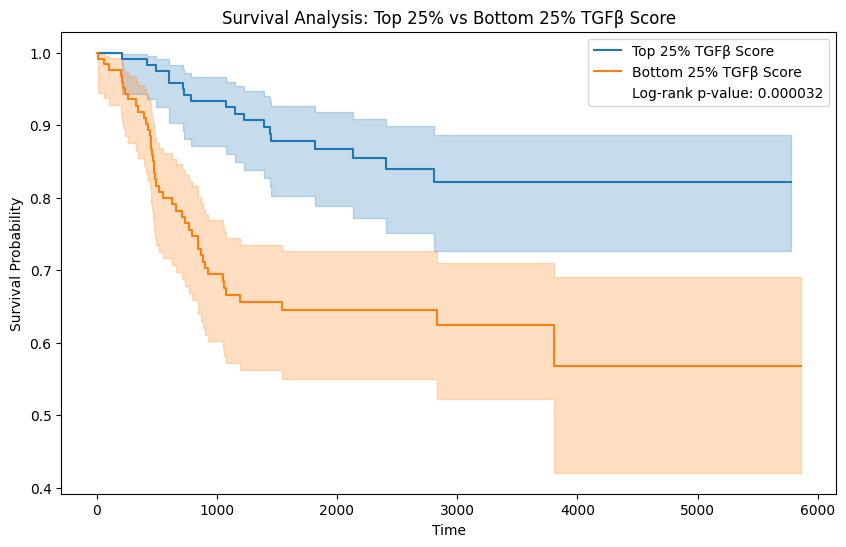

In [39]:
# Stratify samples into top 25% and bottom 25% based on tgfb_score
top_25 = data[data['tgfb_score'] >= data['tgfb_score'].quantile(0.75)]
bottom_25 = data[data['tgfb_score'] <= data['tgfb_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFβ score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFβ Score')
ax = kmf.plot_survival_function()

# Bottom 25% TGFβ score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFβ Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFβ Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFβ Score', f'Bottom 25% TGFβ Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -617.62
         time fit was run = 2024-07-08 13:37:39 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
tgfb_score -1.06      0.35      0.24           -1.53           -0.59                0.22                0.55

            cmp to     z      p  -log2(p)
covariate                                
tgfb_score    0.00 -4.41 <0.005     16.55
---
Concordance = 0.64
Partial AIC = 1237.23
log-likelihood ratio test = 17.94 on 1 df
-log2(p) of ll-ratio test = 15.42

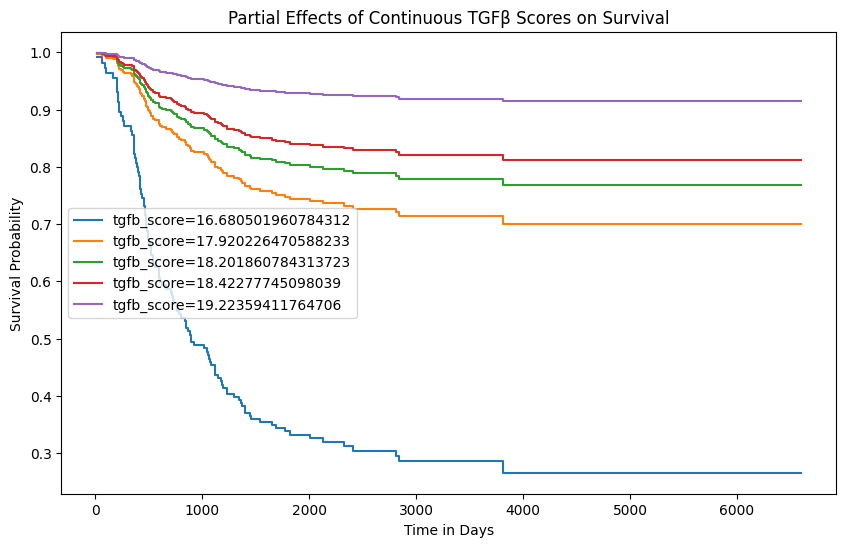

In [40]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'tgfb_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='tgfb_score', values=[cox_data['tgfb_score'].min(), cox_data['tgfb_score'].quantile(0.25), cox_data['tgfb_score'].median(), cox_data['tgfb_score'].quantile(0.75), cox_data['tgfb_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [41]:
# Identify the minimum TGFB expression level
min_tgfb_score = data['tgfb_score'].min()

# Count how many patients have this minimum expression level
count_min_score = (data['tgfb_score'] == min_tgfb_score).sum()

# Print the result
print(f"Number of patients with the lowest TGFB1 expression level ({min_tgfb_score}): {count_min_score}")

Number of patients with the lowest TGFB1 expression level (16.680501960784312): 1


In [42]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['tgfb_score'] == min_tgfb_score]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest TGFB score:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest TGFB score:
      Sample ID
439  SEQC_NB440


### IL2 STAT5

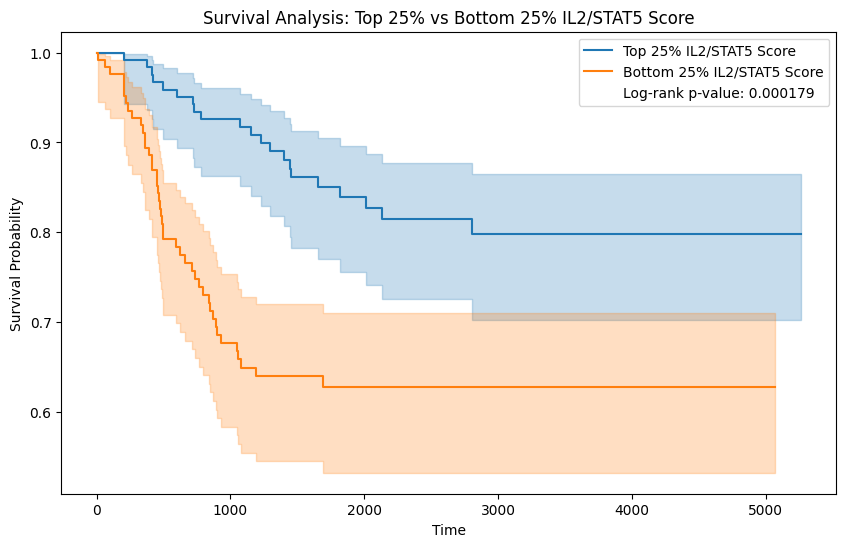

In [43]:
# Stratify samples into top 25% and bottom 25% based on il2_stat5_score
top_25 = data[data['il2_stat5_score'] >= data['il2_stat5_score'].quantile(0.75)]
bottom_25 = data[data['il2_stat5_score'] <= data['il2_stat5_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IL2/STAT5 score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IL2/STAT5 Score')
ax = kmf.plot_survival_function()

# Bottom 25% IL2/STAT5 score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IL2/STAT5 Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IL2/STAT5 Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IL2/STAT5 Score', f'Bottom 25% IL2/STAT5 Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -612.82
         time fit was run = 2024-07-08 13:37:43 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
il2_stat5_score -0.90      0.41      0.16           -1.22           -0.59                0.30                0.56

                 cmp to     z      p  -log2(p)
covariate                                     
il2_stat5_score    0.00 -5.63 <0.005     25.70
---
Concordance = 0.65
Partial AIC = 1227.64
log-likelihood ratio test = 27.53 on 1 df
-log2(p) of ll-ratio test = 22.62

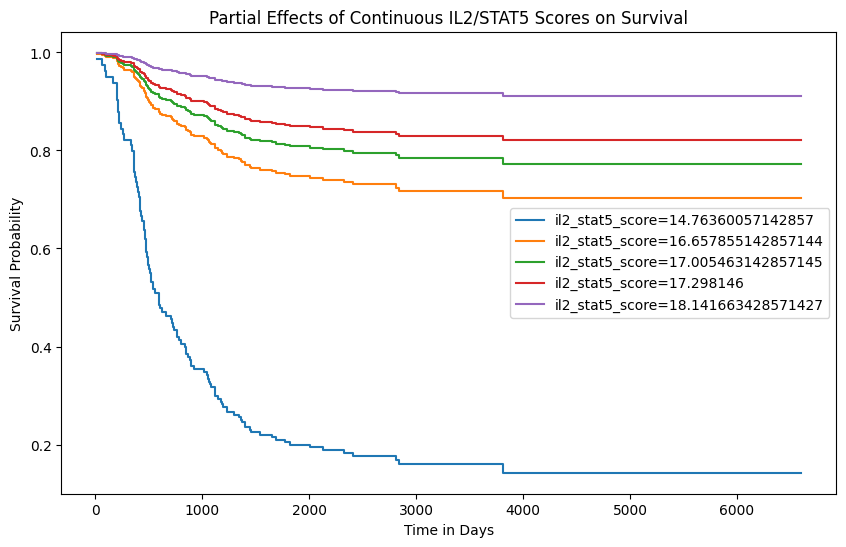

In [44]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'il2_stat5_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IL2/STAT5 scores on survival
cph.plot_partial_effects_on_outcome(covariates='il2_stat5_score', values=[cox_data['il2_stat5_score'].min(), cox_data['il2_stat5_score'].quantile(0.25), cox_data['il2_stat5_score'].median(), cox_data['il2_stat5_score'].quantile(0.75), cox_data['il2_stat5_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IL2/STAT5 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IL6 JAK STAT3

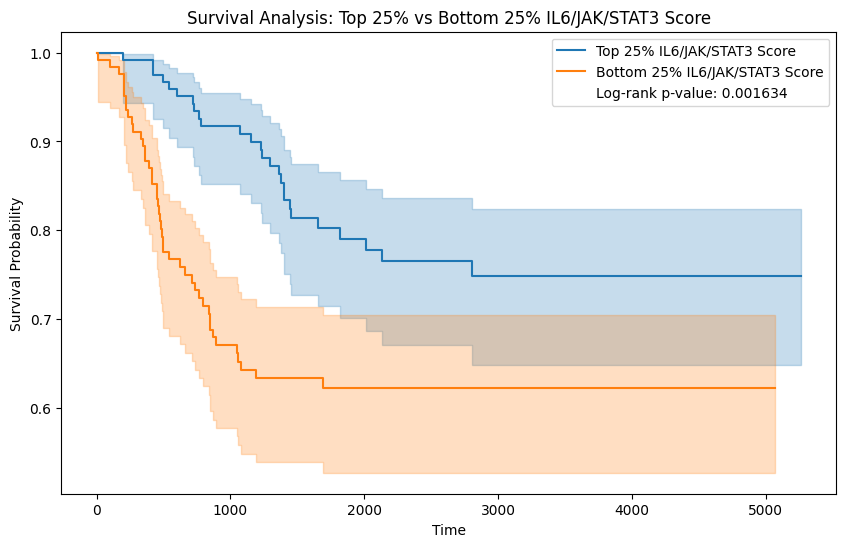

In [45]:
# Stratify samples into top 25% and bottom 25% based on il6_jak_stat3_score
top_25 = data[data['il6_jak_stat3_score'] >= data['il6_jak_stat3_score'].quantile(0.75)]
bottom_25 = data[data['il6_jak_stat3_score'] <= data['il6_jak_stat3_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IL6/JAK/STAT3 score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IL6/JAK/STAT3 Score')
ax = kmf.plot_survival_function()

# Bottom 25% IL6/JAK/STAT3 score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IL6/JAK/STAT3 Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IL6/JAK/STAT3 Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IL6/JAK/STAT3 Score', f'Bottom 25% IL6/JAK/STAT3 Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.27
         time fit was run = 2024-07-08 13:37:46 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
il6_jak_stat3_score -0.51      0.60      0.11           -0.72           -0.30                0.49                0.74

                     cmp to     z      p  -log2(p)
covariate                                         
il6_jak_stat3_score    0.00 -4.81 <0.005     19.34
---
Concordance = 0.62
Partial AIC = 1234.55
log-likelihood ratio test = 20.62 on 1 df
-log2(p) of ll-ratio test = 17.45

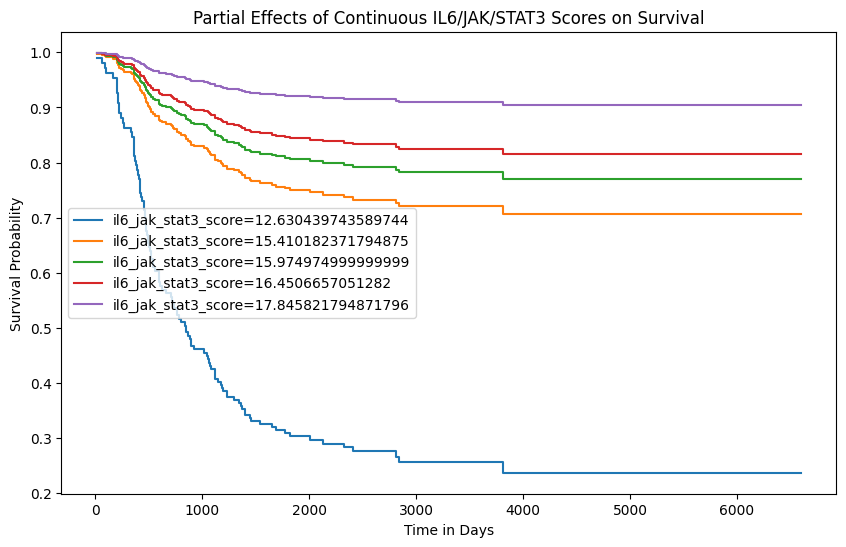

In [46]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'il6_jak_stat3_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IL6/JAK/STAT3 scores on survival
cph.plot_partial_effects_on_outcome(covariates='il6_jak_stat3_score', values=[cox_data['il6_jak_stat3_score'].min(), cox_data['il6_jak_stat3_score'].quantile(0.25), cox_data['il6_jak_stat3_score'].median(), cox_data['il6_jak_stat3_score'].quantile(0.75), cox_data['il6_jak_stat3_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IL6/JAK/STAT3 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### Inflamatory Pathway

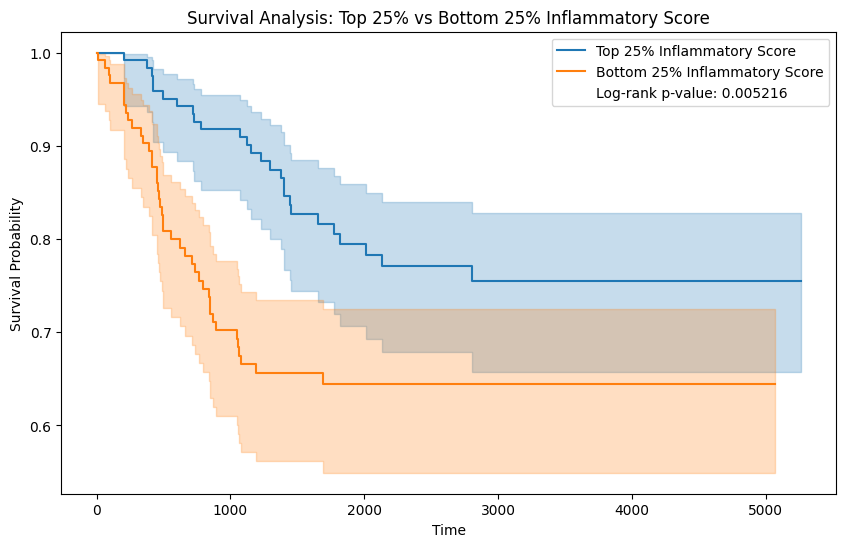

In [47]:
# Stratify samples into top 25% and bottom 25% based on inflammatory_score
top_25 = data[data['inflammatory_score'] >= data['inflammatory_score'].quantile(0.75)]
bottom_25 = data[data['inflammatory_score'] <= data['inflammatory_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% Inflammatory score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Inflammatory Score')
ax = kmf.plot_survival_function()

# Bottom 25% Inflammatory score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Inflammatory Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% Inflammatory Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% Inflammatory Score', f'Bottom 25% Inflammatory Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.25
         time fit was run = 2024-07-08 13:37:49 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
inflammatory_score -0.51      0.60      0.11           -0.72           -0.30                0.49                0.74

                    cmp to     z      p  -log2(p)
covariate                                        
inflammatory_score    0.00 -4.83 <0.005     19.46
---
Concordance = 0.62
Partial AIC = 1234.49
log-likelihood ratio test = 20.67 on 1 df
-log2(p) of ll-ratio test = 17.49

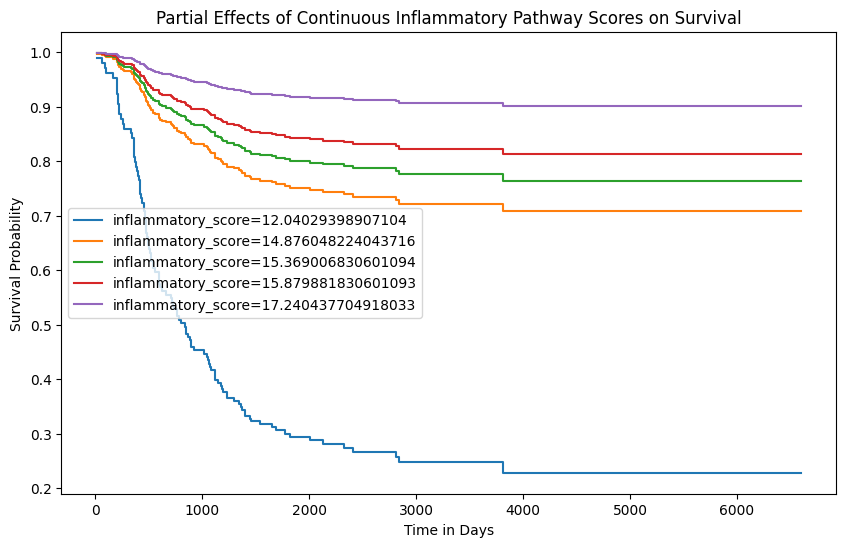

In [48]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'inflammatory_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of Inflammatory Pathway scores on survival
cph.plot_partial_effects_on_outcome(covariates='inflammatory_score', values=[cox_data['inflammatory_score'].min(), cox_data['inflammatory_score'].quantile(0.25), cox_data['inflammatory_score'].median(), cox_data['inflammatory_score'].quantile(0.75), cox_data['inflammatory_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous Inflammatory Pathway Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IFN-Alpha

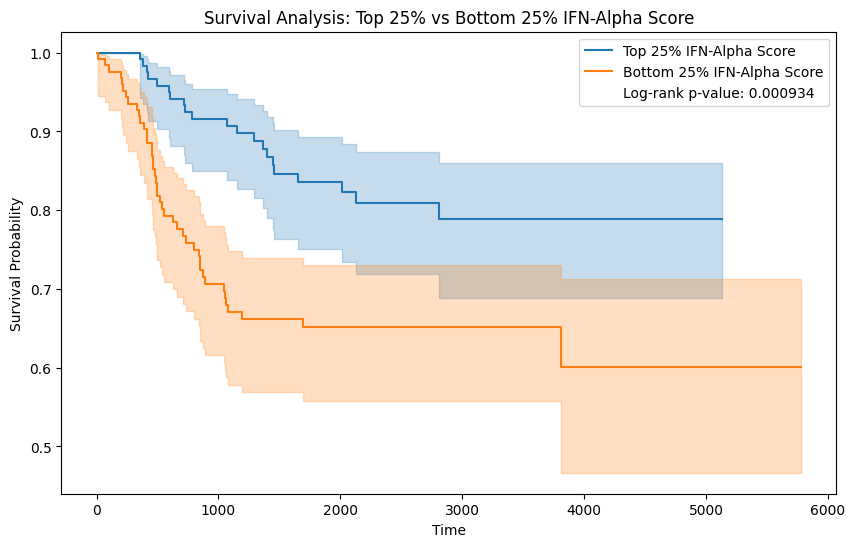

In [49]:
# Stratify samples into top 25% and bottom 25% based on IFN-Alpha score
top_25 = data[data['ifna_score'] >= data['ifna_score'].quantile(0.75)]
bottom_25 = data[data['ifna_score'] <= data['ifna_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IFN-Alpha score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IFN-Alpha Score')
ax = kmf.plot_survival_function()

# Bottom 25% IFN-Alpha score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IFN-Alpha Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IFN-Alpha Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IFN-Alpha Score', f'Bottom 25% IFN-Alpha Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -618.26
         time fit was run = 2024-07-08 13:37:53 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ifna_score -0.55      0.58      0.14           -0.82           -0.29                0.44                0.75

            cmp to     z      p  -log2(p)
covariate                                
ifna_score    0.00 -4.08 <0.005     14.43
---
Concordance = 0.62
Partial AIC = 1238.53
log-likelihood ratio test = 16.64 on 1 df
-log2(p) of ll-ratio test = 14.43

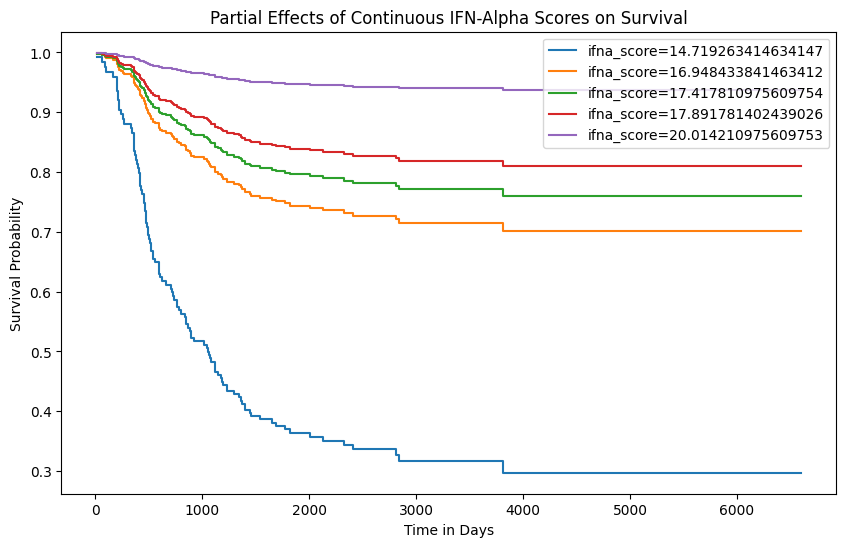

In [50]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ifna_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IFN-a scores on survival
cph.plot_partial_effects_on_outcome(covariates='ifna_score', values=[cox_data['ifna_score'].min(), cox_data['ifna_score'].quantile(0.25), cox_data['ifna_score'].median(), cox_data['ifna_score'].quantile(0.75), cox_data['ifna_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IFN-Alpha Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IFN-Gamma

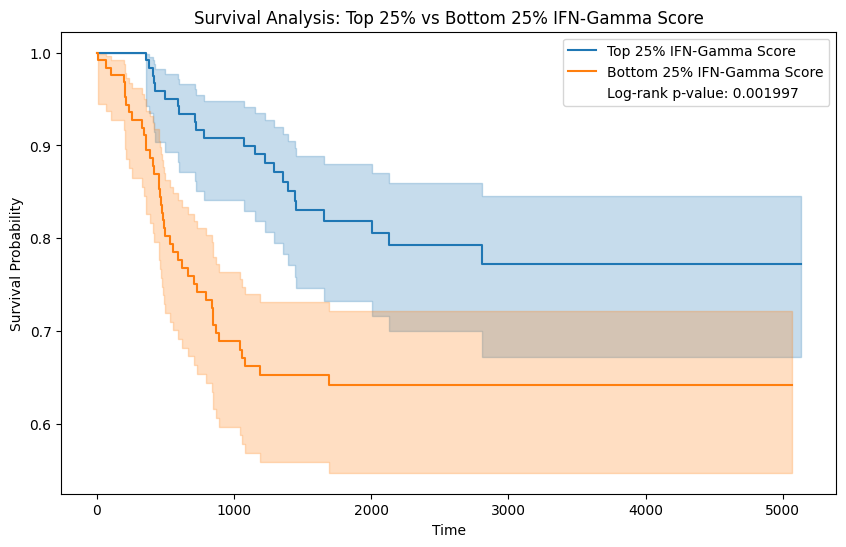

In [51]:
# Stratify samples into top 25% and bottom 25% based on IFN-Gamma score
top_25 = data[data['ifng_score'] >= data['ifng_score'].quantile(0.75)]
bottom_25 = data[data['ifng_score'] <= data['ifng_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IFN-Gamma score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IFN-Gamma Score')
ax = kmf.plot_survival_function()

# Bottom 25% IFN-Gamma score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IFN-Gamma Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IFN-Gamma Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IFN-Gamma Score', f'Bottom 25% IFN-Gamma Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -615.48
         time fit was run = 2024-07-08 13:37:56 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ifng_score -0.63      0.53      0.13           -0.89           -0.38                0.41                0.69

            cmp to     z      p  -log2(p)
covariate                                
ifng_score    0.00 -4.81 <0.005     19.36
---
Concordance = 0.63
Partial AIC = 1232.97
log-likelihood ratio test = 22.20 on 1 df
-log2(p) of ll-ratio test = 18.63

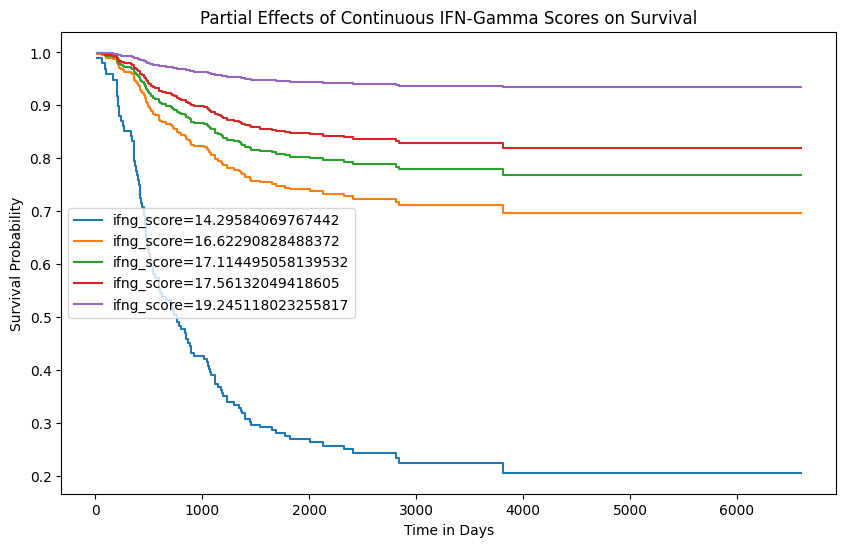

In [52]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ifng_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IFN-Gamma scores on survival
cph.plot_partial_effects_on_outcome(covariates='ifng_score', values=[cox_data['ifng_score'].min(), cox_data['ifng_score'].quantile(0.25), cox_data['ifng_score'].median(), cox_data['ifng_score'].quantile(0.75), cox_data['ifng_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IFN-Gamma Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### Housekeeping

In [53]:
# Extract ACTB expression levels
actb_expression = gene_data.loc[gene_data['Gene'] == 'ACTB', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
actb_expression = actb_expression.reset_index()
actb_expression.columns = ['Sample ID', 'ACTB_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, actb_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['ACTB_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  
0          24.7943  
1          25.2958  
2          24.5375  
3          24.6351  
4          24.9948

In [54]:
actb_expression

Sample ID  ACTB_expression
0    SEQC_NB001          24.7943
1    SEQC_NB002          25.2958
2    SEQC_NB003          24.5375
3    SEQC_NB004          24.6351
4    SEQC_NB005          24.9948
..          ...              ...
493  SEQC_NB494          25.4461
494  SEQC_NB495          25.1602
495  SEQC_NB496          25.1211
496  SEQC_NB497          24.7802
497  SEQC_NB498          25.0471

[498 rows x 2 columns]

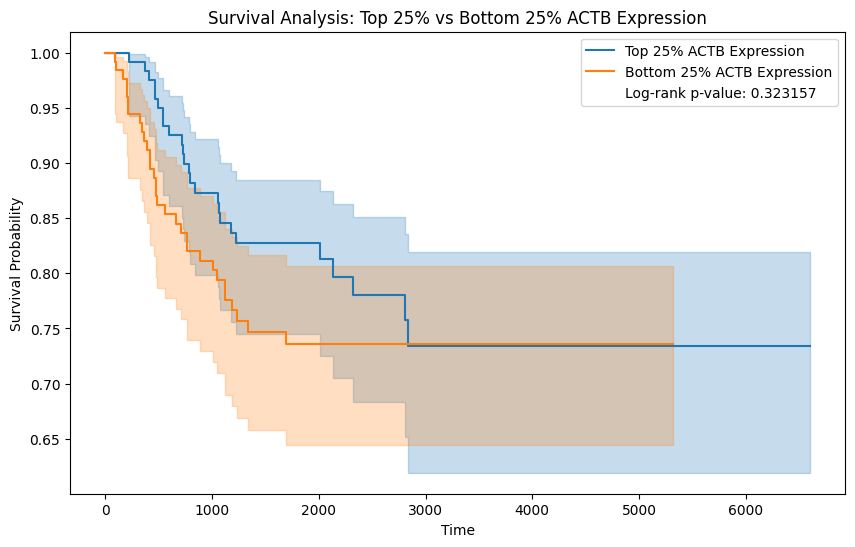

In [55]:
# Stratify samples into top 25% and bottom 25% based on ACTB expression
top_25 = data[data['ACTB_expression'] >= data['ACTB_expression'].quantile(0.75)]
bottom_25 = data[data['ACTB_expression'] <= data['ACTB_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% ACTB expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ACTB Expression')
ax = kmf.plot_survival_function()

# Bottom 25% ACTB expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ACTB Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ACTB Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ACTB Expression', f'Bottom 25% ACTB Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -625.67
         time fit was run = 2024-07-08 13:37:59 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
ACTB_expression -0.34      0.71      0.25           -0.82            0.15                0.44                1.16

                 cmp to     z    p  -log2(p)
covariate                                   
ACTB_expression    0.00 -1.35 0.18      2.49
---
Concordance = 0.55
Partial AIC = 1253.35
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.49

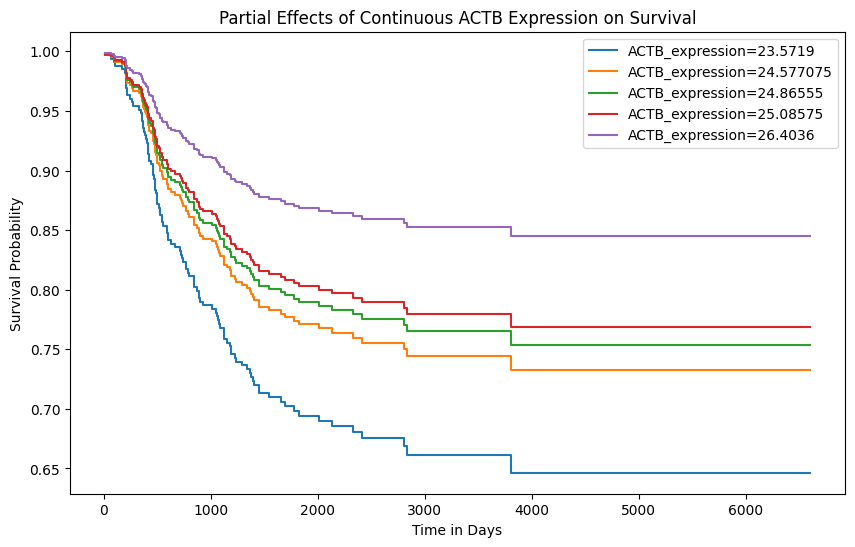

In [56]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ACTB_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='ACTB_expression', values=[cox_data['ACTB_expression'].min(), cox_data['ACTB_expression'].quantile(0.25), cox_data['ACTB_expression'].median(), cox_data['ACTB_expression'].quantile(0.75), cox_data['ACTB_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ACTB Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### TGF-Beta 1

In [57]:
# Extract ACTB expression levels
tgfb1_expression = gene_data.loc[gene_data['Gene'] == 'TGFB1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tgfb1_expression = tgfb1_expression.reset_index()
tgfb1_expression.columns = ['Sample ID', 'TGFB1_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tgfb1_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['TGFB1_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  
0          24.7943           18.3629  
1          25.2958           17.6275  
2          24.5375           17.1150  
3          24.6351           17.8382  
4          24.9948           18.8312

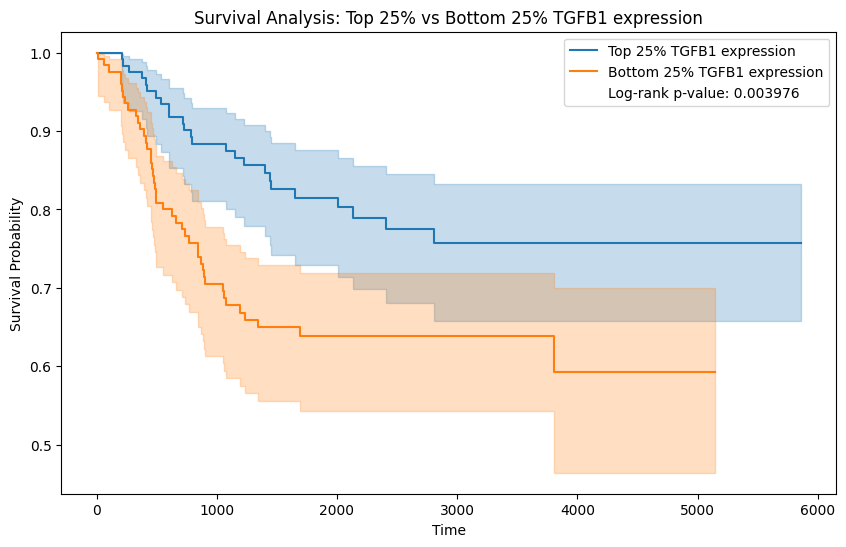

In [58]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['TGFB1_expression'] >= data['TGFB1_expression'].quantile(0.75)]
bottom_25 = data[data['TGFB1_expression'] <= data['TGFB1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFB1 expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFB1 expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFB1 expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFB1 expression', f'Bottom 25% TGFB1 expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -619.45
         time fit was run = 2024-07-08 13:38:02 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
TGFB1_expression -0.41      0.66      0.10           -0.62           -0.21                0.54                0.81

                  cmp to     z      p  -log2(p)
covariate                                      
TGFB1_expression    0.00 -3.92 <0.005     13.44
---
Concordance = 0.60
Partial AIC = 1240.90
log-likelihood ratio test = 14.27 on 1 df
-log2(p) of ll-ratio test = 12.62

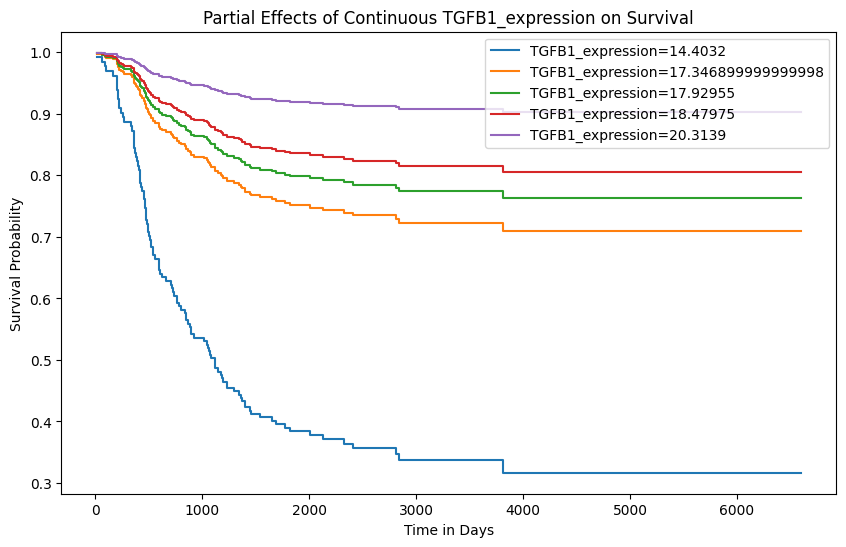

In [59]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB1_expression', values=[cox_data['TGFB1_expression'].min(), cox_data['TGFB1_expression'].quantile(0.25), cox_data['TGFB1_expression'].median(), cox_data['TGFB1_expression'].quantile(0.75), cox_data['TGFB1_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFB1_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [60]:
# Identify the minimum TGFB2 expression level
min_tgfb1_expression = data['TGFB1_expression'].min()

# Count how many patients have this minimum expression level
count_min_expression = (data['TGFB1_expression'] == min_tgfb1_expression).sum()

# Print the result
print(f"Number of patients with the lowest TGFB1 expression level ({min_tgfb1_expression}): {count_min_expression}")

Number of patients with the lowest TGFB1 expression level (14.4032): 1


In [61]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['TGFB1_expression'] == min_tgfb1_expression]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest TGFB1 expression level:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest TGFB1 expression level:
      Sample ID
258  SEQC_NB259


### TGF-Beta 2

In [62]:
# Extract ACTB expression levels
tgfb2_expression = gene_data.loc[gene_data['Gene'] == 'TGFB2', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tgfb2_expression = tgfb2_expression.reset_index()
tgfb2_expression.columns = ['Sample ID', 'TGFB2_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tgfb2_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['TGFB2_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  
0          24.7943           18.3629           13.9009  
1          25.2958           17.6275           13.4102  
2          24.5375           17.1150           16.1935  
3          24.6351           17.8382           17.0180  
4          24.9948           18.8312           16.2454

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -624.19
         time fit was run = 2024-07-08 13:38:04 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
TGFB2_expression -0.19      0.83      0.09           -0.36           -0.02                0.70                0.98

                  cmp to     z    p  -log2(p)
covariate                                    
TGFB2_expression    0.00 -2.23 0.03      5.29
---
Concordance = 0.54
Partial AIC = 1250.39
log-likelihood ratio test = 4.78 on 1 df
-log2(p) of ll-ratio test = 5.12

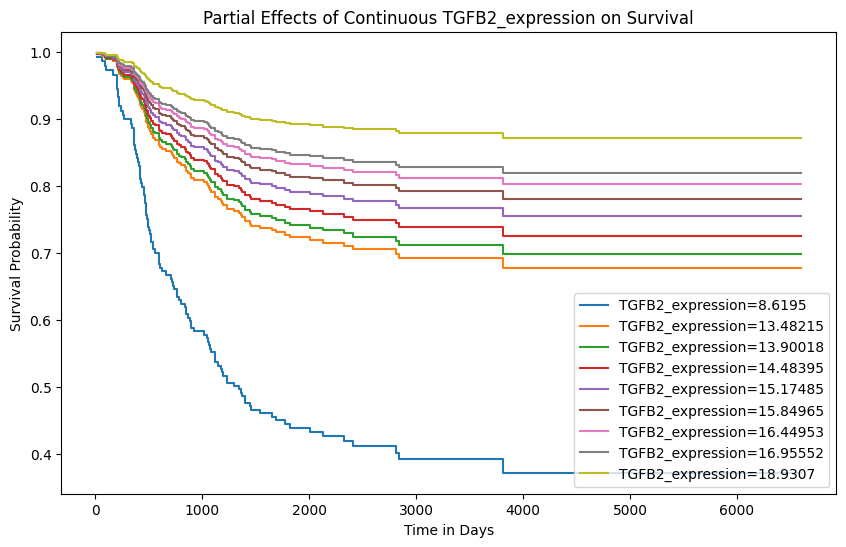

In [63]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB2_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB2_expression', values=[cox_data['TGFB2_expression'].min(),
                                                                           cox_data['TGFB2_expression'].quantile(0.05),
                                                                           cox_data['TGFB2_expression'].quantile(0.10),
                                                                           cox_data['TGFB2_expression'].quantile(0.25),
                                                                           cox_data['TGFB2_expression'].median(),
                                                                           cox_data['TGFB2_expression'].quantile(0.75),
                                                                           cox_data['TGFB2_expression'].quantile(0.90),
                                                                           cox_data['TGFB2_expression'].quantile(0.95),
                                                                           cox_data['TGFB2_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFB2_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [64]:
# Identify the minimum TGFB2 expression level
min_tgfb2_expression = data['TGFB2_expression'].min()

# Count how many patients have this minimum expression level
count_min_expression = (data['TGFB2_expression'] == min_tgfb2_expression).sum()

# Print the result
print(f"Number of patients with the lowest TGFB2 expression level ({min_tgfb2_expression}): {count_min_expression}")

Number of patients with the lowest TGFB2 expression level (8.6195): 1


In [65]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['TGFB2_expression'] == min_tgfb2_expression]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest TGFB2 expression level:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest TGFB2 expression level:
      Sample ID
456  SEQC_NB457


### CD8B

In [66]:
# Extract ACTB expression levels
cd8b_expression = gene_data.loc[gene_data['Gene'] == 'CD8B', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd8b_expression = cd8b_expression.reset_index()
cd8b_expression.columns = ['Sample ID', 'CD8B_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, cd8b_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['CD8B_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  
0          24.7943           18.3629           13.9009          16.7351  
1          25.2958           17.6275           13.4102          15.7871  
2          24.5375           17.1150           16.1935          13.9106  
3          24.6351           17.8382           17.0180          15.0802  
4          24.9948           18.8312           16.2454          13.9488

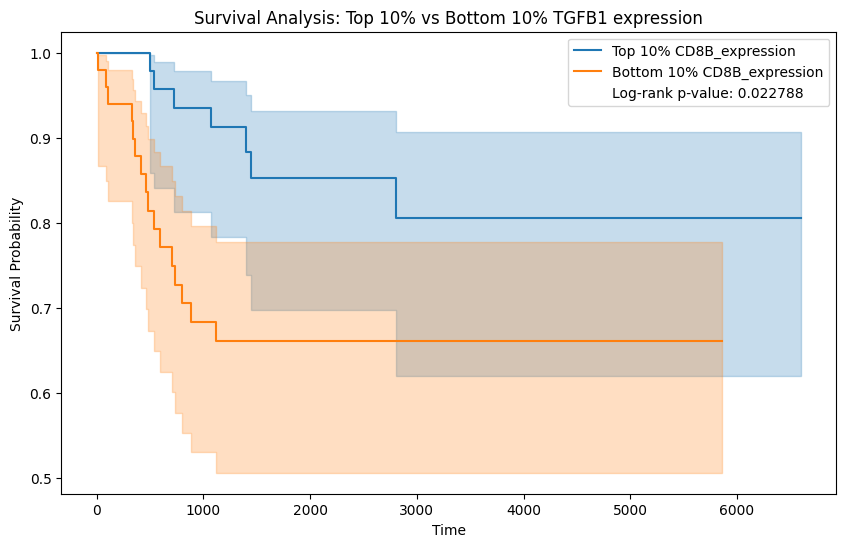

In [67]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['CD8B_expression'] >= data['CD8B_expression'].quantile(0.90)]
bottom_25 = data[data['CD8B_expression'] <= data['CD8B_expression'].quantile(0.10)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD8B_expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD8B_expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 10% vs Bottom 10% TGFB1 expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 10% CD8B_expression', f'Bottom 10% CD8B_expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

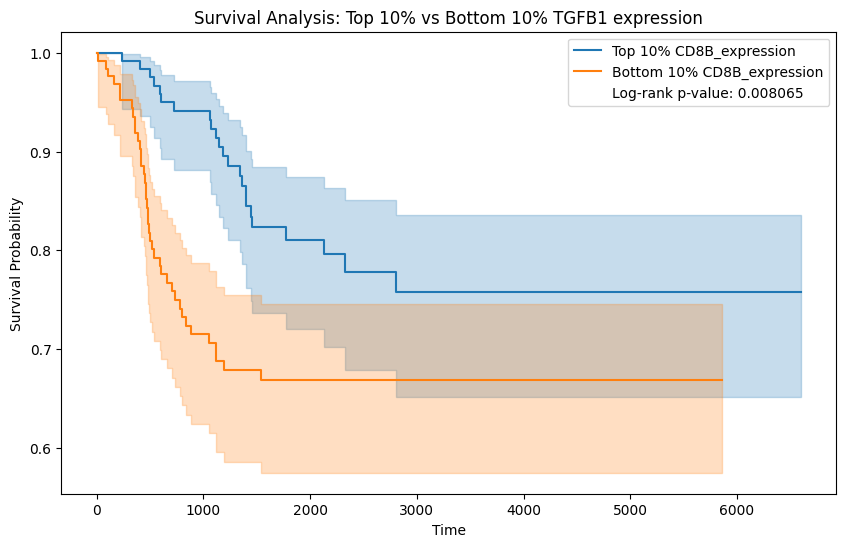

In [68]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['CD8B_expression'] >= data['CD8B_expression'].quantile(0.75)]
bottom_25 = data[data['CD8B_expression'] <= data['CD8B_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD8B_expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD8B_expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 10% vs Bottom 10% TGFB1 expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 10% CD8B_expression', f'Bottom 10% CD8B_expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -621.88
         time fit was run = 2024-07-08 13:38:09 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
CD8B_expression -0.19      0.83      0.06           -0.31           -0.07                0.73                0.93

                 cmp to     z      p  -log2(p)
covariate                                     
CD8B_expression    0.00 -3.16 <0.005      9.29
---
Concordance = 0.62
Partial AIC = 1245.75
log-likelihood ratio test = 9.41 on 1 df
-log2(p) of ll-ratio test = 8.86

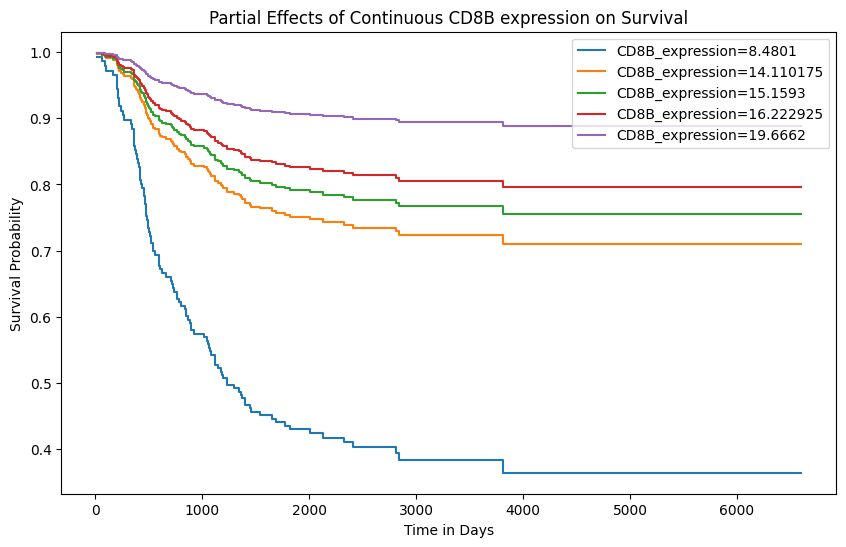

In [69]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of CD8B expression on survival
cph.plot_partial_effects_on_outcome(covariates='CD8B_expression', values=[cox_data['CD8B_expression'].min(), cox_data['CD8B_expression'].quantile(0.25), cox_data['CD8B_expression'].median(), cox_data['CD8B_expression'].quantile(0.75), cox_data['CD8B_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous CD8B expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [70]:
# Identify the minimum CD8B expression level
min_cd8b_expression = data['CD8B_expression'].min()

# Count how many patients have this minimum expression level
count_min_expression = (data['CD8B_expression'] == min_cd8b_expression).sum()

# Print the result
print(f"Number of patients with the lowest CD8B expression level ({min_cd8b_expression}): {count_min_expression}")

Number of patients with the lowest CD8B expression level (8.4801): 1


In [71]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['CD8B_expression'] == min_cd8b_expression]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest CD8B expression level:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest CD8B expression level:
      Sample ID
331  SEQC_NB332


### CD4

In [72]:
# Extract CD4 expression levels
cd4_expression = gene_data.loc[gene_data['Gene'] == 'CD4', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd4_expression = cd4_expression.reset_index()
cd4_expression.columns = ['Sample ID', 'CD4_expression']

# Map CD4 expression to the main data DataFrame
data = pd.merge(data, cd4_expression, on='Sample ID', how='left')

# Drop samples with missing CD4 expression
data.dropna(subset=['CD4_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  
0         19.4368  
1         18.6085  
2         17.0932  
3         18.2924  
4         17.4225

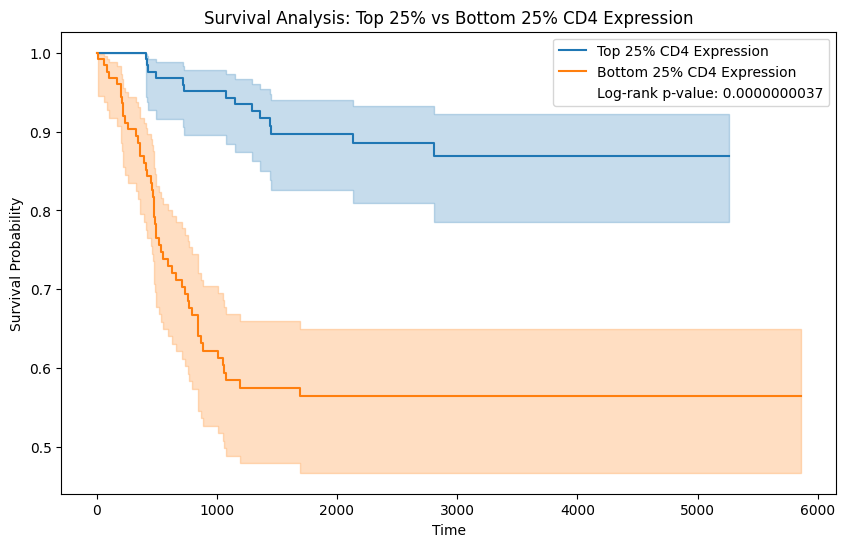

In [73]:
# Stratify samples into top 25% and bottom 25% based on CD4 expression
top_25 = data[data['CD4_expression'] >= data['CD4_expression'].quantile(0.75)]
bottom_25 = data[data['CD4_expression'] <= data['CD4_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% CD4 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD4 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% CD4 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD4 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD4 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% CD4 Expression', f'Bottom 25% CD4 Expression', f'Log-rank p-value: {p_value:.10f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -601.82
         time fit was run = 2024-07-08 13:38:12 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
CD4_expression -0.54      0.58      0.07           -0.68           -0.40                0.51                0.67

                cmp to     z      p  -log2(p)
covariate                                    
CD4_expression    0.00 -7.59 <0.005     44.79
---
Concordance = 0.71
Partial AIC = 1205.65
log-likelihood ratio test = 49.52 on 1 df
-log2(p) of ll-ratio test = 38.89

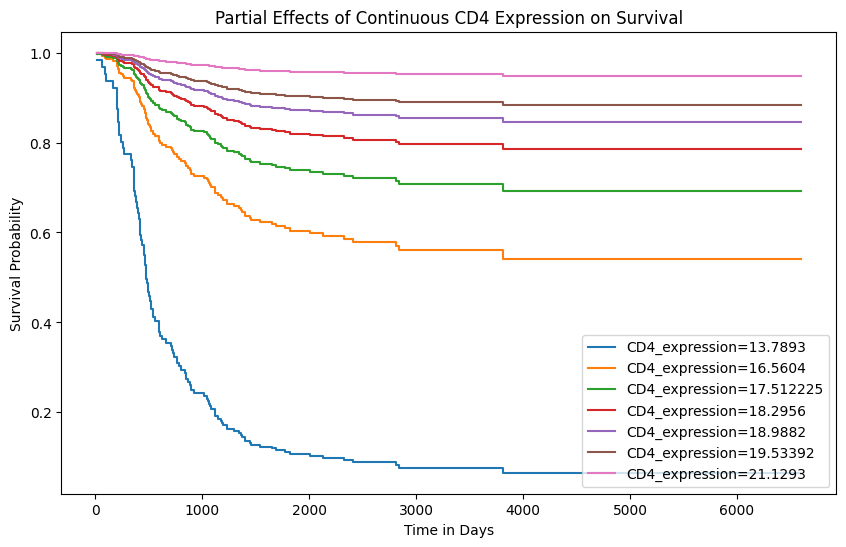

In [74]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of CD4 expression on survival
cph.plot_partial_effects_on_outcome(
    covariates='CD4_expression', 
    values=[
        cox_data['CD4_expression'].min(),
        cox_data['CD4_expression'].quantile(0.10),
        cox_data['CD4_expression'].quantile(0.25), 
        cox_data['CD4_expression'].median(), 
        cox_data['CD4_expression'].quantile(0.75),
        cox_data['CD4_expression'].quantile(0.90),
        cox_data['CD4_expression'].max()
    ], 
    plot_baseline=False, 
    figsize=(10, 6)
)
plt.title('Partial Effects of Continuous CD4 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()


### FOXP3

In [75]:
# Extract ACTB expression levels
foxp3_expression = gene_data.loc[gene_data['Gene'] == 'FOXP3', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
foxp3_expression = foxp3_expression.reset_index()
foxp3_expression.columns = ['Sample ID', 'FOXP3_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, foxp3_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['FOXP3_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  FOXP3_expression  
0         19.4368           14.8703  
1         18.6085           14.3456  
2         17.0932           11.9281  
3         18.2924           13.3204  
4         17.4225           12.6749

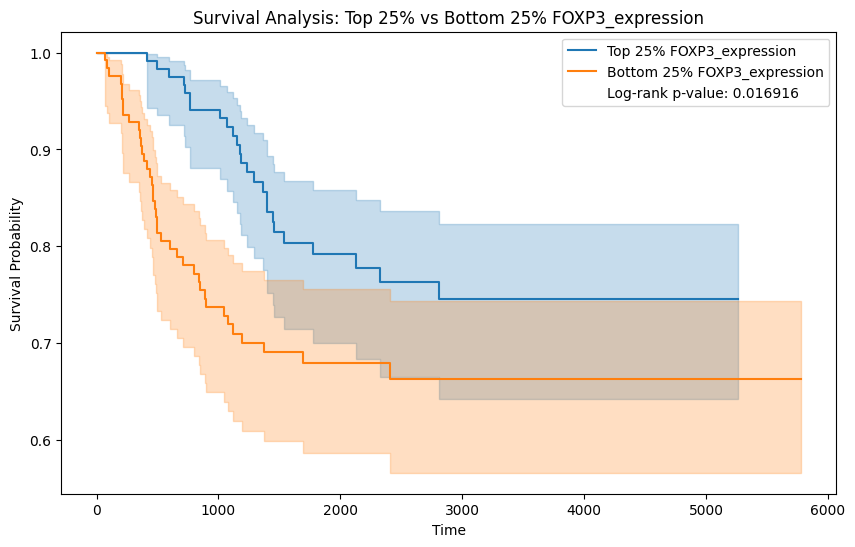

In [76]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['FOXP3_expression'] >= data['FOXP3_expression'].quantile(0.75)]
bottom_25 = data[data['FOXP3_expression'] <= data['FOXP3_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% FOXP3_expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% FOXP3_expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% FOXP3_expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% FOXP3_expression', f'Bottom 25% FOXP3_expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -621.12
         time fit was run = 2024-07-08 13:38:15 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
FOXP3_expression -0.32      0.73      0.10           -0.50           -0.13                0.60                0.88

                  cmp to     z      p  -log2(p)
covariate                                      
FOXP3_expression    0.00 -3.33 <0.005     10.15
---
Concordance = 0.61
Partial AIC = 1244.23
log-likelihood ratio test = 10.93 on 1 df
-log2(p) of ll-ratio test = 10.05

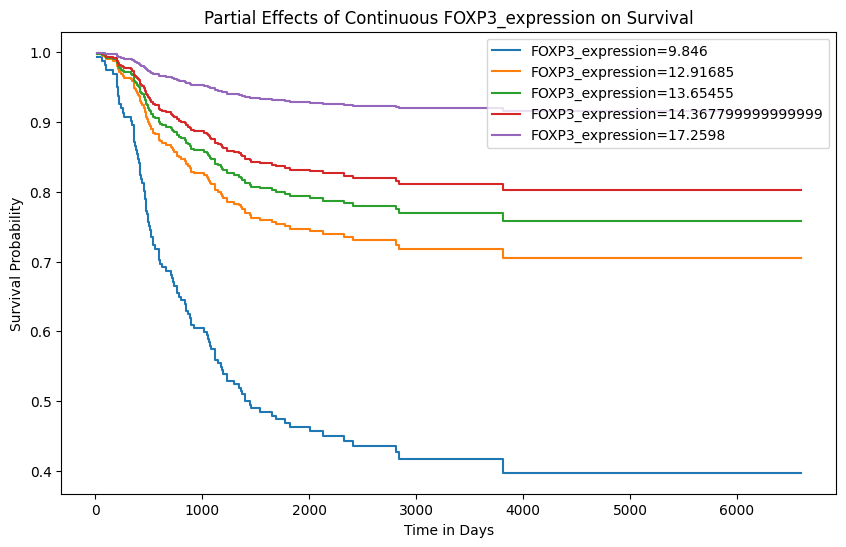

In [77]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'FOXP3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='FOXP3_expression', values=[cox_data['FOXP3_expression'].min(), cox_data['FOXP3_expression'].quantile(0.25), cox_data['FOXP3_expression'].median(), cox_data['FOXP3_expression'].quantile(0.75), cox_data['FOXP3_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous FOXP3_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### CD3E

In [78]:
# Extract CD3E expression levels
cd3e_expression = gene_data.loc[gene_data['Gene'] == 'CD3E', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd3e_expression = cd3e_expression.reset_index()
cd3e_expression.columns = ['Sample ID', 'CD3E_expression']

# Map CD3E expression to the main data DataFrame
data = pd.merge(data, cd3e_expression, on='Sample ID', how='left')

# Drop samples with missing CD3E expression
data.dropna(subset=['CD3E_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  FOXP3_expression  CD3E_expression  
0         19.4368           14.8703          19.3001  
1         18.6085           14.3456          17.6781  
2         17.0932           11.9281          11.2751  
3         18.2924           13.3204          15.5401  
4         17.4225           12.6749          12.8399

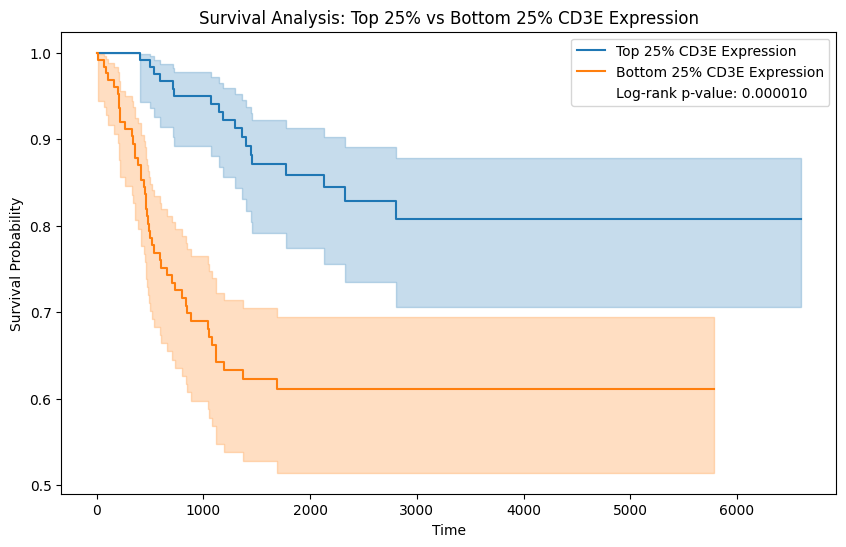

In [79]:
# Stratify samples into top 25% and bottom 25% based on CD3E expression
top_25 = data[data['CD3E_expression'] >= data['CD3E_expression'].quantile(0.75)]
bottom_25 = data[data['CD3E_expression'] <= data['CD3E_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% CD3E expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD3E Expression')
ax = kmf.plot_survival_function()

# Bottom 25% CD3E expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD3E Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD3E Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% CD3E Expression', f'Bottom 25% CD3E Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -609.67
         time fit was run = 2024-07-08 13:38:18 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
CD3E_expression -0.27      0.76      0.05           -0.36           -0.19                0.70                0.83

                 cmp to     z      p  -log2(p)
covariate                                     
CD3E_expression    0.00 -6.07 <0.005     29.56
---
Concordance = 0.66
Partial AIC = 1221.33
log-likelihood ratio test = 33.83 on 1 df
-log2(p) of ll-ratio test = 27.31

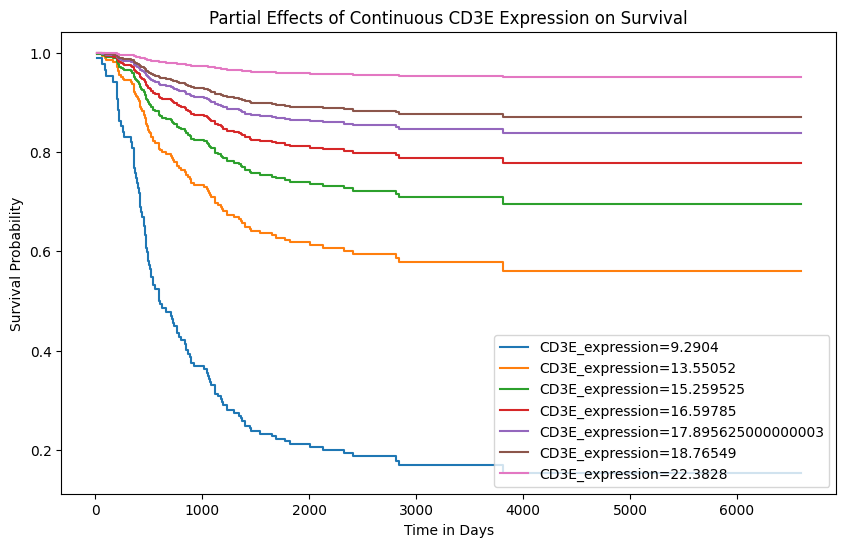

In [80]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD3E_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of CD3E expression on survival
cph.plot_partial_effects_on_outcome(
    covariates='CD3E_expression', 
    values=[
        cox_data['CD3E_expression'].min(),
        cox_data['CD3E_expression'].quantile(0.10),
        cox_data['CD3E_expression'].quantile(0.25), 
        cox_data['CD3E_expression'].median(), 
        cox_data['CD3E_expression'].quantile(0.75),
        cox_data['CD3E_expression'].quantile(0.90),
        cox_data['CD3E_expression'].max()
    ], 
    plot_baseline=False, 
    figsize=(10, 6)
)
plt.title('Partial Effects of Continuous CD3E Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()


### PDCD1

In [81]:
# Extract PDCD1 expression levels
pdcd1_expression = gene_data.loc[gene_data['Gene'] == 'PDCD1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
pdcd1_expression = pdcd1_expression.reset_index()
pdcd1_expression.columns = ['Sample ID', 'PDCD1_expression']

# Map PDCD1 expression to the main data DataFrame
data = pd.merge(data, pdcd1_expression, on='Sample ID', how='left')

# Drop samples with missing PDCD1 expression
data.dropna(subset=['PDCD1_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  FOXP3_expression  CD3E_expression  PDCD1_expression  
0         19.4368           14.8703          19.3001           13.8244  
1         18.6085           14.3456          17.6781           13.7639  
2         17.0932           11.9281          11.2751           12.5989  
3         18.2924           13.3204          15.5401           11.5378  
4         17.4225           12.6749          12.8399           12.4565

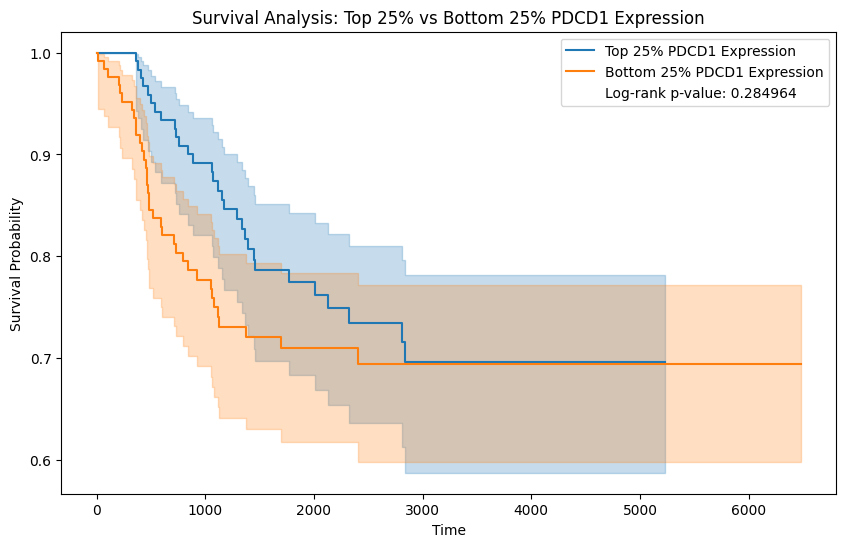

In [82]:
# Stratify samples into top 25% and bottom 25% based on PDCD1 expression
top_25 = data[data['PDCD1_expression'] >= data['PDCD1_expression'].quantile(0.75)]
bottom_25 = data[data['PDCD1_expression'] <= data['PDCD1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% PDCD1 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% PDCD1 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% PDCD1 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% PDCD1 Expression', f'Bottom 25% PDCD1 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -624.86
         time fit was run = 2024-07-08 13:38:22 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
PDCD1_expression -0.07      0.93      0.04           -0.15           -0.00                0.86                1.00

                  cmp to     z    p  -log2(p)
covariate                                    
PDCD1_expression    0.00 -2.02 0.04      4.53
---
Concordance = 0.56
Partial AIC = 1251.72
log-likelihood ratio test = 3.45 on 1 df
-log2(p) of ll-ratio test = 3.98

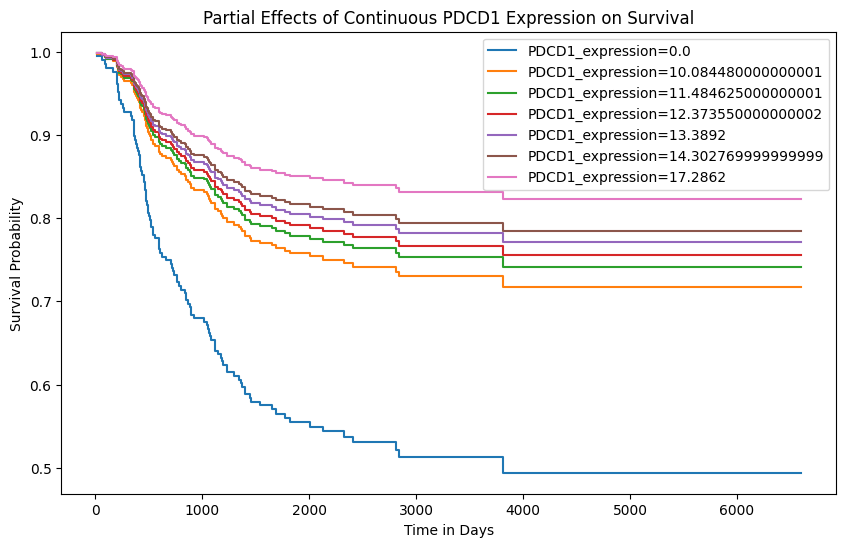

In [83]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'PDCD1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of PDCD1 expression on survival
cph.plot_partial_effects_on_outcome(
    covariates='PDCD1_expression', 
    values=[
        cox_data['PDCD1_expression'].min(),
        cox_data['PDCD1_expression'].quantile(0.10),
        cox_data['PDCD1_expression'].quantile(0.25), 
        cox_data['PDCD1_expression'].median(), 
        cox_data['PDCD1_expression'].quantile(0.75),
        cox_data['PDCD1_expression'].quantile(0.90),
        cox_data['PDCD1_expression'].max()
    ], 
    plot_baseline=False, 
    figsize=(10, 6)
)
plt.title('Partial Effects of Continuous PDCD1 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### ODC1

In [84]:
# Extract ACTB expression levels
odc1_expression = gene_data.loc[gene_data['Gene'] == 'ODC1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
odc1_expression = odc1_expression.reset_index()
odc1_expression.columns = ['Sample ID', 'ODC1_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, odc1_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['ODC1_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  FOXP3_expression  CD3E_expression  PDCD1_expression  \
0         19.4368           14.8703          19.3001           13.8244   
1         18.6085           14.3456          17.6781           13.7639   
2         17.0932           11.9281          11.2751           12.5989   
3         18.2924           13.3204          15.5401           11.5378   
4         17.4225           12.6749          12.8399           12.4565   

   ODC1_expression  
0          21.3850  
1          21.0267  
2          22.7247  
3          21.0662  
4          21.8427

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -585.30
         time fit was run = 2024-07-08 13:38:25 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
ODC1_expression  0.54      1.72      0.05            0.45            0.63                1.57                1.88

                 cmp to     z      p  -log2(p)
covariate                                     
ODC1_expression    0.00 11.62 <0.005    101.35
---
Concordance = 0.81
Partial AIC = 1172.59
log-likelihood ratio test = 82.57 on 1 df
-log2(p) of ll-ratio test = 63.09

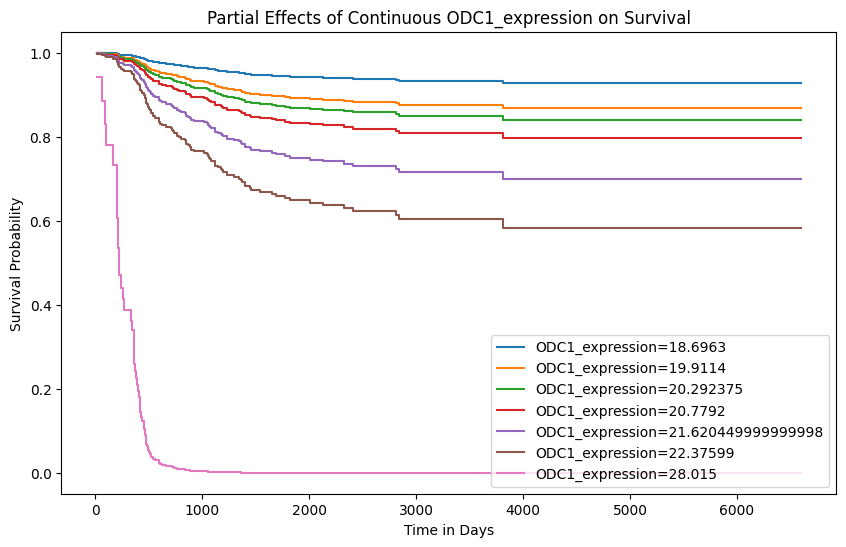

In [85]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ODC1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='ODC1_expression',values=[cox_data['ODC1_expression'].min(),
                                                                         cox_data['ODC1_expression'].quantile(0.10),
                                                                         cox_data['ODC1_expression'].quantile(0.25),
                                                                         cox_data['ODC1_expression'].median(),
                                                                         cox_data['ODC1_expression'].quantile(0.75),
                                                                         cox_data['ODC1_expression'].quantile(0.90),
                                                                         cox_data['ODC1_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ODC1_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### MYCN

In [86]:
# Extract MYCN expression levels
mycn_expression = gene_data.loc[gene_data['Gene'] == 'MYCN', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
mycn_expression = mycn_expression.reset_index()
mycn_expression.columns = ['Sample ID', 'MYCN_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, mycn_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['MYCN_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  FOXP3_expression  CD3E_expression  PDCD1_expression  \
0         19.4368           14.8703          19.3001           13.8244   
1         18.6085           14.3456          17.6781           13.7639   
2         17.0932           11.9281          11.2751           12.5989   
3         18.2924           13.3204          15.5401           11.5378   
4         17.4225           12.6749          12.8399           12.4565   

   ODC1_expression  MYCN_expression  
0          21.3850          18.8478  
1          21.0267          18.2026  
2          22.7247          23.4092  
3          21.0662          22.2447  
4          21.8427          23.4390

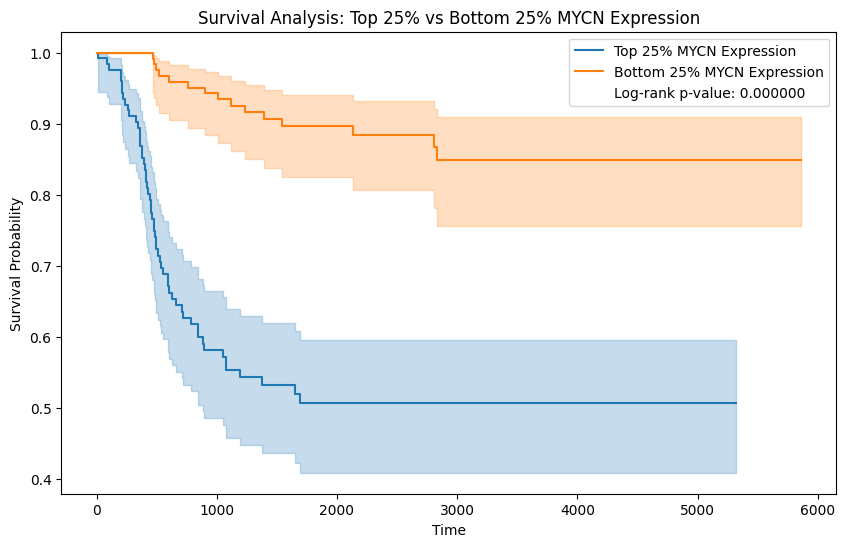

In [87]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['MYCN_expression'] >= data['MYCN_expression'].quantile(0.75)]
bottom_25 = data[data['MYCN_expression'] <= data['MYCN_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% MYCN Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% MYCN Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% MYCN Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% MYCN Expression', f'Bottom 25% MYCN Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -587.10
         time fit was run = 2024-07-08 13:38:28 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
MYCN_expression  0.41      1.51      0.04            0.33            0.50                1.39                1.65

                 cmp to    z      p  -log2(p)
covariate                                    
MYCN_expression    0.00 9.56 <0.005     69.51
---
Concordance = 0.71
Partial AIC = 1176.20
log-likelihood ratio test = 78.97 on 1 df
-log2(p) of ll-ratio test = 60.46

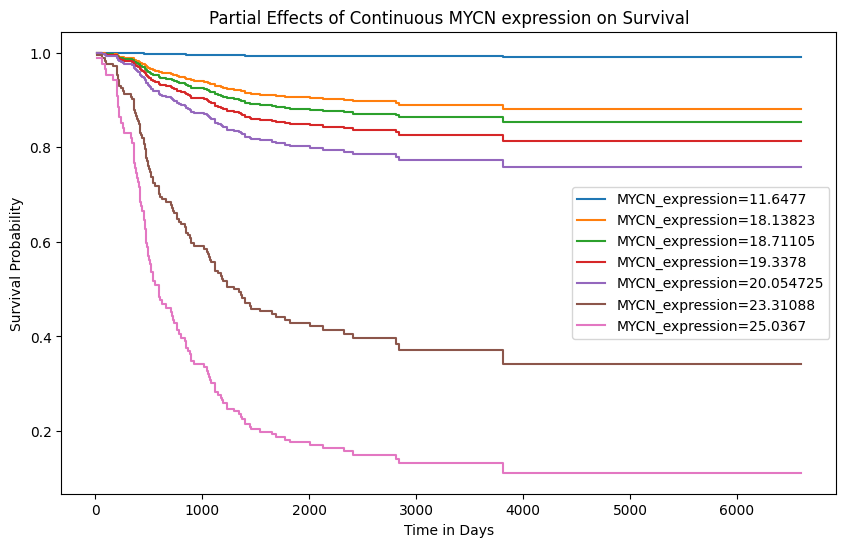

In [88]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'MYCN_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='MYCN_expression',values=[cox_data['MYCN_expression'].min(),
                                                                         cox_data['MYCN_expression'].quantile(0.10),
                                                                         cox_data['MYCN_expression'].quantile(0.25),
                                                                         cox_data['MYCN_expression'].median(),
                                                                         cox_data['MYCN_expression'].quantile(0.75),
                                                                         cox_data['MYCN_expression'].quantile(0.90),
                                                                         cox_data['MYCN_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous MYCN expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## MHC-1

HLA-A

HLA-B

HLA-C

In [89]:
'''
# Extract MYCN expression levels
mhc1_expression = gene_data.loc[gene_data['Gene'] == 'MHC1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
mhc1_expression = mhc1_expression.reset_index()
mhc1_expression.columns = ['Sample ID', 'MHC1_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, mhc1_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['MHC1_expression'], inplace=True)

# Verify the data structure
data.head()
'''

"\n# Extract MYCN expression levels\nmhc1_expression = gene_data.loc[gene_data['Gene'] == 'MHC1', gene_data.columns[8:]].squeeze()\n\n# Convert the Series to a DataFrame and reset index to turn the indices into a column\nmhc1_expression = mhc1_expression.reset_index()\nmhc1_expression.columns = ['Sample ID', 'MHC1_expression']\n\n# Map GAPDH expression to the main data DataFrame\ndata = pd.merge(data, mhc1_expression, on='Sample ID', how='left')\n\n# Drop samples with missing ACTB expression\ndata.dropna(subset=['MHC1_expression'], inplace=True)\n\n# Verify the data structure\ndata.head()\n"

## B2M

In [90]:
# Extract MYCN expression levels
b2m_expression = gene_data.loc[gene_data['Gene'] == 'B2M', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
b2m_expression = b2m_expression.reset_index()
b2m_expression.columns = ['Sample ID', 'B2M_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, b2m_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['B2M_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  TGFB1_expression  TGFB2_expression  CD8B_expression  \
0          24.7943           18.3629           13.9009          16.7351   
1          25.2958           17.6275           13.4102          15.7871   
2          24.5375           17.1150           16.1935          13.9106   
3          24.6351           17.8382           17.0180          15.0802   
4          24.9948           18.8312           16.2454          13.9488   

   CD4_expression  FOXP3_expression  CD3E_expression  PDCD1_expression  \
0         19.4368           14.8703          19.3001           13.8244   
1         18.6085           14.3456          17.6781           13.7639   
2         17.0932           11.9281          11.2751           12.5989   
3         18.2924           13.3204          15.5401           11.5378   
4         17.4225           12.6749          12.8399           12.4565   

   ODC1_expression  MYCN_expression  B2M_expression  
0          21.3850          18.8478         24.9077  
1          21.0267          18.2026         23.4424  
2          22.7247          23.4092         22.7246  
3          21.0662          22.2447         23.6647  
4          21.8427          23.4390         23.9312

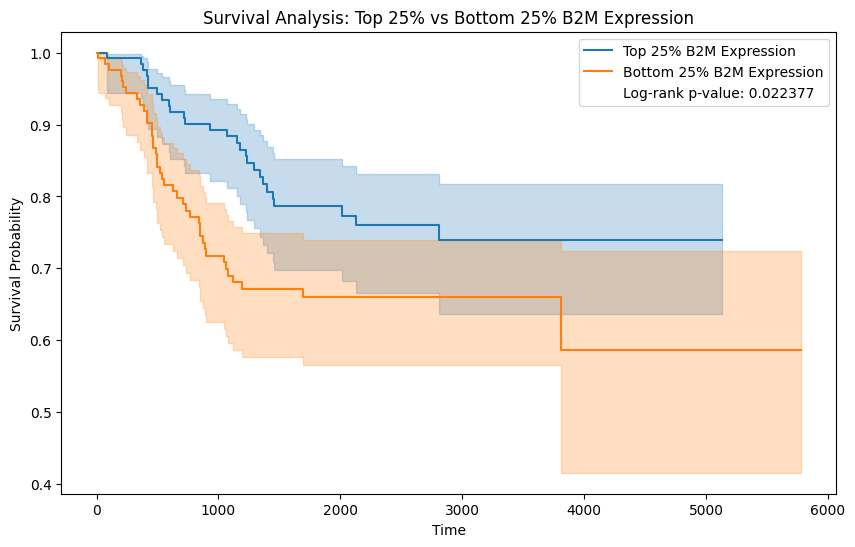

In [91]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['B2M_expression'] >= data['B2M_expression'].quantile(0.75)]
bottom_25 = data[data['B2M_expression'] <= data['B2M_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% B2M Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% B2M Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% B2M Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% B2M Expression', f'Bottom 25% B2M Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


## ALK

In [92]:
# Extract MYCN expression levels
alk_expression = gene_data.loc[gene_data['Gene'] == 'ALK', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
alk_expression = alk_expression.reset_index()
alk_expression.columns = ['Sample ID', 'ALK_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, alk_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['ALK_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  TGFB2_expression  CD8B_expression  CD4_expression  \
0          24.7943  ...           13.9009          16.7351         19.4368   
1          25.2958  ...           13.4102          15.7871         18.6085   
2          24.5375  ...           16.1935          13.9106         17.0932   
3          24.6351  ...           17.0180          15.0802         18.2924   
4          24.9948  ...           16.2454          13.9488         17.4225   

   FOXP3_expression  CD3E_expression  PDCD1_expression  ODC1_expression  \
0           14.8703          19.3001           13.8244          21.3850   
1           14.3456          17.6781           13.7639          21.0267   
2           11.9281          11.2751           12.5989          22.7247   
3           13.3204          15.5401           11.5378          21.0662   
4           12.6749          12.8399           12.4565          21.8427   

   MYCN_expression  B2M_expression  ALK_expression  
0          18.8478         24.9077         19.7321  
1          18.2026         23.4424         19.4120  
2          23.4092         22.7246         17.6522  
3          22.2447         23.6647         19.8907  
4          23.4390         23.9312         19.8295  

[5 rows x 21 columns]

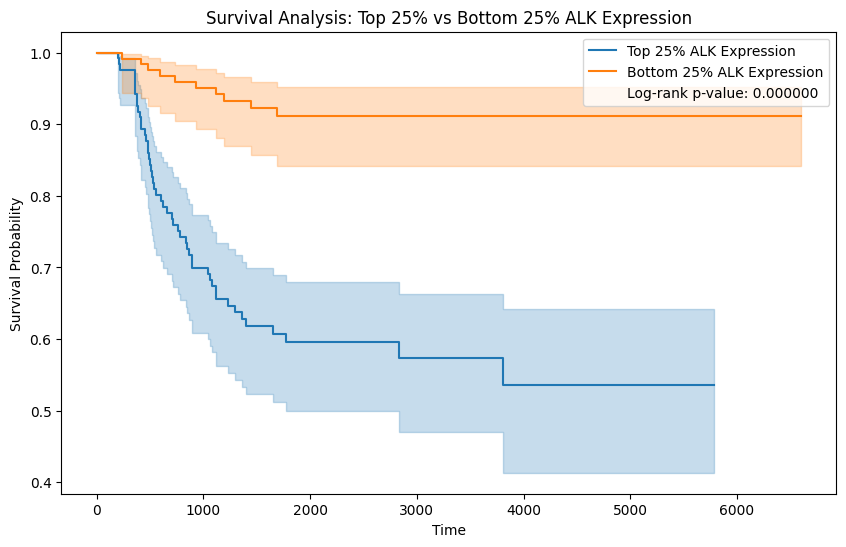

In [93]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['ALK_expression'] >= data['ALK_expression'].quantile(0.75)]
bottom_25 = data[data['ALK_expression'] <= data['ALK_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ALK Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ALK Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ALK Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ALK Expression', f'Bottom 25% ALK Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


## PHOX2B

In [94]:
# Extract MYCN expression levels
phox2b_expression = gene_data.loc[gene_data['Gene'] == 'PHOX2B', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
phox2b_expression = phox2b_expression.reset_index()
phox2b_expression.columns = ['Sample ID', 'PHOX2B_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, phox2b_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['PHOX2B_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  CD8B_expression  CD4_expression  FOXP3_expression  \
0          24.7943  ...          16.7351         19.4368           14.8703   
1          25.2958  ...          15.7871         18.6085           14.3456   
2          24.5375  ...          13.9106         17.0932           11.9281   
3          24.6351  ...          15.0802         18.2924           13.3204   
4          24.9948  ...          13.9488         17.4225           12.6749   

   CD3E_expression  PDCD1_expression  ODC1_expression  MYCN_expression  \
0          19.3001           13.8244          21.3850          18.8478   
1          17.6781           13.7639          21.0267          18.2026   
2          11.2751           12.5989          22.7247          23.4092   
3          15.5401           11.5378          21.0662          22.2447   
4          12.8399           12.4565          21.8427          23.4390   

   B2M_expression  ALK_expression  PHOX2B_expression  
0         24.9077         19.7321            21.4680  
1         23.4424         19.4120            22.3111  
2         22.7246         17.6522            21.7303  
3         23.6647         19.8907            22.3325  
4         23.9312         19.8295            21.4514  

[5 rows x 22 columns]

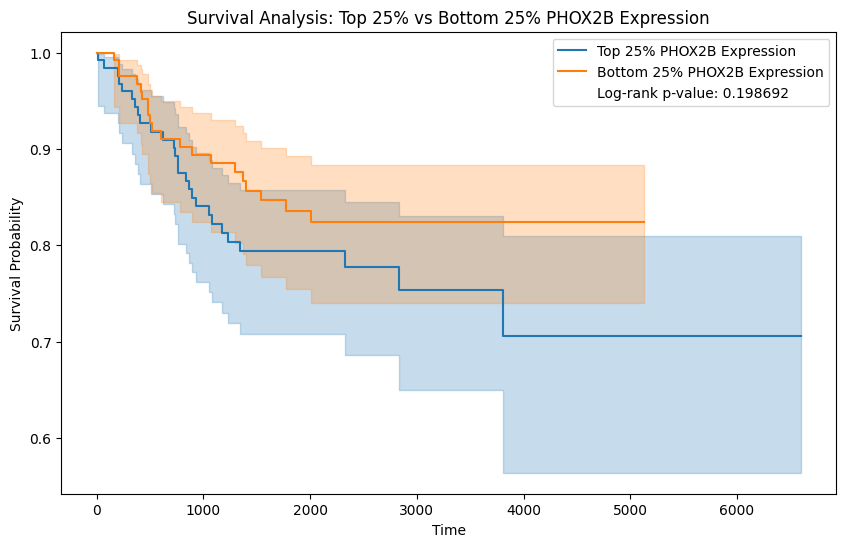

In [95]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['PHOX2B_expression'] >= data['PHOX2B_expression'].quantile(0.75)]
bottom_25 = data[data['PHOX2B_expression'] <= data['PHOX2B_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% PHOX2B Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% PHOX2B Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% PHOX2B Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% PHOX2B Expression', f'Bottom 25% PHOX2B Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


## PRRX

In [96]:
# Extract MYCN expression levels
prrx1_expression = gene_data.loc[gene_data['Gene'] == 'PRRX1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
prrx1_expression = prrx1_expression.reset_index()
prrx1_expression.columns = ['Sample ID', 'PRRX1_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, prrx1_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['PRRX1_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  CD4_expression  FOXP3_expression  CD3E_expression  \
0          24.7943  ...         19.4368           14.8703          19.3001   
1          25.2958  ...         18.6085           14.3456          17.6781   
2          24.5375  ...         17.0932           11.9281          11.2751   
3          24.6351  ...         18.2924           13.3204          15.5401   
4          24.9948  ...         17.4225           12.6749          12.8399   

   PDCD1_expression  ODC1_expression  MYCN_expression  B2M_expression  \
0           13.8244          21.3850          18.8478         24.9077   
1           13.7639          21.0267          18.2026         23.4424   
2           12.5989          22.7247          23.4092         22.7246   
3           11.5378          21.0662          22.2447         23.6647   
4           12.4565          21.8427          23.4390         23.9312   

   ALK_expression  PHOX2B_expression  PRRX1_expression  
0         19.7321            21.4680           17.2395  
1         19.4120            22.3111           17.0943  
2         17.6522            21.7303           17.0796  
3         19.8907            22.3325           17.0327  
4         19.8295            21.4514           19.9534  

[5 rows x 23 columns]

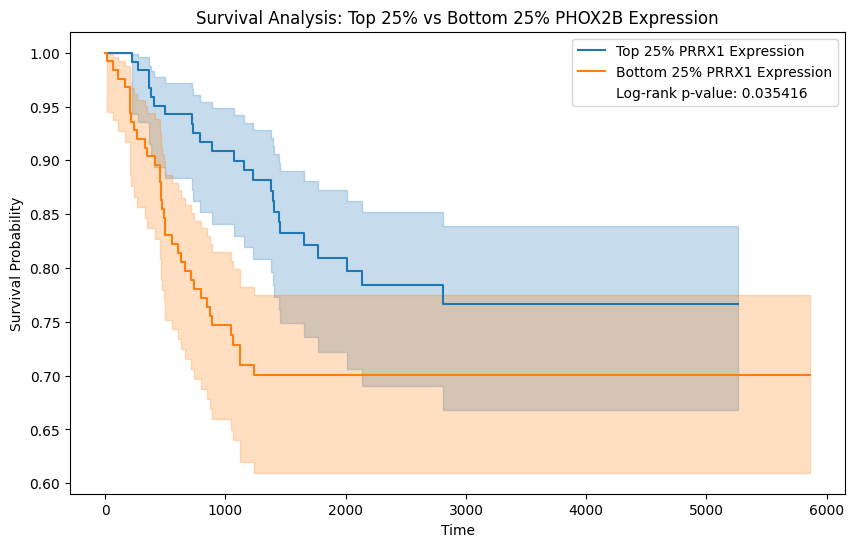

In [97]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['PRRX1_expression'] >= data['PRRX1_expression'].quantile(0.75)]
bottom_25 = data[data['PRRX1_expression'] <= data['PRRX1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% PRRX1 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% PRRX1 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% PHOX2B Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% PRRX1 Expression', f'Bottom 25% PRRX1 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


## CD274

In [98]:
# Extract CD274 expression levels
cd274_expression = gene_data.loc[gene_data['Gene'] == 'CD274', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd274_expression = cd274_expression.reset_index()
cd274_expression.columns = ['Sample ID', 'CD274_expression']

# Map CD274 expression to the main data DataFrame
data = pd.merge(data, cd274_expression, on='Sample ID', how='left')

# Drop samples with missing CD274 expression
data.dropna(subset=['CD274_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  FOXP3_expression  CD3E_expression  PDCD1_expression  \
0          24.7943  ...           14.8703          19.3001           13.8244   
1          25.2958  ...           14.3456          17.6781           13.7639   
2          24.5375  ...           11.9281          11.2751           12.5989   
3          24.6351  ...           13.3204          15.5401           11.5378   
4          24.9948  ...           12.6749          12.8399           12.4565   

   ODC1_expression  MYCN_expression  B2M_expression  ALK_expression  \
0          21.3850          18.8478         24.9077         19.7321   
1          21.0267          18.2026         23.4424         19.4120   
2          22.7247          23.4092         22.7246         17.6522   
3          21.0662          22.2447         23.6647         19.8907   
4          21.8427          23.4390         23.9312         19.8295   

   PHOX2B_expression  PRRX1_expression  CD274_expression  
0            21.4680           17.2395           15.0988  
1            22.3111           17.0943           14.3239  
2            21.7303           17.0796           11.6978  
3            22.3325           17.0327           14.0074  
4            21.4514           19.9534           12.5165  

[5 rows x 24 columns]

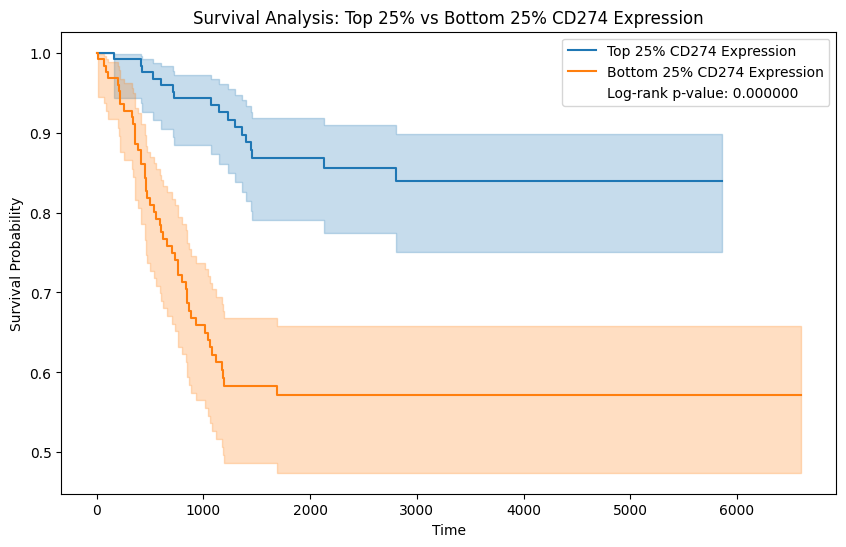

In [99]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['CD274_expression'] >= data['CD274_expression'].quantile(0.75)]
bottom_25 = data[data['CD274_expression'] <= data['CD274_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD274 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD274 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD274 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% CD274 Expression', f'Bottom 25% CD274 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -610.49
         time fit was run = 2024-07-08 13:38:37 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
CD274_expression -0.41      0.66      0.07           -0.54           -0.28                0.58                0.75

                  cmp to     z      p  -log2(p)
covariate                                      
CD274_expression    0.00 -6.21 <0.005     30.79
---
Concordance = 0.68
Partial AIC = 1222.99
log-likelihood ratio test = 32.18 on 1 df
-log2(p) of ll-ratio test = 26.08

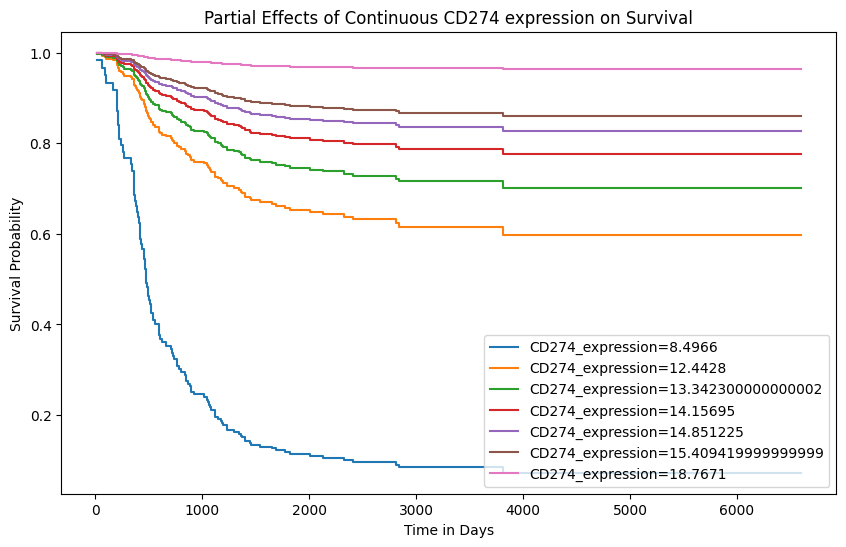

In [100]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD274_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='CD274_expression',values=[cox_data['CD274_expression'].min(),
                                                                         cox_data['CD274_expression'].quantile(0.10),
                                                                         cox_data['CD274_expression'].quantile(0.25),
                                                                         cox_data['CD274_expression'].median(),
                                                                         cox_data['CD274_expression'].quantile(0.75),
                                                                         cox_data['CD274_expression'].quantile(0.90),
                                                                         cox_data['CD274_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous CD274 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## TGF-Beta 3

In [101]:
# Extract TGFB3 expression levels
tgfb3_expression = gene_data.loc[gene_data['Gene'] == 'TGFB3', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tgfb3_expression = tgfb3_expression.reset_index()
tgfb3_expression.columns = ['Sample ID', 'TGFB3_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tgfb3_expression, on='Sample ID', how='left')

# Drop samples with missing TGFB3 expression
data.dropna(subset=['TGFB3_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  CD3E_expression  PDCD1_expression  ODC1_expression  \
0          24.7943  ...          19.3001           13.8244          21.3850   
1          25.2958  ...          17.6781           13.7639          21.0267   
2          24.5375  ...          11.2751           12.5989          22.7247   
3          24.6351  ...          15.5401           11.5378          21.0662   
4          24.9948  ...          12.8399           12.4565          21.8427   

   MYCN_expression  B2M_expression  ALK_expression  PHOX2B_expression  \
0          18.8478         24.9077         19.7321            21.4680   
1          18.2026         23.4424         19.4120            22.3111   
2          23.4092         22.7246         17.6522            21.7303   
3          22.2447         23.6647         19.8907            22.3325   
4          23.4390         23.9312         19.8295            21.4514   

   PRRX1_expression  CD274_expression  TGFB3_expression  
0           17.2395           15.0988           16.0817  
1           17.0943           14.3239           15.3162  
2           17.0796           11.6978           16.8757  
3           17.0327           14.0074           17.1117  
4           19.9534           12.5165           18.6260  

[5 rows x 25 columns]

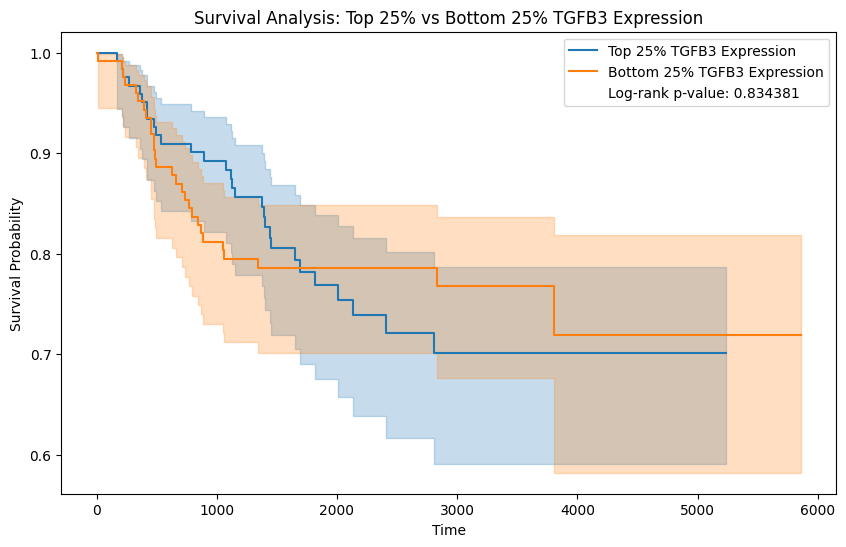

In [102]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['TGFB3_expression'] >= data['TGFB3_expression'].quantile(0.75)]
bottom_25 = data[data['TGFB3_expression'] <= data['TGFB3_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB3 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFB3 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB3 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFB3 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFB3 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFB3 Expression', f'Bottom 25% TGFB3 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -626.54
         time fit was run = 2024-07-08 13:38:41 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
TGFB3_expression -0.03      0.97      0.10           -0.22            0.16                0.80                1.18

                  cmp to     z    p  -log2(p)
covariate                                    
TGFB3_expression    0.00 -0.30 0.76      0.39
---
Concordance = 0.52
Partial AIC = 1255.08
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.39

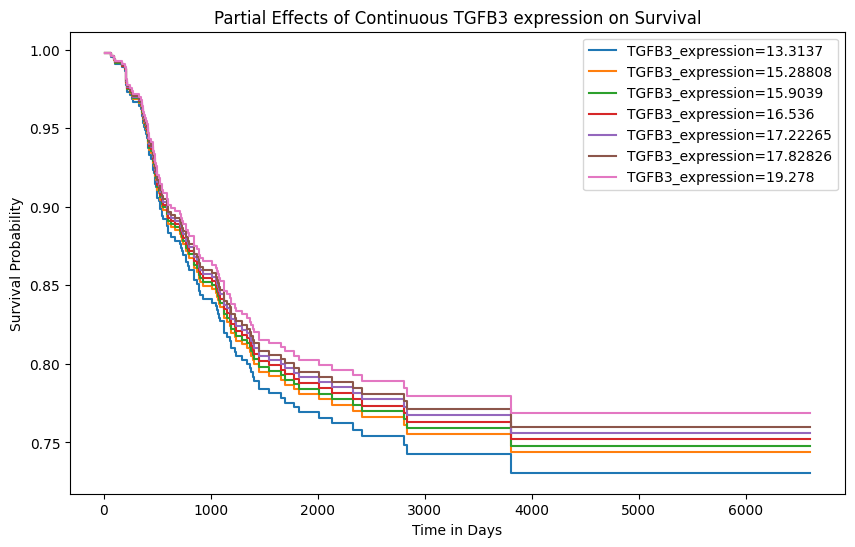

In [103]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB3_expression',values=[cox_data['TGFB3_expression'].min(),
                                                                         cox_data['TGFB3_expression'].quantile(0.10),
                                                                         cox_data['TGFB3_expression'].quantile(0.25),
                                                                         cox_data['TGFB3_expression'].median(),
                                                                         cox_data['TGFB3_expression'].quantile(0.75),
                                                                         cox_data['TGFB3_expression'].quantile(0.90),
                                                                         cox_data['TGFB3_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFB3 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## GNAS

In [104]:
# Extract GNAS expression levels
gnas_expression = gene_data.loc[gene_data['Gene'] == 'GNAS', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
gnas_expression = gnas_expression.reset_index()
gnas_expression.columns = ['Sample ID', 'GNAS_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, gnas_expression, on='Sample ID', how='left')

# Drop samples with missing GNAS expression
data.dropna(subset=['GNAS_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  PDCD1_expression  ODC1_expression  MYCN_expression  \
0          24.7943  ...           13.8244          21.3850          18.8478   
1          25.2958  ...           13.7639          21.0267          18.2026   
2          24.5375  ...           12.5989          22.7247          23.4092   
3          24.6351  ...           11.5378          21.0662          22.2447   
4          24.9948  ...           12.4565          21.8427          23.4390   

   B2M_expression  ALK_expression  PHOX2B_expression  PRRX1_expression  \
0         24.9077         19.7321            21.4680           17.2395   
1         23.4424         19.4120            22.3111           17.0943   
2         22.7246         17.6522            21.7303           17.0796   
3         23.6647         19.8907            22.3325           17.0327   
4         23.9312         19.8295            21.4514           19.9534   

   CD274_expression  TGFB3_expression  GNAS_expression  
0           15.0988           16.0817          24.1815  
1           14.3239           15.3162          24.9106  
2           11.6978           16.8757          24.7266  
3           14.0074           17.1117          24.8053  
4           12.5165           18.6260          24.9375  

[5 rows x 26 columns]

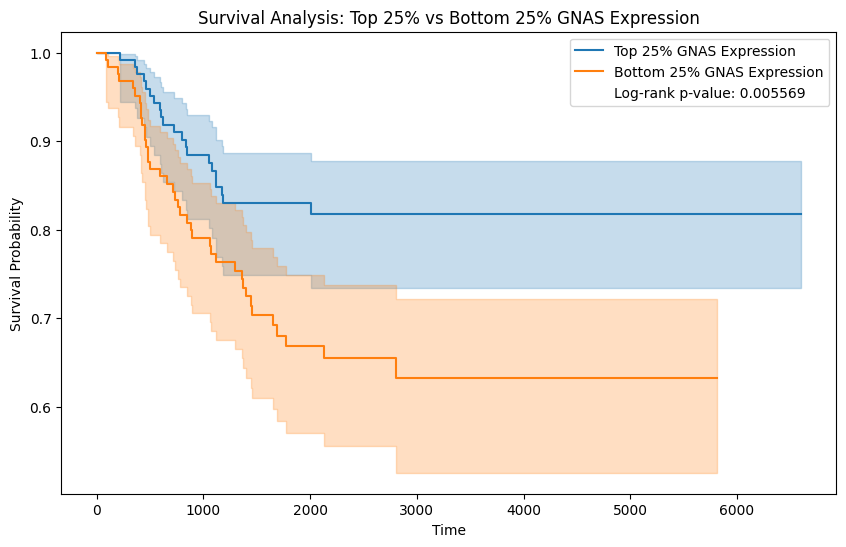

In [105]:
# Stratify samples into top 25% and bottom 25% based on GNAS expression
top_25 = data[data['GNAS_expression'] >= data['GNAS_expression'].quantile(0.75)]
bottom_25 = data[data['GNAS_expression'] <= data['GNAS_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% GNAS expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% GNAS Expression')
ax = kmf.plot_survival_function()

# Bottom 25% GNAS expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% GNAS Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% GNAS Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% GNAS Expression', f'Bottom 25% GNAS Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -620.77
         time fit was run = 2024-07-08 13:38:45 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
GNAS_expression -0.65      0.52      0.19           -1.03           -0.27                0.36                0.76

                 cmp to     z      p  -log2(p)
covariate                                     
GNAS_expression    0.00 -3.39 <0.005     10.50
---
Concordance = 0.58
Partial AIC = 1243.53
log-likelihood ratio test = 11.63 on 1 df
-log2(p) of ll-ratio test = 10.59

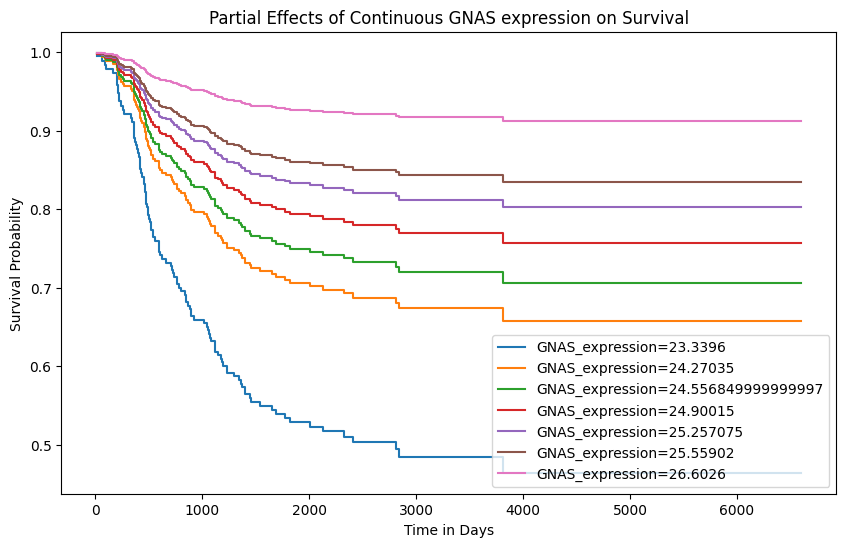

In [106]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'GNAS_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='GNAS_expression',values=[cox_data['GNAS_expression'].min(),
                                                                         cox_data['GNAS_expression'].quantile(0.10),
                                                                         cox_data['GNAS_expression'].quantile(0.25),
                                                                         cox_data['GNAS_expression'].median(),
                                                                         cox_data['GNAS_expression'].quantile(0.75),
                                                                         cox_data['GNAS_expression'].quantile(0.90),
                                                                         cox_data['GNAS_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous GNAS expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## ADRB-1

In [107]:
# Extract GNAS expression levels
adrb1_expression = gene_data.loc[gene_data['Gene'] == 'ADRB1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
adrb1_expression = adrb1_expression.reset_index()
adrb1_expression.columns = ['Sample ID', 'ADRB1_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, adrb1_expression, on='Sample ID', how='left')

# Drop samples with missing GNAS expression
data.dropna(subset=['ADRB1_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  ODC1_expression  MYCN_expression  B2M_expression  \
0          24.7943  ...          21.3850          18.8478         24.9077   
1          25.2958  ...          21.0267          18.2026         23.4424   
2          24.5375  ...          22.7247          23.4092         22.7246   
3          24.6351  ...          21.0662          22.2447         23.6647   
4          24.9948  ...          21.8427          23.4390         23.9312   

   ALK_expression  PHOX2B_expression  PRRX1_expression  CD274_expression  \
0         19.7321            21.4680           17.2395           15.0988   
1         19.4120            22.3111           17.0943           14.3239   
2         17.6522            21.7303           17.0796           11.6978   
3         19.8907            22.3325           17.0327           14.0074   
4         19.8295            21.4514           19.9534           12.5165   

   TGFB3_expression  GNAS_expression  ADRB1_expression  
0           16.0817          24.1815            0.0000  
1           15.3162          24.9106            8.1209  
2           16.8757          24.7266            8.5208  
3           17.1117          24.8053            6.8402  
4           18.6260          24.9375            0.0000  

[5 rows x 27 columns]

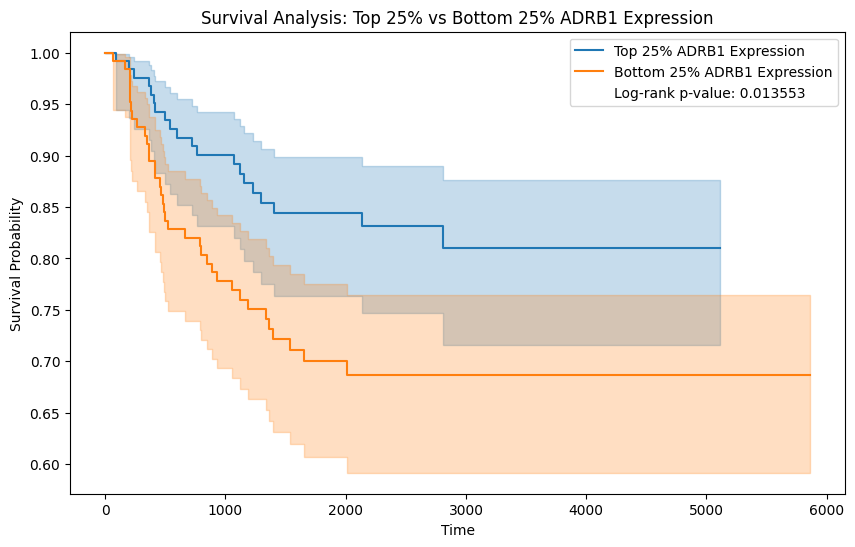

In [108]:
# Stratify samples into top 25% and bottom 25% based on ADRB1 expression
top_25 = data[data['ADRB1_expression'] >= data['ADRB1_expression'].quantile(0.75)]
bottom_25 = data[data['ADRB1_expression'] <= data['ADRB1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% GNAS expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ADRB1 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% GNAS expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ADRB1 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ADRB1 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ADRB1 Expression', f'Bottom 25% ADRB1 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -622.65
         time fit was run = 2024-07-08 13:38:48 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ADRB1_expression -0.07      0.93      0.02           -0.12           -0.02                0.89                0.98

                  cmp to     z      p  -log2(p)
covariate                                      
ADRB1_expression    0.00 -2.89 <0.005      8.04
---
Concordance = 0.57
Partial AIC = 1247.29
log-likelihood ratio test = 7.87 on 1 df
-log2(p) of ll-ratio test = 7.64

/home/jupyter-me1117/venv/lib/python3.9/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


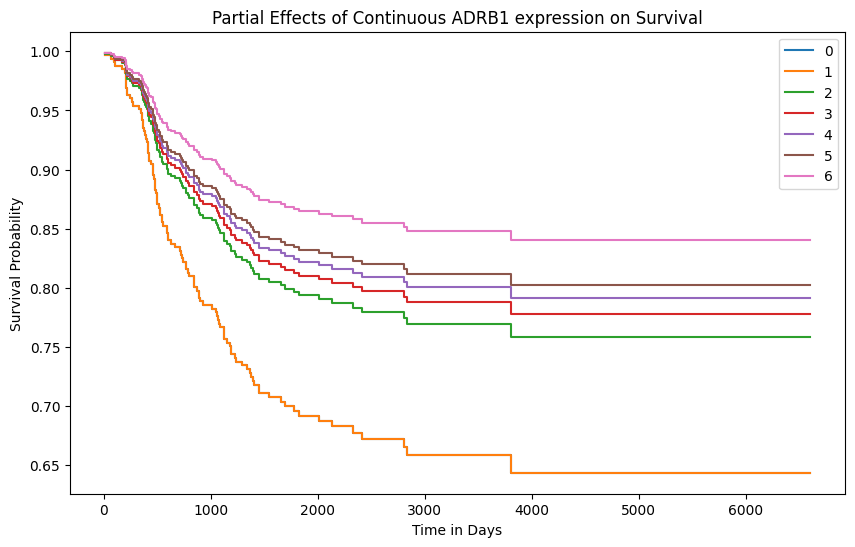

In [109]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ADRB1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='ADRB1_expression',values=[cox_data['ADRB1_expression'].min(),
                                                                         cox_data['ADRB1_expression'].quantile(0.10),
                                                                         cox_data['ADRB1_expression'].quantile(0.25),
                                                                         cox_data['ADRB1_expression'].median(),
                                                                         cox_data['ADRB1_expression'].quantile(0.75),
                                                                         cox_data['ADRB1_expression'].quantile(0.90),
                                                                         cox_data['ADRB1_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ADRB1 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## ADRB-2

In [110]:
# Extract GNAS expression levels
adrb2_expression = gene_data.loc[gene_data['Gene'] == 'ADRB2', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
adrb2_expression = adrb2_expression.reset_index()
adrb2_expression.columns = ['Sample ID', 'ADRB2_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, adrb2_expression, on='Sample ID', how='left')

# Drop samples with missing GNAS expression
data.dropna(subset=['ADRB2_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  MYCN_expression  B2M_expression  ALK_expression  \
0          24.7943  ...          18.8478         24.9077         19.7321   
1          25.2958  ...          18.2026         23.4424         19.4120   
2          24.5375  ...          23.4092         22.7246         17.6522   
3          24.6351  ...          22.2447         23.6647         19.8907   
4          24.9948  ...          23.4390         23.9312         19.8295   

   PHOX2B_expression  PRRX1_expression  CD274_expression  TGFB3_expression  \
0            21.4680           17.2395           15.0988           16.0817   
1            22.3111           17.0943           14.3239           15.3162   
2            21.7303           17.0796           11.6978           16.8757   
3            22.3325           17.0327           14.0074           17.1117   
4            21.4514           19.9534           12.5165           18.6260   

   GNAS_expression  ADRB1_expression  ADRB2_expression  
0          24.1815            0.0000           14.3614  
1          24.9106            8.1209           12.7041  
2          24.7266            8.5208            9.7105  
3          24.8053            6.8402           13.4866  
4          24.9375            0.0000           11.6505  

[5 rows x 28 columns]

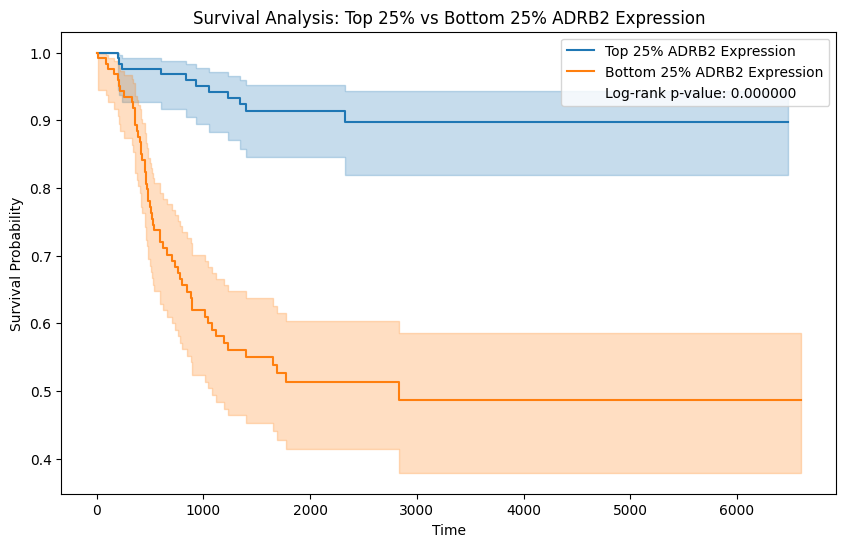

In [111]:
# Stratify samples into top 25% and bottom 25% based on ADRB1 expression
top_25 = data[data['ADRB2_expression'] >= data['ADRB2_expression'].quantile(0.75)]
bottom_25 = data[data['ADRB2_expression'] <= data['ADRB2_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% GNAS expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ADRB2 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% GNAS expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ADRB2 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ADRB2 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ADRB2 Expression', f'Bottom 25% ADRB2 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -595.77
         time fit was run = 2024-07-08 13:38:51 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ADRB2_expression -0.25      0.78      0.03           -0.30           -0.20                0.74                0.82

                  cmp to     z      p  -log2(p)
covariate                                      
ADRB2_expression    0.00 -9.74 <0.005     72.13
---
Concordance = 0.73
Partial AIC = 1193.54
log-likelihood ratio test = 61.63 on 1 df
-log2(p) of ll-ratio test = 47.78

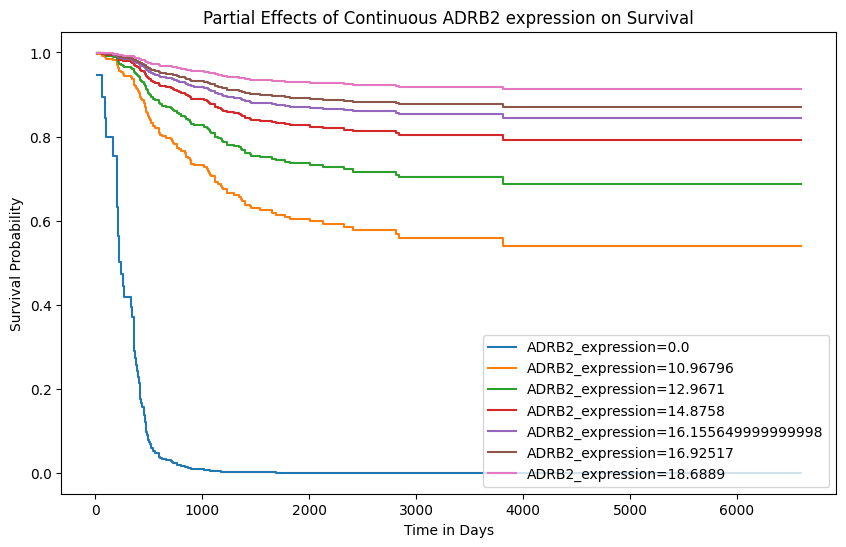

In [112]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ADRB2_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='ADRB2_expression',values=[cox_data['ADRB2_expression'].min(),
                                                                         cox_data['ADRB2_expression'].quantile(0.10),
                                                                         cox_data['ADRB2_expression'].quantile(0.25),
                                                                         cox_data['ADRB2_expression'].median(),
                                                                         cox_data['ADRB2_expression'].quantile(0.75),
                                                                         cox_data['ADRB2_expression'].quantile(0.90),
                                                                         cox_data['ADRB2_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ADRB2 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## ADRB-3

In [113]:
# Extract ADRB3 expression levels
adrb3_expression = gene_data.loc[gene_data['Gene'] == 'ADRB3', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
adrb3_expression = adrb3_expression.reset_index()
adrb3_expression.columns = ['Sample ID', 'ADRB3_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, adrb3_expression, on='Sample ID', how='left')

# Drop samples with missing ADRB3 expression
data.dropna(subset=['ADRB3_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  B2M_expression  ALK_expression  PHOX2B_expression  \
0          24.7943  ...         24.9077         19.7321            21.4680   
1          25.2958  ...         23.4424         19.4120            22.3111   
2          24.5375  ...         22.7246         17.6522            21.7303   
3          24.6351  ...         23.6647         19.8907            22.3325   
4          24.9948  ...         23.9312         19.8295            21.4514   

   PRRX1_expression  CD274_expression  TGFB3_expression  GNAS_expression  \
0           17.2395           15.0988           16.0817          24.1815   
1           17.0943           14.3239           15.3162          24.9106   
2           17.0796           11.6978           16.8757          24.7266   
3           17.0327           14.0074           17.1117          24.8053   
4           19.9534           12.5165           18.6260          24.9375   

   ADRB1_expression  ADRB2_expression  ADRB3_expression  
0            0.0000           14.3614            0.0000  
1            8.1209           12.7041            9.0355  
2            8.5208            9.7105            9.4976  
3            6.8402           13.4866            9.4368  
4            0.0000           11.6505            9.7566  

[5 rows x 29 columns]

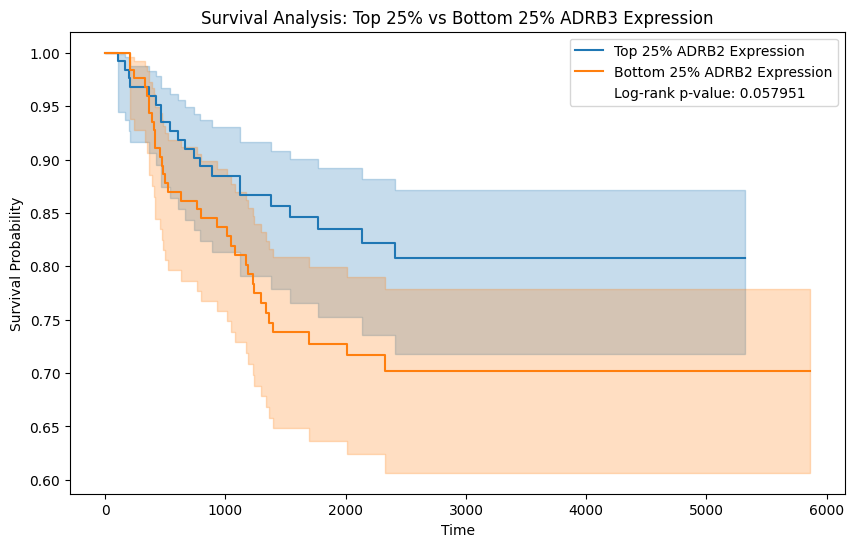

In [114]:
# Stratify samples into top 25% and bottom 25% based on ADRB3 expression
top_25 = data[data['ADRB3_expression'] >= data['ADRB3_expression'].quantile(0.75)]
bottom_25 = data[data['ADRB3_expression'] <= data['ADRB3_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% ADRB3 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ADRB3 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% ADRB3 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ADRB3 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ADRB3 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ADRB2 Expression', f'Bottom 25% ADRB2 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -625.43
         time fit was run = 2024-07-08 13:38:54 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ADRB3_expression -0.03      0.97      0.02           -0.07            0.01                0.93                1.01

                  cmp to     z    p  -log2(p)
covariate                                    
ADRB3_expression    0.00 -1.55 0.12      3.04
---
Concordance = 0.56
Partial AIC = 1252.86
log-likelihood ratio test = 2.31 on 1 df
-log2(p) of ll-ratio test = 2.96

/home/jupyter-me1117/venv/lib/python3.9/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


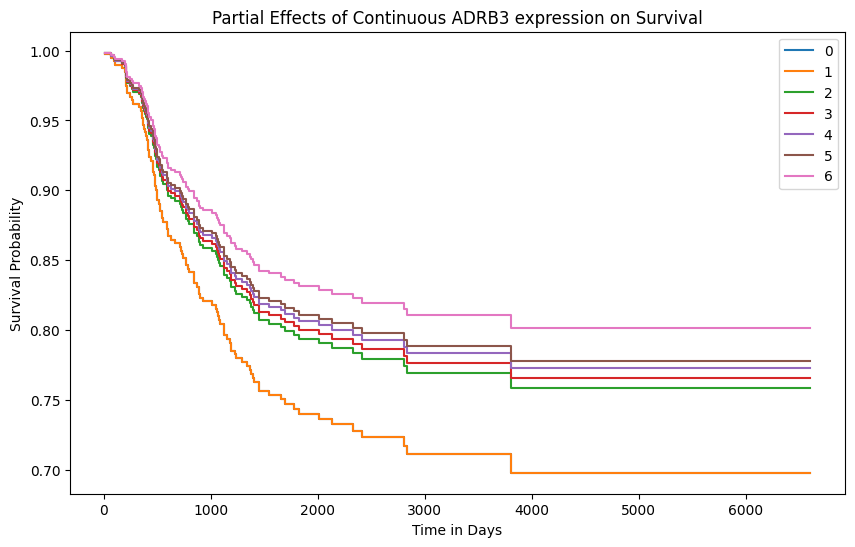

In [115]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ADRB3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='ADRB3_expression',values=[cox_data['ADRB3_expression'].min(),
                                                                         cox_data['ADRB3_expression'].quantile(0.10),
                                                                         cox_data['ADRB3_expression'].quantile(0.25),
                                                                         cox_data['ADRB3_expression'].median(),
                                                                         cox_data['ADRB3_expression'].quantile(0.75),
                                                                         cox_data['ADRB3_expression'].quantile(0.90),
                                                                         cox_data['ADRB3_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ADRB3 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

# Regression Analysis

## FOXP3 and CD4

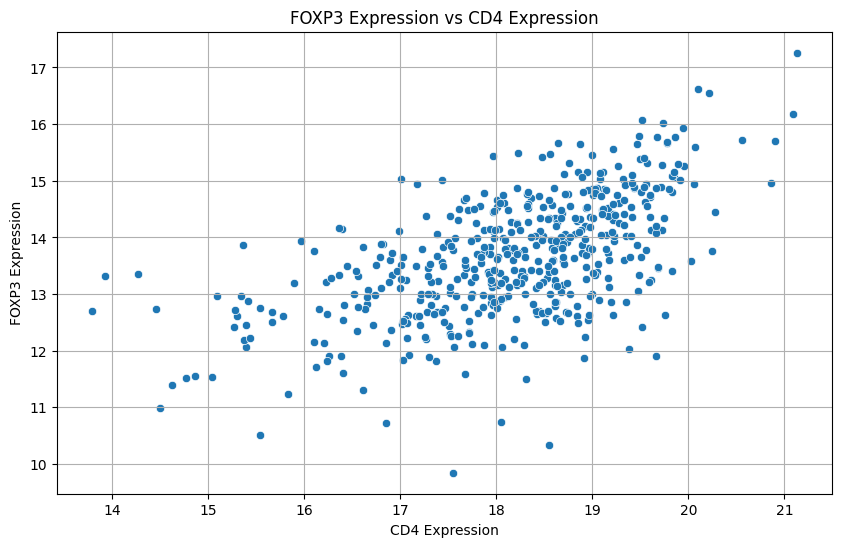

In [116]:
# Plotting FOXP3_expression vs CD4_expression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CD4_expression', y='FOXP3_expression', data=data)
plt.title('FOXP3 Expression vs CD4 Expression')
plt.xlabel('CD4 Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()


                            OLS Regression Results                            
Dep. Variable:       FOXP3_expression   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     249.4
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           8.28e-46
Time:                        09:38:57   Log-Likelihood:                -632.60
No. Observations:                 498   AIC:                             1269.
Df Residuals:                     496   BIC:                             1278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.3935      0.587      7.

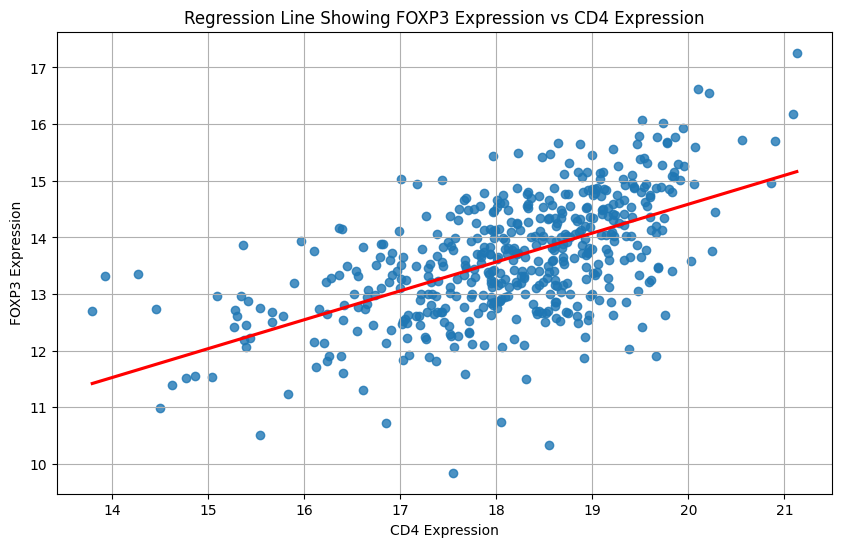

In [117]:
# Performing Regression Analysis
# Add a constant to the independent variable
X = sm.add_constant(data['CD4_expression'])
Y = data['FOXP3_expression']

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

# Optional: Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='CD4_expression', y='FOXP3_expression', data=data, ci=None, line_kws={'color':'red'})
plt.title('Regression Line Showing FOXP3 Expression vs CD4 Expression')
plt.xlabel('CD4 Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

## FOXP3 and CD3E

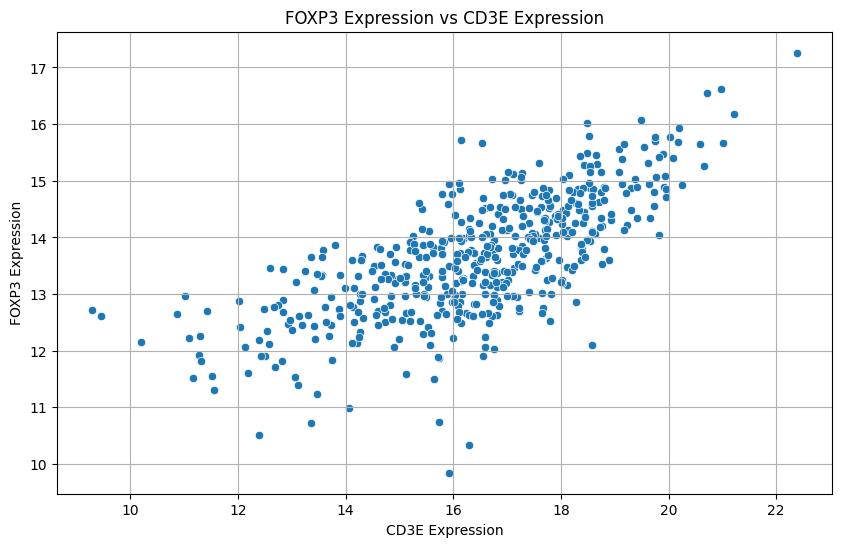

In [118]:
# Plotting FOXP3_expression vs CD3E_expression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CD3E_expression', y='FOXP3_expression', data=data)
plt.title('FOXP3 Expression vs CD3E Expression')
plt.xlabel('CD3E Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:       FOXP3_expression   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     518.0
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           4.85e-79
Time:                        09:38:59   Log-Likelihood:                -555.98
No. Observations:                 498   AIC:                             1116.
Df Residuals:                     496   BIC:                             1124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.6832      0.264     

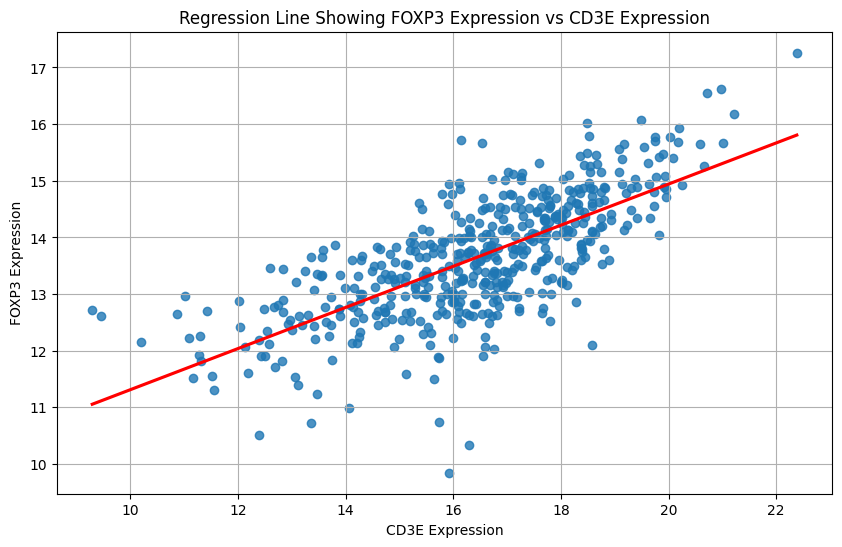

In [119]:
# Performing Regression Analysis
# Add a constant to the independent variable
X = sm.add_constant(data['CD3E_expression'])
Y = data['FOXP3_expression']

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

# Optional: Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='CD3E_expression', y='FOXP3_expression', data=data, ci=None, line_kws={'color':'red'})
plt.title('Regression Line Showing FOXP3 Expression vs CD3E Expression')
plt.xlabel('CD3E Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

## CD8B

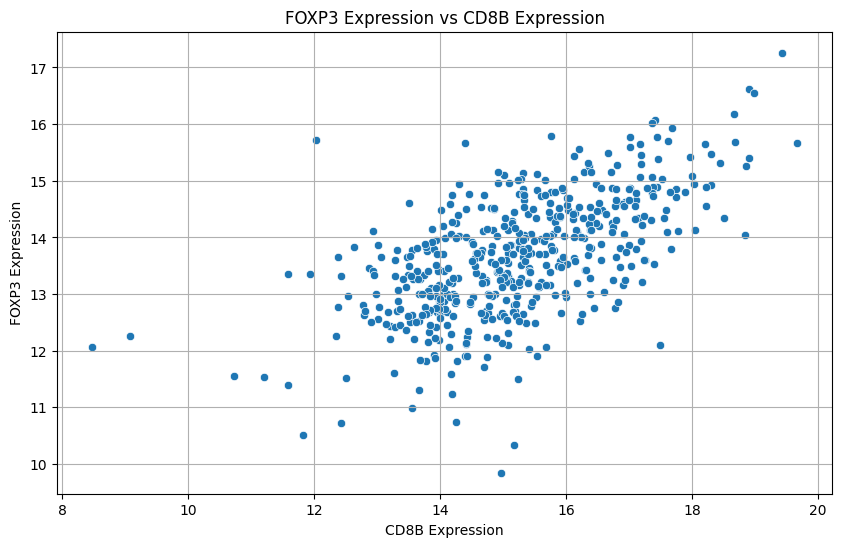

In [120]:
# Plotting FOXP3_expression vs CD3E_expression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CD8B_expression', y='FOXP3_expression', data=data)
plt.title('FOXP3 Expression vs CD8B Expression')
plt.xlabel('CD8B Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:       FOXP3_expression   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     294.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           3.61e-52
Time:                        09:39:00   Log-Likelihood:                -617.95
No. Observations:                 498   AIC:                             1240.
Df Residuals:                     496   BIC:                             1248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.2319      0.376     

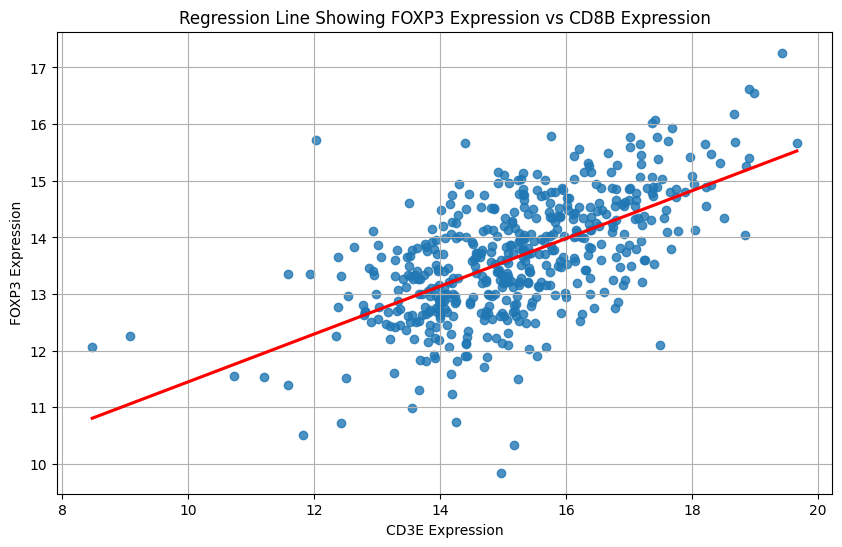

In [121]:
# Performing Regression Analysis
# Add a constant to the independent variable
X = sm.add_constant(data['CD8B_expression'])
Y = data['FOXP3_expression']

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

# Optional: Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='CD8B_expression', y='FOXP3_expression', data=data, ci=None, line_kws={'color':'red'})
plt.title('Regression Line Showing FOXP3 Expression vs CD8B Expression')
plt.xlabel('CD3E Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

## Adjusting for Confounders for FOXP3

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -600.77
         time fit was run = 2024-07-08 13:39:01 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
FOXP3_expression  0.16      1.17      0.14           -0.11            0.43                0.89                1.53
CD3E_expression  -0.10      0.90      0.08           -0.25            0.05                0.78                1.05
CD4_expression   -0.48      0.62      0.11           -0.70           -0.26                0.50                0.77

                  cmp to     z      p  -log2(p)
covariate                                      
FOXP3_expression    0.00  1.15   0.25      2.00
CD3E_expression     0.00 -1.30   0.19      2.38
CD4_expression      0.00 -4.29 <0.005     15.77
---
Concordance = 0.70
Partial AIC = 1207.55
log-likelihood ratio test = 51.62 on 3 df
-log2(p) of ll-ratio test = 34.69

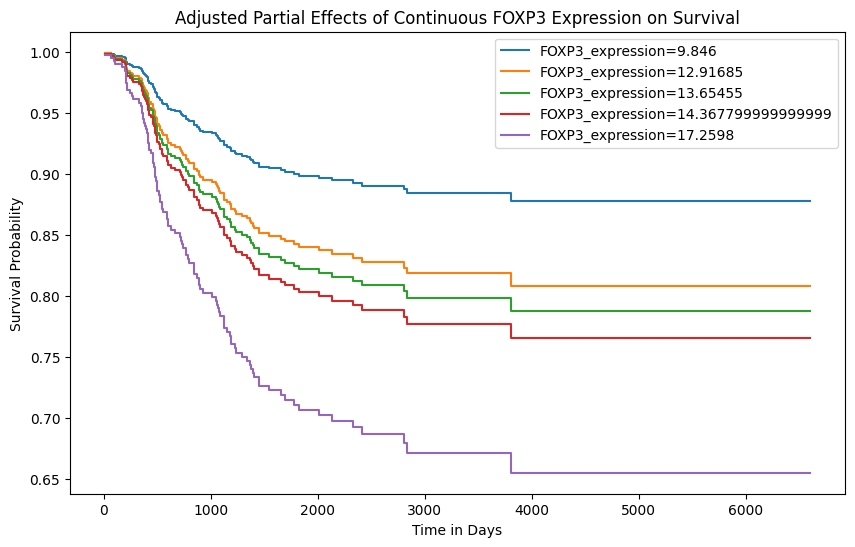

In [122]:
# Controlling for some Confounders

cox_data = data[['os days', 'os bin', 'FOXP3_expression', 'CD3E_expression', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E and CD4 expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="FOXP3_expression + CD3E_expression + CD4_expression")

# Display the results
cph.print_summary()

# Plotting the effect of FOXP3 expression on survival
# Adjust values range based on observed data distributions
values = [
    cox_data['FOXP3_expression'].min(), 
    cox_data['FOXP3_expression'].quantile(0.25), 
    cox_data['FOXP3_expression'].median(), 
    cox_data['FOXP3_expression'].quantile(0.75), 
    cox_data['FOXP3_expression'].max()
]
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(covariates='FOXP3_expression', values=values, plot_baseline=False, ax=ax)
plt.title('Adjusted Partial Effects of Continuous FOXP3 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -598.88
         time fit was run = 2024-07-08 13:39:02 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
FOXP3_expression  0.12      1.13      0.14           -0.15            0.39                0.86                1.48
CD3E_expression  -0.16      0.85      0.08           -0.32           -0.01                0.73                0.99
CD4_expression   -0.51      0.60      0.12           -0.74           -0.28                0.48                0.76
CD8B_expression   0.18      1.19      0.09           -0.00            0.36                1.00                1.43

                  cmp to     z      p  -log2(p)
covariate                                      
FOXP3_expression    0.00  0.87   0.38      1.38
CD3E_expression     0.00 -2.07   0.04      4.72
CD4_expression      0.00 -4.36 <0.005     16.22
CD8B_expression     0.00  1.93   0.05      4.22
---
Concordance = 0.71
Partial AIC = 1205.76
log-likelihood ratio test = 55.40 on 4 df
-log2(p) of ll-ratio test = 35.12

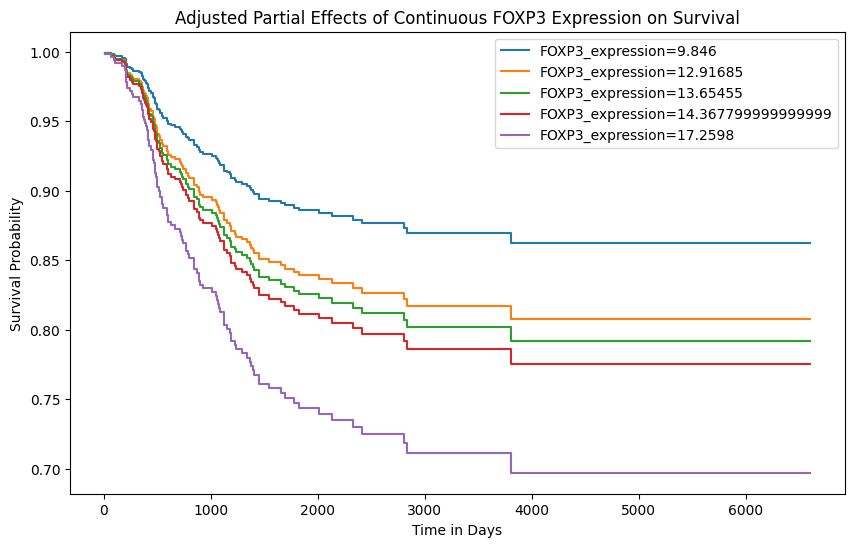

In [123]:
# Controlling for some Confounders

cox_data = data[['os days', 'os bin', 'FOXP3_expression', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E and CD4 expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="FOXP3_expression + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of FOXP3 expression on survival
# Adjust values range based on observed data distributions
values = [
    cox_data['FOXP3_expression'].min(), 
    cox_data['FOXP3_expression'].quantile(0.25), 
    cox_data['FOXP3_expression'].median(), 
    cox_data['FOXP3_expression'].quantile(0.75), 
    cox_data['FOXP3_expression'].max()
]
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(covariates='FOXP3_expression', values=values, plot_baseline=False, ax=ax)
plt.title('Adjusted Partial Effects of Continuous FOXP3 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()


## Adjusting for Confounders for TGF-Beta

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -598.96
         time fit was run = 2024-07-08 13:39:04 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
tgfb_score       0.28      1.32      0.35           -0.41            0.96                0.66                2.62
CD3E_expression -0.14      0.87      0.08           -0.29            0.01                0.75                1.01
CD4_expression  -0.55      0.57      0.14           -0.83           -0.28                0.44                0.75
CD8B_expression  0.18      1.20      0.09           -0.00            0.36                1.00                1.43

                 cmp to     z      p  -log2(p)
covariate                                     
tgfb_score         0.00  0.79   0.43      1.21
CD3E_expression    0.00 -1.81   0.07      3.83
CD4_expression     0.00 -3.99 <0.005     13.91
CD8B_expression    0.00  1.93   0.05      4.22
---
Concordance = 0.71
Partial AIC = 1205.91
log-likelihood ratio test = 55.25 on 4 df
-log2(p) of ll-ratio test = 35.02

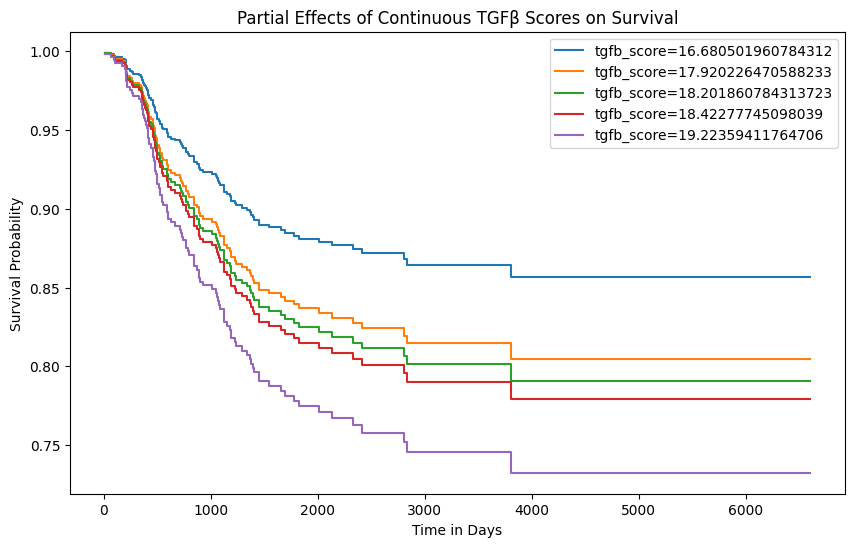

In [124]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'tgfb_score', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="tgfb_score + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='tgfb_score', values=[cox_data['tgfb_score'].min(), cox_data['tgfb_score'].quantile(0.25), cox_data['tgfb_score'].median(), cox_data['tgfb_score'].quantile(0.75), cox_data['tgfb_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -595.45
         time fit was run = 2024-07-08 13:39:06 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
TGFB1_expression  0.41      1.51      0.14            0.13            0.69                1.14                1.99
CD3E_expression  -0.15      0.86      0.08           -0.31           -0.00                0.74                1.00
CD4_expression   -0.73      0.48      0.14           -1.01           -0.45                0.36                0.64
CD8B_expression   0.22      1.24      0.09            0.03            0.40                1.03                1.49

                  cmp to     z      p  -log2(p)
covariate                                      
TGFB1_expression    0.00  2.88 <0.005      7.97
CD3E_expression     0.00 -2.01   0.04      4.48
CD4_expression      0.00 -5.09 <0.005     21.45
CD8B_expression     0.00  2.33   0.02      5.66
---
Concordance = 0.73
Partial AIC = 1198.90
log-likelihood ratio test = 62.26 on 4 df
-log2(p) of ll-ratio test = 39.91

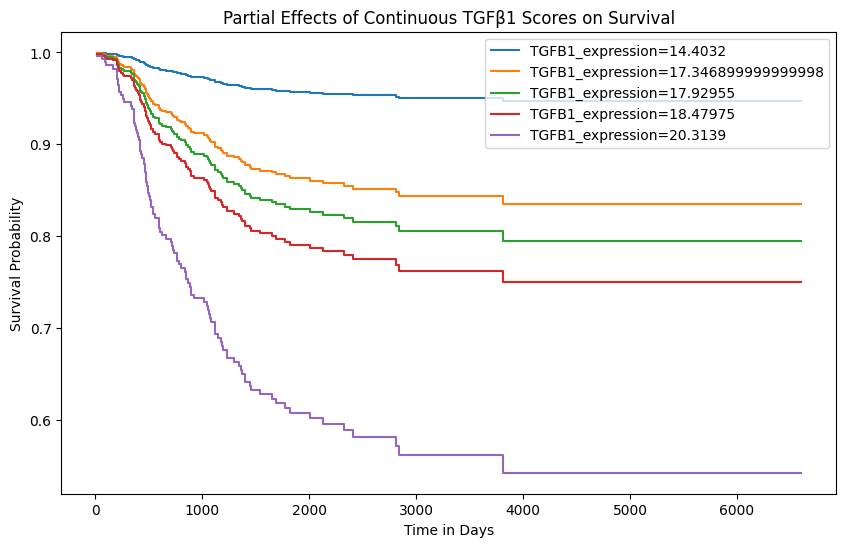

In [125]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB1_expression', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="TGFB1_expression + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ1 scores on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB1_expression', values=[cox_data['TGFB1_expression'].min(), cox_data['TGFB1_expression'].quantile(0.25), cox_data['TGFB1_expression'].median(), cox_data['TGFB1_expression'].quantile(0.75), cox_data['TGFB1_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ1 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -596.53
         time fit was run = 2024-07-08 13:39:07 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
TGFB2_expression -0.18      0.83      0.08           -0.34           -0.03                0.71                0.97
CD3E_expression  -0.21      0.81      0.08           -0.37           -0.05                0.69                0.96
CD4_expression   -0.44      0.64      0.12           -0.67           -0.21                0.51                0.81
CD8B_expression   0.23      1.26      0.10            0.04            0.42                1.04                1.52

                  cmp to     z      p  -log2(p)
covariate                                      
TGFB2_expression    0.00 -2.40   0.02      5.93
CD3E_expression     0.00 -2.51   0.01      6.38
CD4_expression      0.00 -3.71 <0.005     12.21
CD8B_expression     0.00  2.37   0.02      5.80
---
Concordance = 0.71
Partial AIC = 1201.06
log-likelihood ratio test = 60.11 on 4 df
-log2(p) of ll-ratio test = 38.40

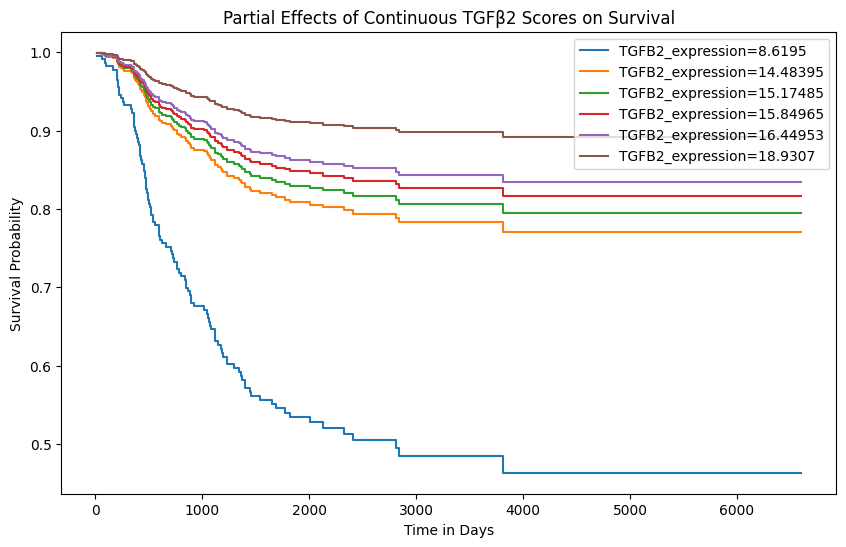

In [126]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB2_expression', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="TGFB2_expression + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ1 scores on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB2_expression', values=[cox_data['TGFB2_expression'].min(), cox_data['TGFB2_expression'].quantile(0.25), cox_data['TGFB2_expression'].median(), cox_data['TGFB2_expression'].quantile(0.75), cox_data['TGFB2_expression'].quantile(0.90), cox_data['TGFB2_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ2 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -594.50
         time fit was run = 2024-07-08 13:39:09 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
TGFB3_expression  0.33      1.39      0.11            0.12            0.54                1.13                1.71
CD3E_expression  -0.13      0.88      0.08           -0.28            0.02                0.75                1.02
CD4_expression   -0.64      0.53      0.13           -0.89           -0.39                0.41                0.68
CD8B_expression   0.20      1.22      0.09            0.01            0.38                1.01                1.47

                  cmp to     z      p  -log2(p)
covariate                                      
TGFB3_expression    0.00  3.12 <0.005      9.10
CD3E_expression     0.00 -1.68   0.09      3.43
CD4_expression      0.00 -5.07 <0.005     21.29
CD8B_expression     0.00  2.08   0.04      4.75
---
Concordance = 0.74
Partial AIC = 1197.00
log-likelihood ratio test = 64.16 on 4 df
-log2(p) of ll-ratio test = 41.23

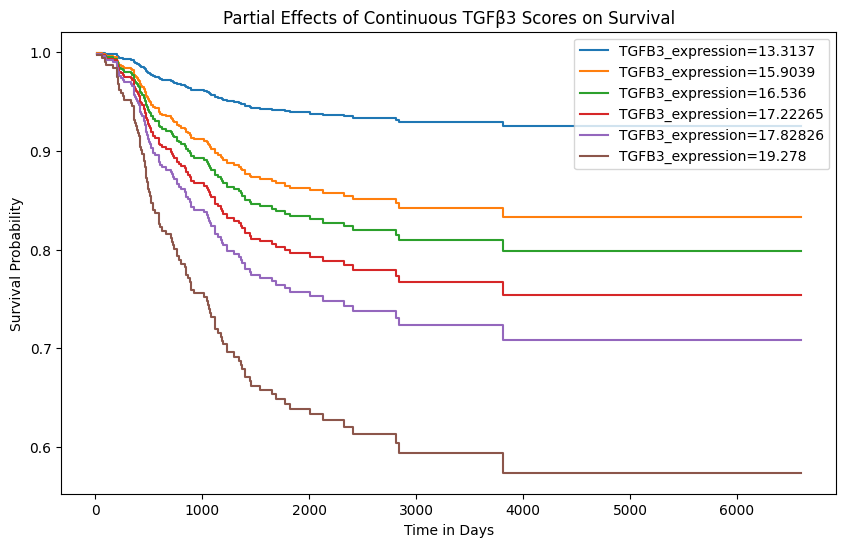

In [127]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB3_expression', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="TGFB3_expression + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ1 scores on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB3_expression', values=[cox_data['TGFB3_expression'].min(), cox_data['TGFB3_expression'].quantile(0.25), cox_data['TGFB3_expression'].median(), cox_data['TGFB3_expression'].quantile(0.75), cox_data['TGFB3_expression'].quantile(0.90), cox_data['TGFB3_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ3 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## Controlling for confounding variables for CD8B

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -599.26
         time fit was run = 2024-07-08 13:39:11 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
CD3E_expression -0.14      0.87      0.08           -0.29            0.01                0.75                1.01
CD4_expression  -0.50      0.61      0.12           -0.72           -0.27                0.49                0.77
CD8B_expression  0.19      1.21      0.09            0.01            0.37                1.01                1.45

                 cmp to     z      p  -log2(p)
covariate                                     
CD3E_expression    0.00 -1.87   0.06      4.03
CD4_expression     0.00 -4.27 <0.005     15.62
CD8B_expression    0.00  2.08   0.04      4.73
---
Concordance = 0.71
Partial AIC = 1204.53
log-likelihood ratio test = 54.64 on 3 df
-log2(p) of ll-ratio test = 36.83

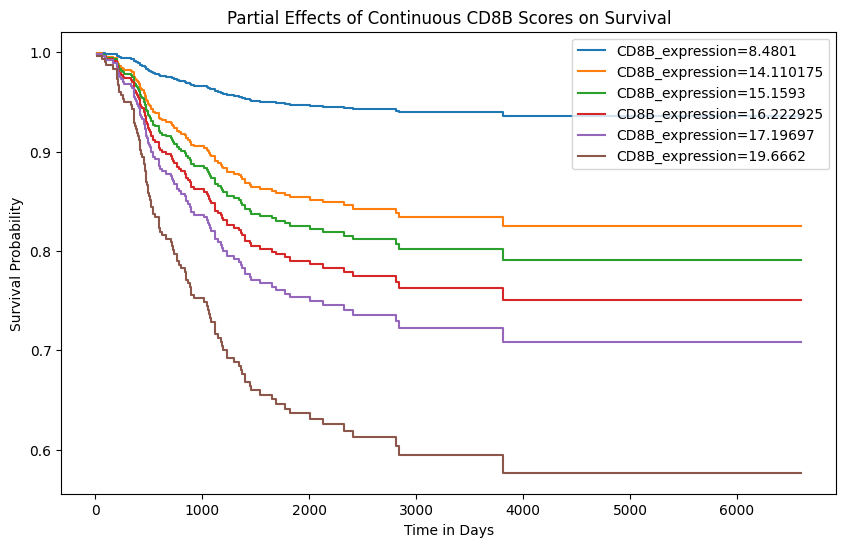

In [128]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD8B_expression', 'CD3E_expression', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ1 scores on survival
cph.plot_partial_effects_on_outcome(covariates='CD8B_expression', values=[cox_data['CD8B_expression'].min(), cox_data['CD8B_expression'].quantile(0.25), cox_data['CD8B_expression'].median(), cox_data['CD8B_expression'].quantile(0.75), cox_data['CD8B_expression'].quantile(0.90), cox_data['CD8B_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous CD8B Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

# Kegg TCR

## CD8 TCR Pathway

In [129]:
# Read the gene list from the file
with open("dataset/PID_CD8_TCR_PATHWAY.v2023.2.Hs.tsv", 'r') as file:
    gene_list = file.read().splitlines()

In [130]:
gene_list

['STANDARD_NAME\tPID_CD8_TCR_PATHWAY',
 'SYSTEMATIC_NAME\tM88',
 'COLLECTION\tC2:CP:PID',
 'MSIGDB_URL\thttps://www.gsea-msigdb.org/gsea/msigdb/human/geneset/PID_CD8_TCR_PATHWAY',
 'NAMESPACE\tHuman_UniProt_ID',
 'DESCRIPTION_BRIEF\tTCR signaling in na&#xef;ve CD8+ T cells',
 'DESCRIPTION_FULL\t',
 'PMID\t18832364',
 'GEOID\t',
 'AUTHORS\tSchaefer CF,Anthony K,Krupa S,Buchoff J,Day M,Hannay T,Buetow KH',
 'CONTRIBUTOR\tPathway Interaction Database',
 'CONTRIBUTOR_ORG\tNCI, NIH and Nature Publishing Group',
 'EXACT_SOURCE\t',
 'FILTERED_BY_SIMILARITY\t',
 'EXTERNAL_NAMES_FOR_SIMILAR_TERMS\t',
 'EXTERNAL_DETAILS_URL\t',
 'SOURCE_MEMBERS\tO14920,O15111,O15530,O43561,O75791,O95267,O95999,P01111,P01112,P01116,P01732,P04234,P04439,P05771,P06239,P06241,P07766,P08575,P09693,P10747,P10966,P14222,P15498,P17252,P19174,P20963,P22681,P29350,P29353,P31749,P33681,P41240,P41279,P42081,P43403,P61769,P62834,P62993,Q02156,Q04759,Q07889,Q13094,Q13586,Q7LDG7,Q8WWW0,Q96D31,Q99558,Q9BXL7,Q9H1D0,Q9NWQ8,Q9UDY8

In [131]:
# Read the gene list from the file
with open("dataset/PID_CD8_TCR_PATHWAY.v2023.2.Hs.tsv", 'r') as file:
    gene_list = file.read().splitlines()

# Find the line that starts with "GENE_SYMBOLS"
gene_symbols_line = next(line for line in gene_list if line.startswith('GENE_SYMBOLS'))

# Extract the gene symbols list
gene_list = gene_symbols_line.split('\t')[1].split(',')

# Print the extracted gene symbols list
print(gene_list)


['IKBKB', 'CHUK', 'PDPK1', 'LAT', 'GRAP2', 'RASGRP1', 'BCL10', 'NRAS', 'HRAS', 'KRAS', 'CD8A', 'CD3D', 'HLA-A', 'PRKCB', 'LCK', 'FYN', 'CD3E', 'PTPRC', 'CD3G', 'CD28', 'CD8B', 'PRF1', 'VAV1', 'PRKCA', 'PLCG1', 'CD247', 'CBL', 'PTPN6', 'SHC1', 'AKT1', 'CD80', 'CSK', 'MAP3K8', 'CD86', 'ZAP70', 'B2M', 'RAP1A', 'GRB2', 'PRKCE', 'PRKCQ', 'SOS1', 'LCP2', 'STIM1', 'RASGRP2', 'RASSF5', 'ORAI1', 'MAP3K14', 'CARD11', 'TRPV6', 'PAG1', 'MALT1', 'TRAF6', 'IKBKG']


In [132]:
# List of CD8 TCR pathway genes
tcr_genes = gene_list

# Calculate Tgfb signature scores for each sample
tcr_scores = gene_data[gene_data['Gene'].isin(tcr_genes)].iloc[:, 8:].mean(axis=0)
tcr_scores.name = 'tcr_scores'

# Combine tgfb scores with metadata
data['tcr_scores'] = data['Sample ID'].map(tcr_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['tcr_scores'], inplace=True)

In [133]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  ALK_expression  PHOX2B_expression  \
0            24.7943  ...         19.7321            21.4680   
1            25.2958  ...         19.4120            22.3111   
2            24.5375  ...         17.6522            21.7303   
3            24.6351  ...         19.8907            22.3325   
4            24.9948  ...         19.8295            21.4514   
..               ...  ...             ...                ...   
493          25.4461  ...         18.4212            21.3492   
494          25.1602  ...         18.1339            21.0902   
495          25.1211  ...         19.6243            21.6938   
496          24.7802  ...         19.6343            21.9821   
497          25.0471  ...         18.5772            21.2803   

     PRRX1_expression  CD274_expression  TGFB3_expression  GNAS_expression  \
0             17.2395           15.0988           16.0817          24.1815   
1             17.0943           14.3239           15.3162          24.9106   
2             17.0796           11.6978           16.8757          24.7266   
3             17.0327           14.0074           17.1117          24.8053   
4             19.9534           12.5165           18.6260          24.9375   
..                ...               ...               ...              ...   
493           18.8878           13.8162           17.0877          24.8656   
494           18.4048           15.0540           16.5812          25.3897   
495           17.1595           12.3610           17.0788          25.6038   
496           17.5708           14.7716           16.5166          24.9727   
497           19.2442           14.8465           17.3601          24.2099   

     ADRB1_expression  ADRB2_expression  ADRB3_expression  tcr_scores  
0              0.0000           14.3614            0.0000   18.351773  
1              8.1209           12.7041            9.0355   17.641285  
2              8.5208            9.7105            9.4976   15.599100  
3              6.8402           13.4866            9.4368   17.009327  
4              0.0000           11.6505            9.7566   16.168304  
..                ...               ...               ...         ...  
493            9.3716           15.3519           12.0438   17.259510  
494            9.2485           16.1540           10.8068   17.690890  
495   

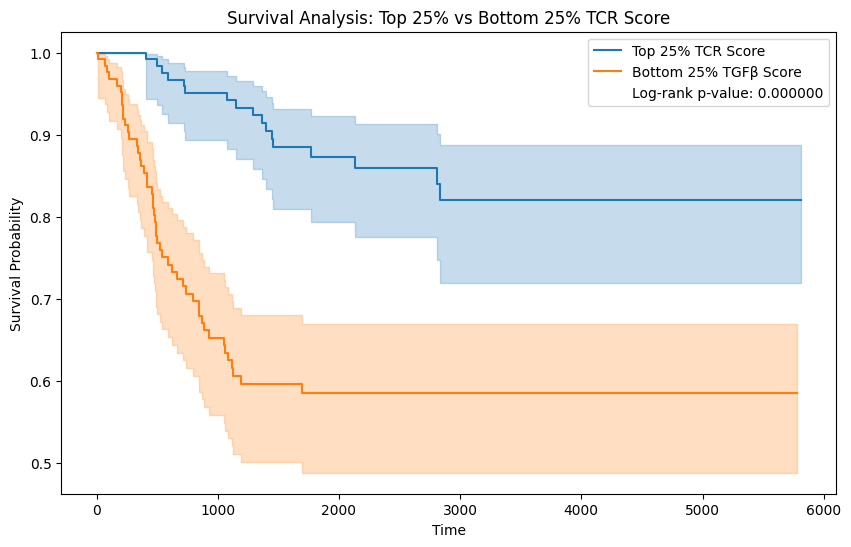

In [134]:
# Stratify samples into top 25% and bottom 25% based on tgfb_score
top_25 = data[data['tcr_scores'] >= data['tcr_scores'].quantile(0.75)]
bottom_25 = data[data['tcr_scores'] <= data['tcr_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFβ score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TCR Score')
ax = kmf.plot_survival_function()

# Bottom 25% TGFβ score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TCR Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TCR Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TCR Score', f'Bottom 25% TGFβ Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -604.05
         time fit was run = 2024-07-08 13:39:14 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
tcr_scores -0.90      0.41      0.13           -1.15           -0.65                0.32                0.52

            cmp to     z      p  -log2(p)
covariate                                
tcr_scores    0.00 -7.11 <0.005     39.67
---
Concordance = 0.69
Partial AIC = 1210.10
log-likelihood ratio test = 45.07 on 1 df
-log2(p) of ll-ratio test = 35.61

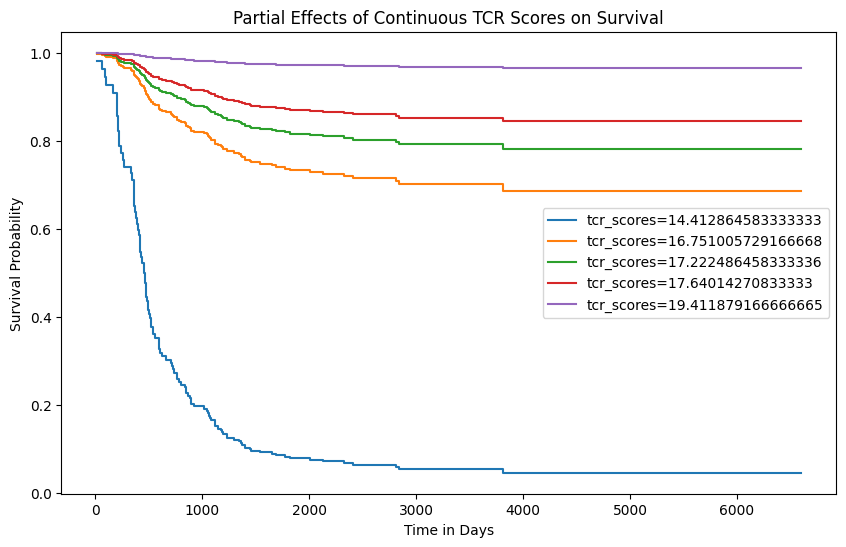

In [135]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'tcr_scores']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of TCR scores on survival
cph.plot_partial_effects_on_outcome(covariates='tcr_scores', values=[cox_data['tcr_scores'].min(), cox_data['tcr_scores'].quantile(0.25), cox_data['tcr_scores'].median(), cox_data['tcr_scores'].quantile(0.75), cox_data['tcr_scores'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TCR Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## REACTOME TCR Signaling

In [136]:
# Read the gene list from the file
with open("dataset/REACTOME_TCR_SIGNALING.v2023.2.Hs.tsv", 'r') as file:
    gene_list = file.read().splitlines()

# Find the line that starts with "GENE_SYMBOLS"
gene_symbols_line = next(line for line in gene_list if line.startswith('GENE_SYMBOLS'))

# Extract the gene symbols list
gene_list = gene_symbols_line.split('\t')[1].split(',')

# Print the extracted gene symbols list
print(gene_list)

['PSMB1', 'CD4', 'PSMC4', 'WAS', 'PSMA4', 'LCP2', 'PIK3CB', 'CUL1', 'TAB2', 'PRKCQ', 'PSME4', 'UBE2D1', 'FBXW11', 'PAG1', 'PAK3', 'PTPRC', 'FYB1', 'PSMC5', 'PSME1', 'PSMD5', 'PSMD8', 'CDC34', 'GRAP2', 'PSMC6', 'PSMA3', 'PSMC1', 'PSMB5', 'PSMA6', 'NFKBIA', 'PSME2', 'PSMA7', 'PSMD10', 'PSMD7', 'CSK', 'RIPK2', 'IKBKB', 'PIK3R2', 'PSMA2', 'PSMD3', 'PSMD11', 'NFKB1', 'PSMD9', 'ITK', 'SKP1', 'ZAP70', 'PSMD14', 'PIK3CA', 'PLCG1', 'VASP', 'PSMF1', 'PSMB2', 'SEM1', 'PSMA1', 'PSME3', 'UBE2D2', 'PTPN22', 'CD101', 'MAP3K7', 'PSMB7', 'PDPK1', 'PSMB6', 'BCL10', 'PSMA5', 'RPS27A', 'PIK3R1', 'PTPRJ', 'PAK1', 'UBC', 'ENAH', 'PSMA8', 'NCK1', 'PSMD4', 'PSMB4', 'CD3G', 'PSMC2', 'TRAT1', 'PSMD6', 'PSMC3', 'BTRC', 'CD3D', 'HLA-DPA1', 'INPP5D', 'UBB', 'PTEN', 'MALT1', 'RELA', 'PSMD1', 'TRAF6', 'PSMD2', 'UBE2N', 'PAK2', 'LCK', 'PSMD13', 'HLA-DRB3', 'HLA-DRB1', 'EVL', 'HLA-DQB2', 'HLA-DQA1', 'PSMD12', 'PLCG2', 'CARD11', 'HLA-DRB5', 'CD247', 'CD3E', 'PSMB8', 'HLA-DRA', 'PSMB10', 'HLA-DPA1', 'PSMB8', 'HLA-DQA2',

In [137]:
# List of CD8 TCR pathway genes
tcr2_genes = gene_list

# Calculate Tgfb signature scores for each sample
tcr2_genes = gene_data[gene_data['Gene'].isin(tcr2_genes)].iloc[:, 8:].mean(axis=0)
tcr2_genes.name = 'tcr2_scores'

# Combine tgfb scores with metadata
data['tcr2_genes'] = data['Sample ID'].map(tcr2_genes)

# Drop samples with missing tgfb scores
data.dropna(subset=['tcr2_genes'], inplace=True)

In [138]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  PHOX2B_expression  PRRX1_expression  \
0            24.7943  ...            21.4680           17.2395   
1            25.2958  ...            22.3111           17.0943   
2            24.5375  ...            21.7303           17.0796   
3            24.6351  ...            22.3325           17.0327   
4            24.9948  ...            21.4514           19.9534   
..               ...  ...                ...               ...   
493          25.4461  ...            21.3492           18.8878   
494          25.1602  ...            21.0902           18.4048   
495          25.1211  ...            21.6938           17.1595   
496          24.7802  ...            21.9821           17.5708   
497          25.0471  ...            21.2803           19.2442   

     CD274_expression  TGFB3_expression  GNAS_expression  ADRB1_expression  \
0             15.0988           16.0817          24.1815            0.0000   
1             14.3239           15.3162          24.9106            8.1209   
2             11.6978           16.8757          24.7266            8.5208   
3             14.0074           17.1117          24.8053            6.8402   
4             12.5165           18.6260          24.9375            0.0000   
..                ...               ...              ...               ...   
493           13.8162           17.0877          24.8656            9.3716   
494           15.0540           16.5812          25.3897            9.2485   
495           12.3610           17.0788          25.6038            7.8735   
496           14.7716           16.5166          24.9727            6.8155   
497           14.8465           17.3601          24.2099            9.6810   

     ADRB2_expression  ADRB3_expression  tcr_scores  tcr2_genes  
0             14.3614            0.0000   18.351773   18.792294  
1             12.7041            9.0355   17.641285   18.460935  
2              9.7105            9.4976   15.599100   17.180075  
3             13.4866            9.4368   17.009327   18.224309  
4             11.6505            9.7566   16.168304   17.749510  
..                ...               ...         ...         ...  
493           15.3519           12.0438   17.259510   18.457485  
494           16.1540           10.8068   17.690890   18.724011  
495           12.8784            9.4

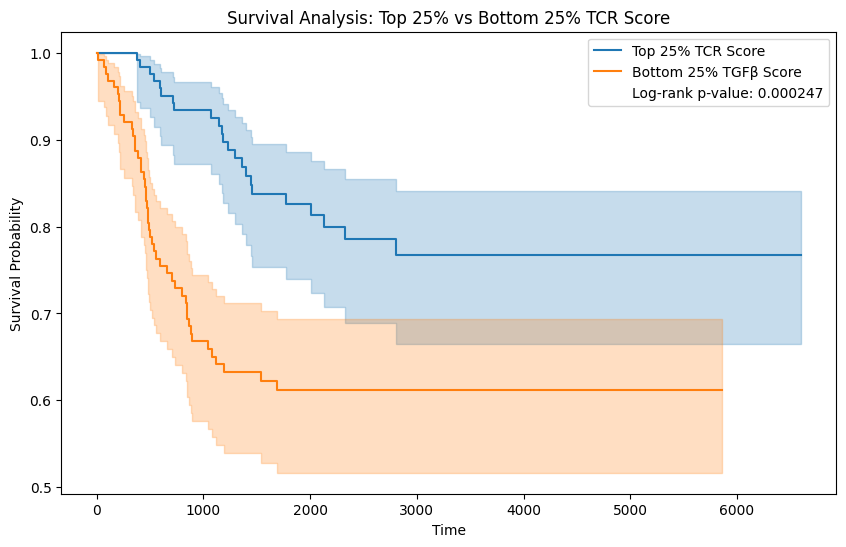

In [139]:
# Stratify samples into top 25% and bottom 25% based on tgfb_score
top_25 = data[data['tcr2_genes'] >= data['tcr2_genes'].quantile(0.75)]
bottom_25 = data[data['tcr2_genes'] <= data['tcr2_genes'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFβ score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TCR Score')
ax = kmf.plot_survival_function()

# Bottom 25% TGFβ score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TCR Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TCR Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TCR Score', f'Bottom 25% TGFβ Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -612.92
         time fit was run = 2024-07-08 13:39:17 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
tcr2_genes -1.15      0.32      0.21           -1.57           -0.73                0.21                0.48

            cmp to     z      p  -log2(p)
covariate                                
tcr2_genes    0.00 -5.34 <0.005     23.38
---
Concordance = 0.64
Partial AIC = 1227.85
log-likelihood ratio test = 27.32 on 1 df
-log2(p) of ll-ratio test = 22.47

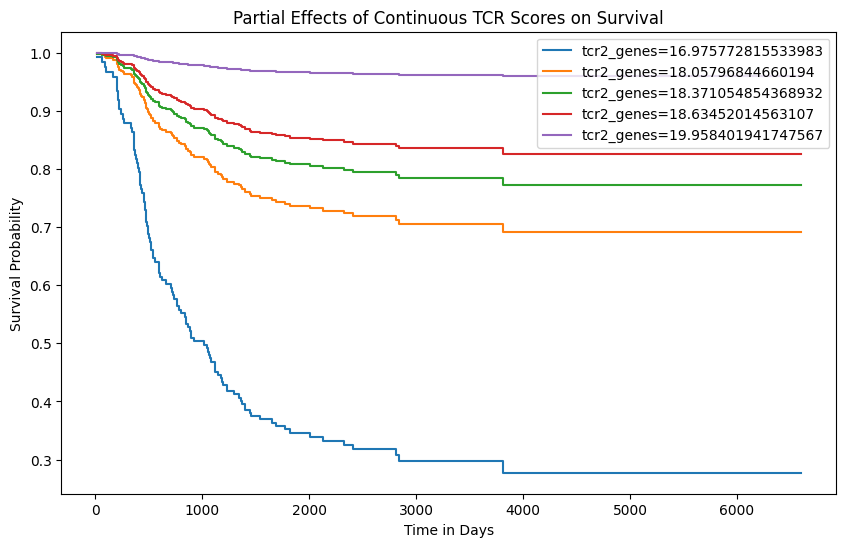

In [140]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'tcr2_genes']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of TCR scores on survival
cph.plot_partial_effects_on_outcome(covariates='tcr2_genes', values=[cox_data['tcr2_genes'].min(), cox_data['tcr2_genes'].quantile(0.25), cox_data['tcr2_genes'].median(), cox_data['tcr2_genes'].quantile(0.75), cox_data['tcr2_genes'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TCR Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## Ctrl. CD8B --> TCF7

In [141]:
# Extract TCF7 expression levels
tcf7_expression = gene_data.loc[gene_data['Gene'] == 'TCF7', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tcf7_expression = tcf7_expression.reset_index()
tcf7_expression.columns = ['Sample ID', 'TCF7_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tcf7_expression, on='Sample ID', how='left')

# Drop samples with missing TCF7 expression
data.dropna(subset=['TCF7_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  PRRX1_expression  CD274_expression  TGFB3_expression  \
0          24.7943  ...           17.2395           15.0988           16.0817   
1          25.2958  ...           17.0943           14.3239           15.3162   
2          24.5375  ...           17.0796           11.6978           16.8757   
3          24.6351  ...           17.0327           14.0074           17.1117   
4          24.9948  ...           19.9534           12.5165           18.6260   

   GNAS_expression  ADRB1_expression  ADRB2_expression  ADRB3_expression  \
0          24.1815            0.0000           14.3614            0.0000   
1          24.9106            8.1209           12.7041            9.0355   
2          24.7266            8.5208            9.7105            9.4976   
3          24.8053            6.8402           13.4866            9.4368   
4          24.9375            0.0000           11.6505            9.7566   

   tcr_scores  tcr2_genes  TCF7_expression  
0   18.351773   18.792294          19.4520  
1   17.641285   18.460935          17.2688  
2   15.599100   17.180075          14.0032  
3   17.009327   18.224309          16.2404  
4   16.168304   17.749510          15.4910  

[5 rows x 32 columns]

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.41
         time fit was run = 2024-07-08 13:39:19 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
TCF7_expression -0.38      0.69      0.09           -0.54           -0.21                0.58                0.81

                 cmp to     z      p  -log2(p)
covariate                                     
TCF7_expression    0.00 -4.43 <0.005     16.68
---
Concordance = 0.64
Partial AIC = 1234.81
log-likelihood ratio test = 20.35 on 1 df
-log2(p) of ll-ratio test = 17.25

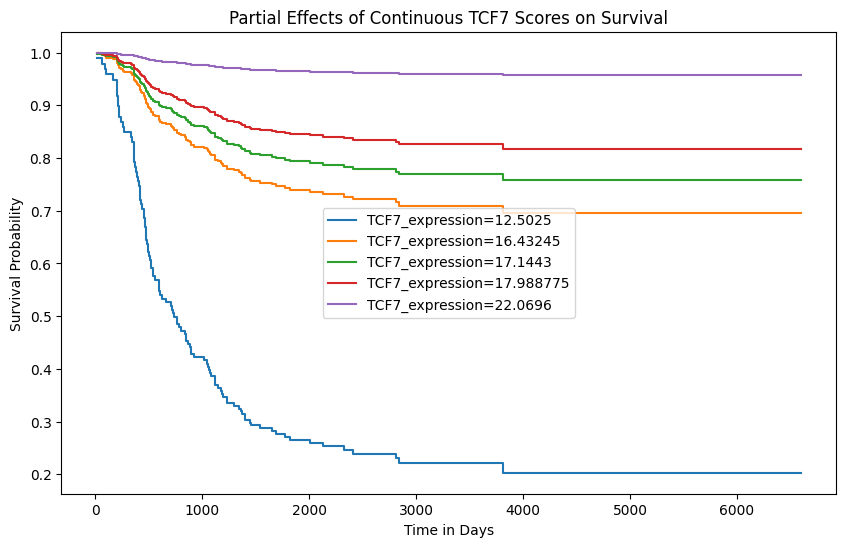

In [142]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TCF7_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="TCF7_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='TCF7_expression', values=[cox_data['TCF7_expression'].min(), cox_data['TCF7_expression'].quantile(0.25), cox_data['TCF7_expression'].median(), cox_data['TCF7_expression'].quantile(0.75), cox_data['TCF7_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TCF7 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.40
         time fit was run = 2024-07-08 13:39:20 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
TCF7_expression -0.38      0.68      0.11           -0.60           -0.16                0.55                0.85
CD8B_expression  0.00      1.00      0.09           -0.18            0.19                0.84                1.21

                 cmp to     z      p  -log2(p)
covariate                                     
TCF7_expression    0.00 -3.36 <0.005     10.34
CD8B_expression    0.00  0.04   0.97      0.05
---
Concordance = 0.64
Partial AIC = 1236.81
log-likelihood ratio test = 20.36 on 2 df
-log2(p) of ll-ratio test = 14.68

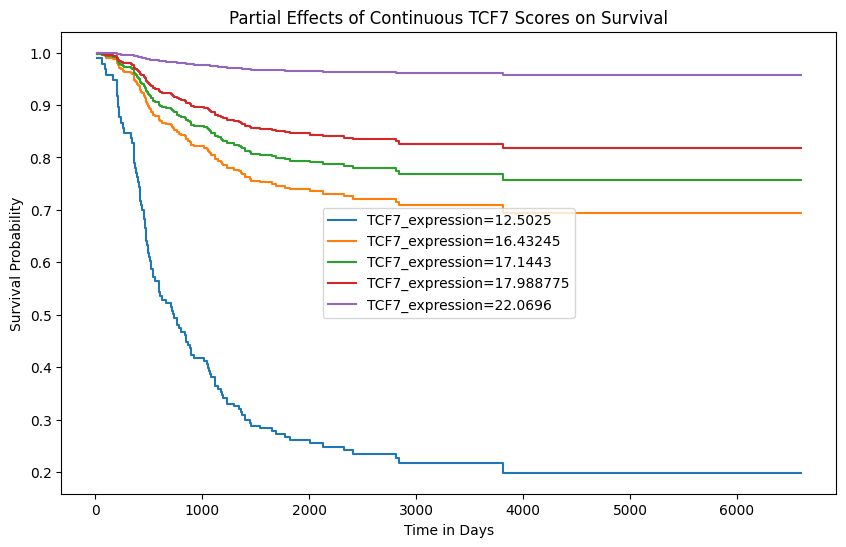

In [143]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TCF7_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="TCF7_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='TCF7_expression', values=[cox_data['TCF7_expression'].min(), cox_data['TCF7_expression'].quantile(0.25), cox_data['TCF7_expression'].median(), cox_data['TCF7_expression'].quantile(0.75), cox_data['TCF7_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TCF7 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -599.26
         time fit was run = 2024-07-08 13:39:22 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
TCF7_expression  0.02      1.02      0.14           -0.26            0.29                0.77                1.34
CD8B_expression  0.19      1.21      0.09            0.01            0.37                1.01                1.45
CD3E_expression -0.15      0.86      0.09           -0.33            0.03                0.72                1.03
CD4_expression  -0.50      0.61      0.12           -0.72           -0.27                0.48                0.76

                 cmp to     z      p  -log2(p)
covariate                                     
TCF7_expression    0.00  0.12   0.90      0.15
CD8B_expression    0.00  2.02   0.04      4.54
CD3E_expression    0.00 -1.60   0.11      3.19
CD4_expression     0.00 -4.27 <0.005     15.61
---
Concordance = 0.71
Partial AIC = 1206.51
log-likelihood ratio test = 54.65 on 4 df
-log2(p) of ll-ratio test = 34.60

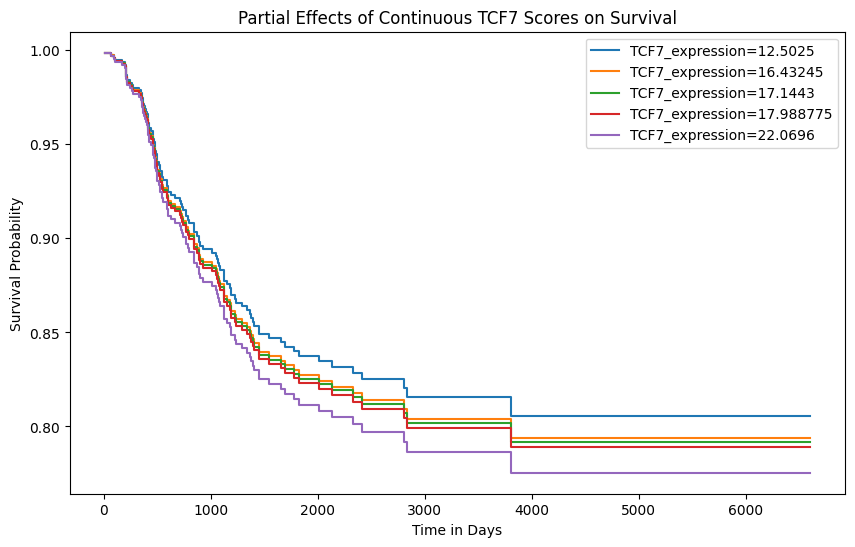

In [144]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TCF7_expression', 'CD8B_expression', 'CD3E_expression', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="TCF7_expression + CD8B_expression + CD3E_expression + CD4_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='TCF7_expression', values=[cox_data['TCF7_expression'].min(), cox_data['TCF7_expression'].quantile(0.25), cox_data['TCF7_expression'].median(), cox_data['TCF7_expression'].quantile(0.75), cox_data['TCF7_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TCF7 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## Ctrl. CD8B --> GZMB

In [145]:
# Extract GZMB expression levels
gzmb_expression = gene_data.loc[gene_data['Gene'] == 'GZMB', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
gzmb_expression = gzmb_expression.reset_index()
gzmb_expression.columns = ['Sample ID', 'GZMB_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, gzmb_expression, on='Sample ID', how='left')

# Drop samples with missing GZMB expression
data.dropna(subset=['GZMB_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  CD274_expression  TGFB3_expression  GNAS_expression  \
0          24.7943  ...           15.0988           16.0817          24.1815   
1          25.2958  ...           14.3239           15.3162          24.9106   
2          24.5375  ...           11.6978           16.8757          24.7266   
3          24.6351  ...           14.0074           17.1117          24.8053   
4          24.9948  ...           12.5165           18.6260          24.9375   

   ADRB1_expression  ADRB2_expression  ADRB3_expression  tcr_scores  \
0            0.0000           14.3614            0.0000   18.351773   
1            8.1209           12.7041            9.0355   17.641285   
2            8.5208            9.7105            9.4976   15.599100   
3            6.8402           13.4866            9.4368   17.009327   
4            0.0000           11.6505            9.7566   16.168304   

   tcr2_genes  TCF7_expression  GZMB_expression  
0   18.792294          19.4520          14.9177  
1   18.460935          17.2688          14.6264  
2   17.180075          14.0032           0.0000  
3   18.224309          16.2404          13.5640  
4   17.749510          15.4910          12.1035  

[5 rows x 33 columns]

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -618.95
         time fit was run = 2024-07-08 13:39:24 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
GZMB_expression -0.11      0.90      0.02           -0.16           -0.06                0.86                0.94

                 cmp to     z      p  -log2(p)
covariate                                     
GZMB_expression    0.00 -4.48 <0.005     17.00
---
Concordance = 0.59
Partial AIC = 1239.90
log-likelihood ratio test = 15.27 on 1 df
-log2(p) of ll-ratio test = 13.39

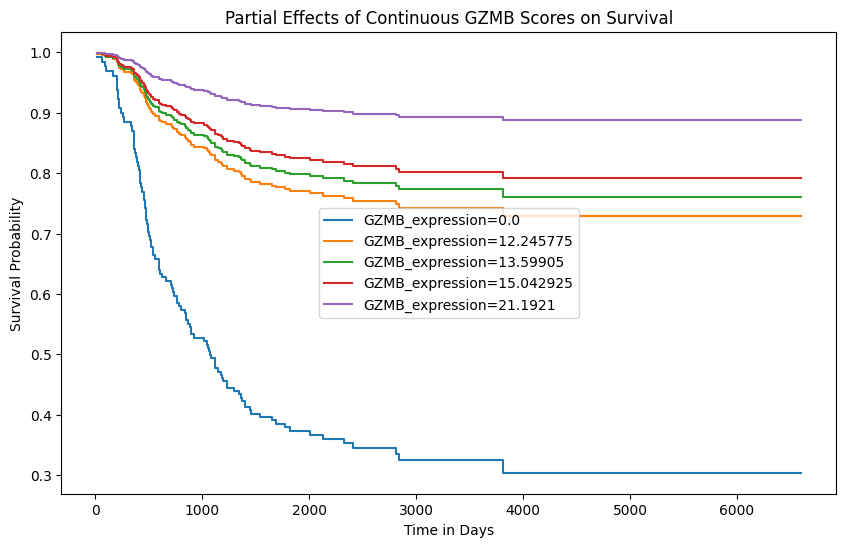

In [146]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'GZMB_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="GZMB_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='GZMB_expression', values=[cox_data['GZMB_expression'].min(), cox_data['GZMB_expression'].quantile(0.25), cox_data['GZMB_expression'].median(), cox_data['GZMB_expression'].quantile(0.75), cox_data['GZMB_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous GZMB Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -617.61
         time fit was run = 2024-07-08 13:39:25 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
GZMB_expression -0.09      0.92      0.03           -0.14           -0.03                0.87                0.97
CD8B_expression -0.12      0.89      0.07           -0.25            0.02                0.78                1.02

                 cmp to     z      p  -log2(p)
covariate                                     
GZMB_expression    0.00 -3.21 <0.005      9.57
CD8B_expression    0.00 -1.67   0.10      3.39
---
Concordance = 0.62
Partial AIC = 1239.22
log-likelihood ratio test = 17.95 on 2 df
-log2(p) of ll-ratio test = 12.95

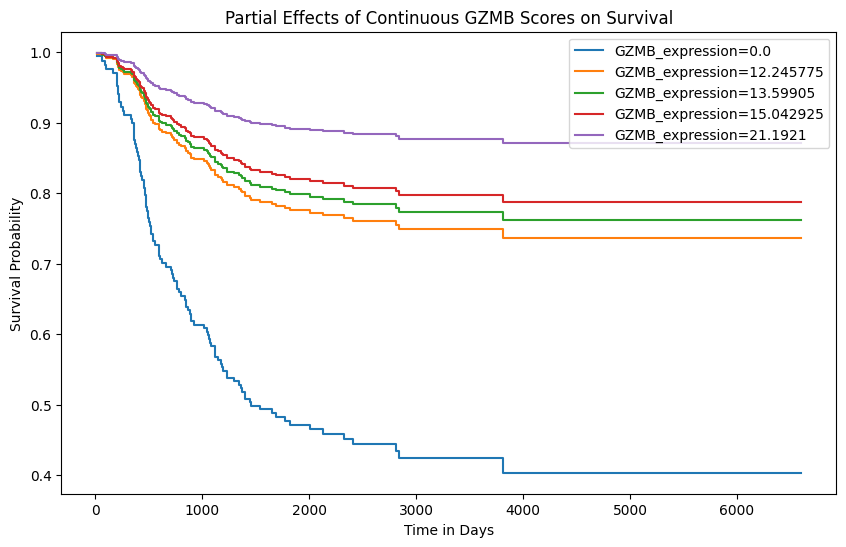

In [147]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'GZMB_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="GZMB_expression + CD8B_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='GZMB_expression', values=[cox_data['GZMB_expression'].min(), cox_data['GZMB_expression'].quantile(0.25), cox_data['GZMB_expression'].median(), cox_data['GZMB_expression'].quantile(0.75), cox_data['GZMB_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous GZMB Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -599.26
         time fit was run = 2024-07-08 13:39:27 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
GZMB_expression -0.00      1.00      0.03           -0.07            0.06                0.94                1.06
CD8B_expression  0.19      1.21      0.09            0.01            0.37                1.01                1.45
CD3E_expression -0.14      0.87      0.08           -0.29            0.01                0.75                1.01
CD4_expression  -0.49      0.61      0.12           -0.73           -0.26                0.48                0.77

                 cmp to     z      p  -log2(p)
covariate                                     
GZMB_expression    0.00 -0.08   0.94      0.09
CD8B_expression    0.00  2.07   0.04      4.71
CD3E_expression    0.00 -1.82   0.07      3.87
CD4_expression     0.00 -4.17 <0.005     15.03
---
Concordance = 0.71
Partial AIC = 1206.52
log-likelihood ratio test = 54.64 on 4 df
-log2(p) of ll-ratio test = 34.59

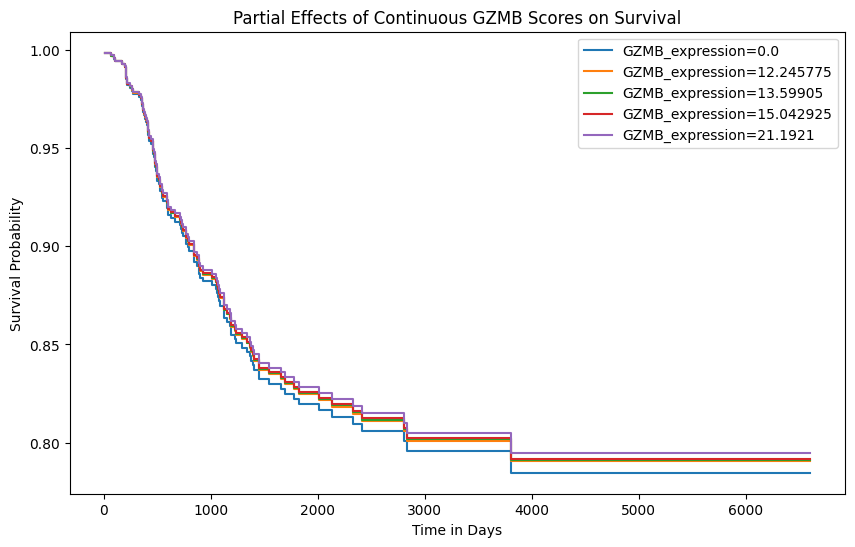

In [148]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'GZMB_expression', 'CD8B_expression', 'CD3E_expression', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="GZMB_expression + CD8B_expression + CD3E_expression + CD4_expression")

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='GZMB_expression', values=[cox_data['GZMB_expression'].min(), cox_data['GZMB_expression'].quantile(0.25), cox_data['GZMB_expression'].median(), cox_data['GZMB_expression'].quantile(0.75), cox_data['GZMB_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous GZMB Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

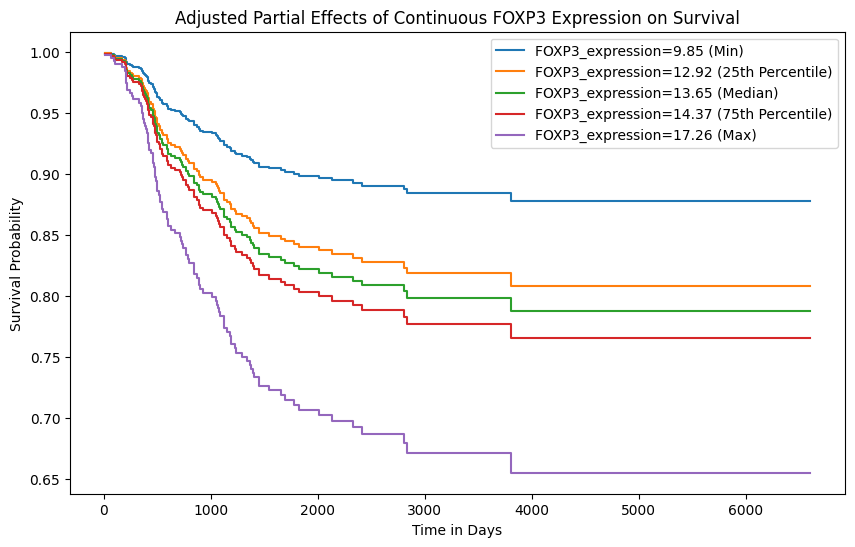

In [149]:
cox_data = data[['os days', 'os bin', 'FOXP3_expression', 'CD3E_expression', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E and CD4 expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="FOXP3_expression + CD3E_expression + CD4_expression")

# Define quartile values for FOXP3 expression
quartiles = [
    cox_data['FOXP3_expression'].min(), 
    cox_data['FOXP3_expression'].quantile(0.25), 
    cox_data['FOXP3_expression'].median(), 
    cox_data['FOXP3_expression'].quantile(0.75), 
    cox_data['FOXP3_expression'].max()
]

# Plot the effect of FOXP3 expression on survival with confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(covariates='FOXP3_expression', values=quartiles, plot_baseline=False, ax=ax)

# Adjusting the legend to display quartile values
labels = [
    f"FOXP3_expression={cox_data['FOXP3_expression'].min():.2f} (Min)",
    f"FOXP3_expression={cox_data['FOXP3_expression'].quantile(0.25):.2f} (25th Percentile)",
    f"FOXP3_expression={cox_data['FOXP3_expression'].median():.2f} (Median)",
    f"FOXP3_expression={cox_data['FOXP3_expression'].quantile(0.75):.2f} (75th Percentile)",
    f"FOXP3_expression={cox_data['FOXP3_expression'].max():.2f} (Max)"
]

ax.legend(labels)
plt.title('Adjusted Partial Effects of Continuous FOXP3 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

# Publication

Colors from the custom colormap:
Step 0: (0.16470588235294117, 0.35294117647058826, 0.796078431372549, 1.0)
Step 1: (0.1786492374727669, 0.3459694989106754, 0.7398692810457516, 1.0)
Step 2: (0.1925925925925926, 0.33899782135076256, 0.6836601307189543, 1.0)
Step 3: (0.20653594771241832, 0.3320261437908497, 0.6274509803921567, 1.0)
Step 4: (0.220479302832244, 0.32505446623093687, 0.5712418300653594, 1.0)
Step 5: (0.23442265795206974, 0.31808278867102396, 0.515032679738562, 1.0)
Step 6: (0.24836601307189546, 0.3111111111111111, 0.4588235294117646, 1.0)
Step 7: (0.2623093681917211, 0.30413943355119827, 0.4026143790849673, 1.0)
Step 8: (0.2762527233115468, 0.2971677559912854, 0.3464052287581699, 1.0)
Step 9: (0.2901960784313726, 0.2901960784313726, 0.2901960784313726, 1.0)


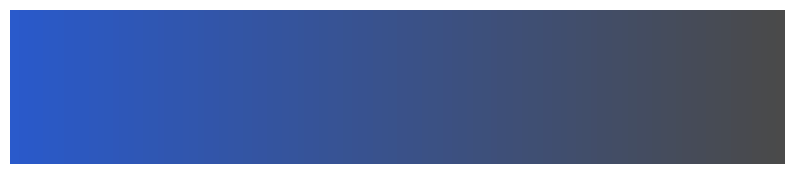

In [150]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom color map from darker grey to more vibrant blue
colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Extract and print colors from the colormap at 10 evenly spaced intervals
print("Colors from the custom colormap:")
for i in range(10):
    # Get color for each tenth of the colormap
    color = cmap(i / 9)  # Normalize position to 0-1
    print(f"Step {i}: {color}")  # Print RGBA values

# Optional: Visualize these colors in a plot
fig, ax = plt.subplots(figsize=(10, 2))
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()
plt.show()

Hexadecimal colors from the custom colormap:
Color 1: #2a5acb
Color 2: #3256aa
Color 3: #3a528a
Color 4: #424e69
Color 5: #4a4a4a


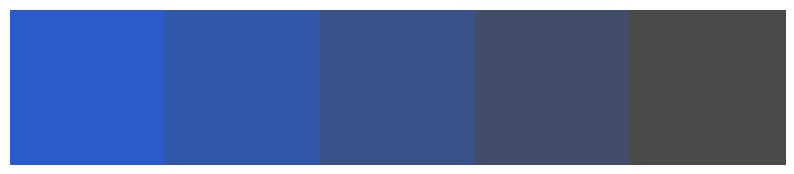

In [151]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex

# Define a custom color map from darker grey to more vibrant blue
colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Extract and convert colors from the colormap at 5 evenly spaced intervals to hex
hex_colors = []
print("Hexadecimal colors from the custom colormap:")
for i in range(5):
    # Get color for each fifth of the colormap
    color = cmap(i / 4)  # Normalize position to 0-1
    hex_color = to_hex(color)
    hex_colors.append(hex_color)
    print(f"Color {i + 1}: {hex_color}")  # Print hex values

# Optional: Visualize these colors in a plot
fig, ax = plt.subplots(figsize=(10, 2))
for i, hex_color in enumerate(hex_colors):
    ax.fill_between([i * 0.2, (i + 1) * 0.2], 0, 1, color=hex_color)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_axis_off()
plt.show()


## CD3E

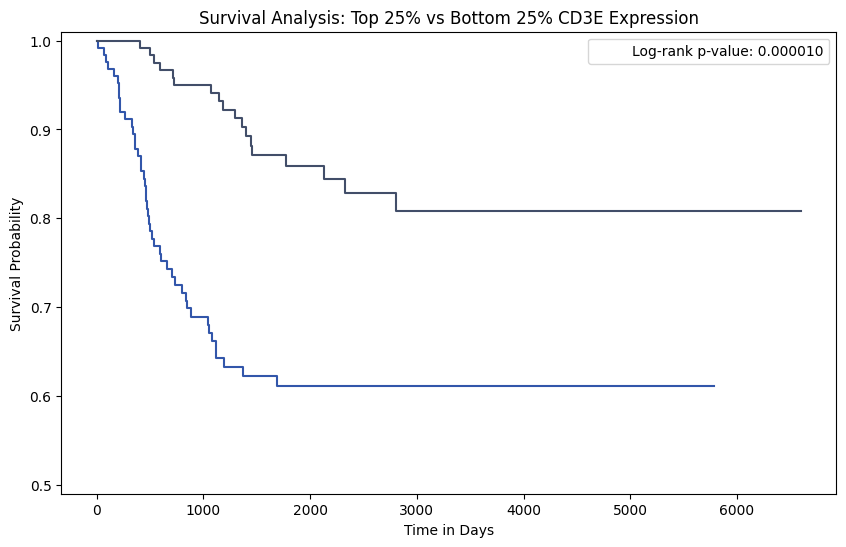

In [152]:
# Stratify samples into top 25% and bottom 25% based on CD3E expression
top_25 = data[data['CD3E_expression'] >= data['CD3E_expression'].quantile(0.75)]
bottom_25 = data[data['CD3E_expression'] <= data['CD3E_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% CD3E expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD3E Expression')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% CD3E expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD3E Expression')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD3E Expression')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Legend with p-value only
plt.legend([plt.Line2D([], [], color='none')], [f'Log-rank p-value: {p_value:.6f}'], loc='upper right')

# Save the plot as svg without flattening
plt.savefig('plots/CD3E_km.svg', format='svg', bbox_inches='tight')

plt.show()

## CD8B

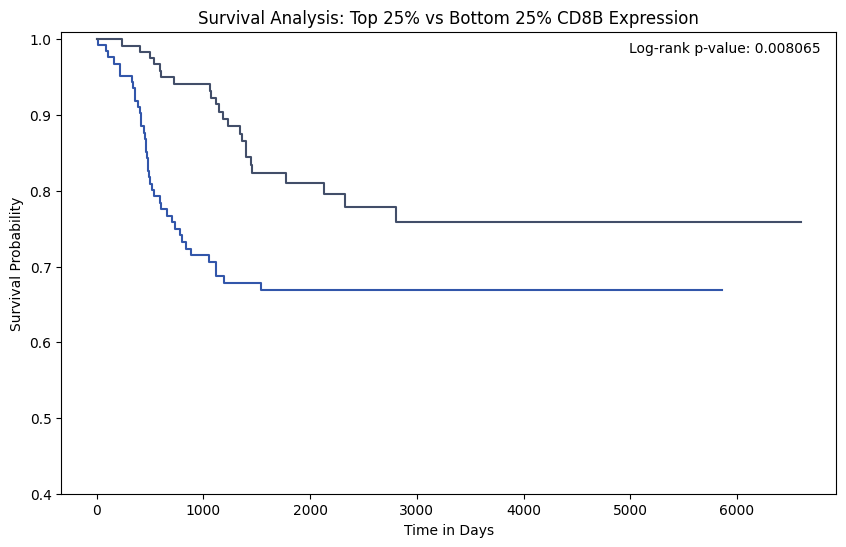

In [153]:
# Stratify samples into top 25% and bottom 25% based on CD8B expression
top_25 = data[data['CD8B_expression'] >= data['CD8B_expression'].quantile(0.75)]
bottom_25 = data[data['CD8B_expression'] <= data['CD8B_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% CD8B expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD8B Expression')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% CD8B expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD8B Expression')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0.4, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD8B Expression')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Legend with p-value only
# plt.legend([plt.Line2D([], [], color='none')], [f'Log-rank p-value: {p_value:.6f}'], loc='upper right')
ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')


# Save the plot as svg without flattening
plt.savefig('plots/CD8B_km.svg', format='svg', bbox_inches='tight')

plt.show()


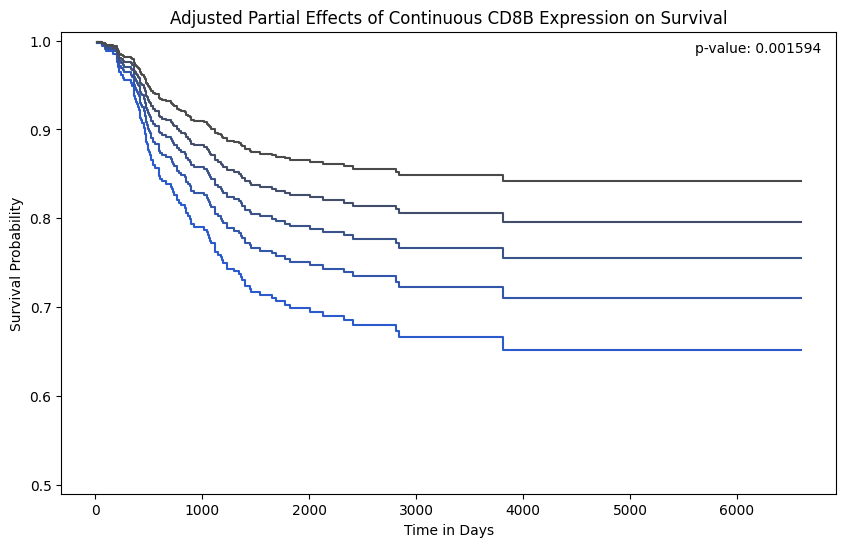

In [154]:
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from matplotlib.colors import LinearSegmentedColormap


# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with FOXP3 and CD8B as covariates alongside CD3E and CD4
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="CD8B_expression")

# Display the model results
# cph.print_summary()

# Plotting the effect of CD8B expression on survival, adjusting for other covariates
values = [
    cox_data['CD8B_expression'].quantile(0.05), 
    cox_data['CD8B_expression'].quantile(0.25), 
    cox_data['CD8B_expression'].median(), 
    cox_data['CD8B_expression'].quantile(0.75), 
    cox_data['CD8B_expression'].quantile(0.95)
]

# Define a custom color map from grey to blue
colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='CD8B_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Adjusted Partial Effects of Continuous CD8B Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')


# Retrieve the p-value for the CD8B expression from the Cox model summary
p_value = cph.summary.loc['CD8B_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')


# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/CD8B_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## KEGG TCR Pathway

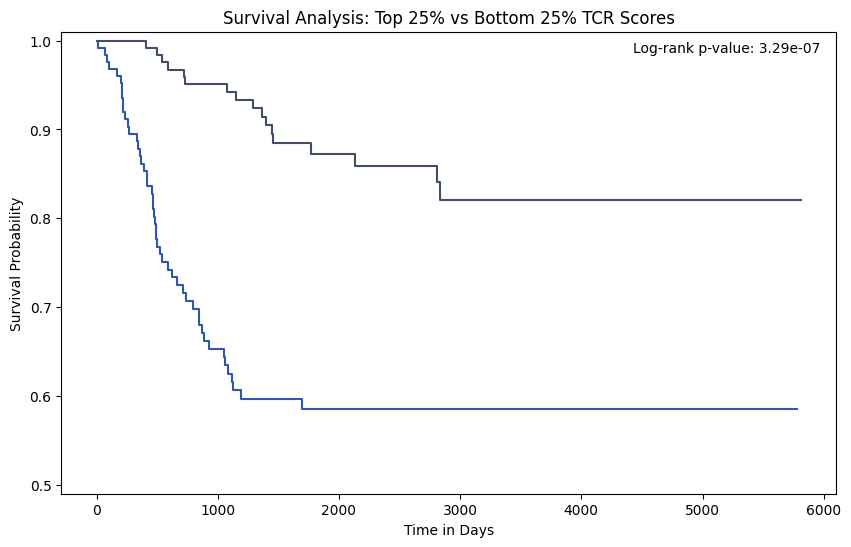

In [155]:
# Stratify samples into top 25% and bottom 25% based on TCR scores
top_25 = data[data['tcr_scores'] >= data['tcr_scores'].quantile(0.75)]
bottom_25 = data[data['tcr_scores'] <= data['tcr_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TCR Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TCR Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% TCR Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/TCR_km.svg', format='svg', bbox_inches='tight')

plt.show()

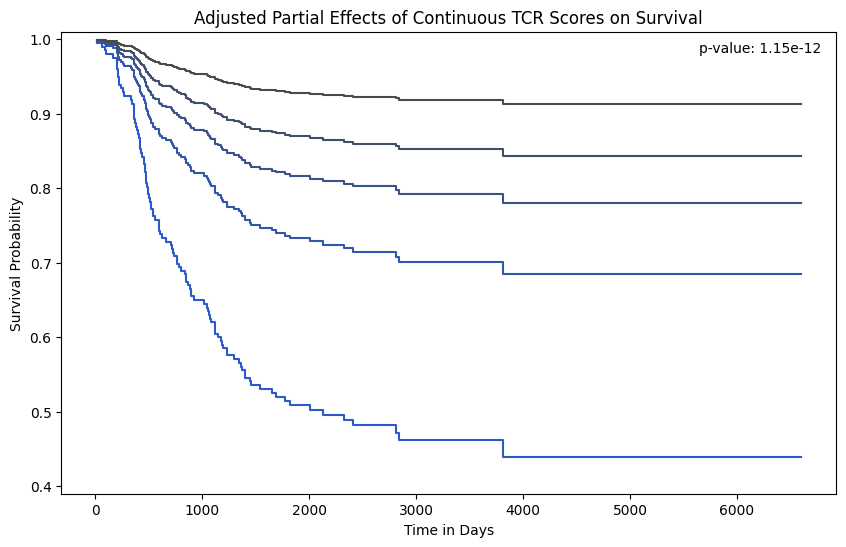

In [156]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'tcr_scores']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with tcr_scores as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="tcr_scores")

# Plotting the effect of tcr_scores on survival
values = [
    cox_data['tcr_scores'].quantile(0.05), 
    cox_data['tcr_scores'].quantile(0.25), 
    cox_data['tcr_scores'].median(), 
    cox_data['tcr_scores'].quantile(0.75), 
    cox_data['tcr_scores'].quantile(0.95)
]

# Custom colors from dark grey to deep blue
colors = ["#2A5ACB", "#4A4A4A"]  # blue to grey
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='tcr_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.39, 1.01)  # Set y-axis range from 0 to 1

plt.title('Adjusted Partial Effects of Continuous TCR Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the tcr_scores from the Cox model summary
p_value = cph.summary.loc['tcr_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/TCR_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## FOXP3

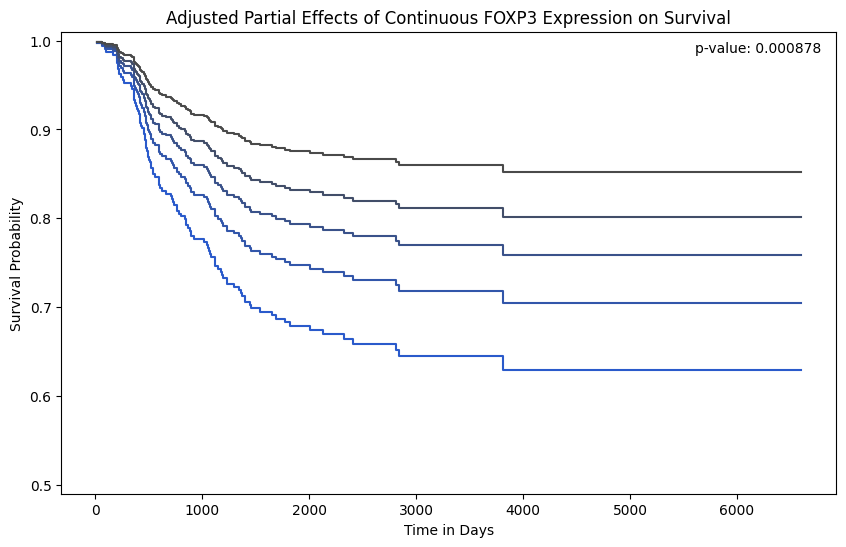

In [157]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'FOXP3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with FOXP3 as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="FOXP3_expression")

# Display the model results
# cph.print_summary()

# Plotting the effect of FOXP3 expression on survival, adjusting for other covariates
values = [
    cox_data['FOXP3_expression'].quantile(0.05), 
    cox_data['FOXP3_expression'].quantile(0.25), 
    cox_data['FOXP3_expression'].median(), 
    cox_data['FOXP3_expression'].quantile(0.75), 
    cox_data['FOXP3_expression'].quantile(0.95)
]

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='FOXP3_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Adjusted Partial Effects of Continuous FOXP3 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['FOXP3_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/FOXP3_cph.svg', format='svg', bbox_inches='tight')


plt.show()


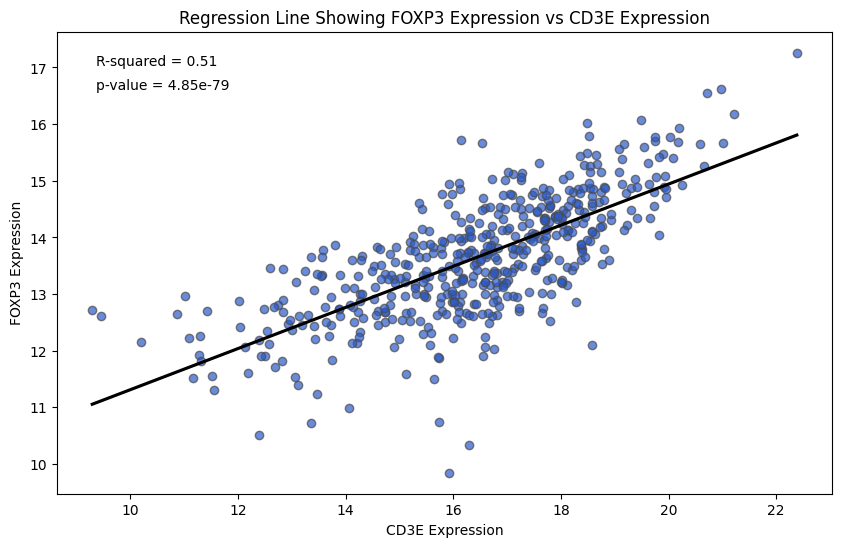

In [158]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD3E_expression'])  # Changed to CD3E_expression
Y = data['FOXP3_expression']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD3E_expression', y='FOXP3_expression', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing FOXP3 Expression vs CD3E Expression')
plt.xlabel('CD3E Expression')  # Corrected label
plt.ylabel('FOXP3 Expression')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD3E_expression']  # Corrected for CD3E_expression

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

# save plot
plt.savefig('plots/FOXP3_CD3E_reg.svg', format='svg', bbox_inches='tight')


plt.show()

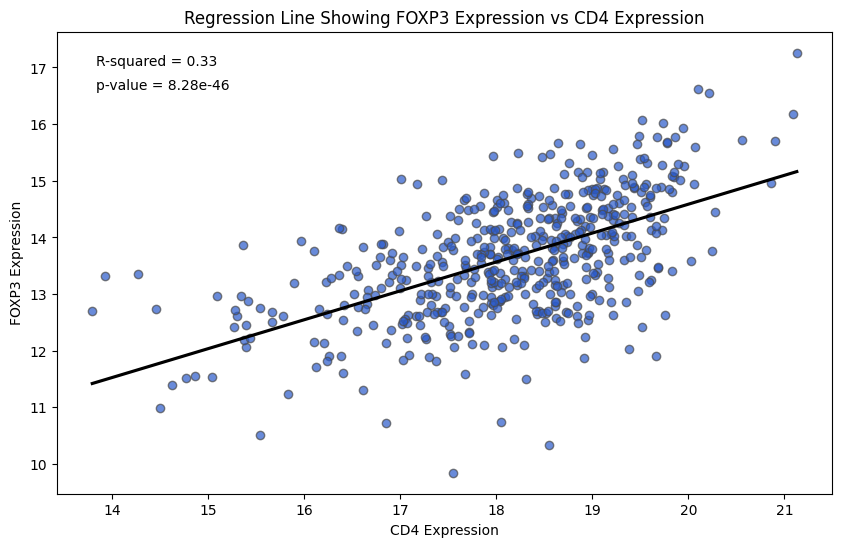

In [159]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD4_expression']) 
Y = data['FOXP3_expression']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD4_expression', y='FOXP3_expression', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing FOXP3 Expression vs CD4 Expression')
plt.xlabel('CD4 Expression')  # Corrected label
plt.ylabel('FOXP3 Expression')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD4_expression']

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

# save plot
plt.savefig('plots/FOXP3_CD4_reg.svg', format='svg', bbox_inches='tight')

plt.show()

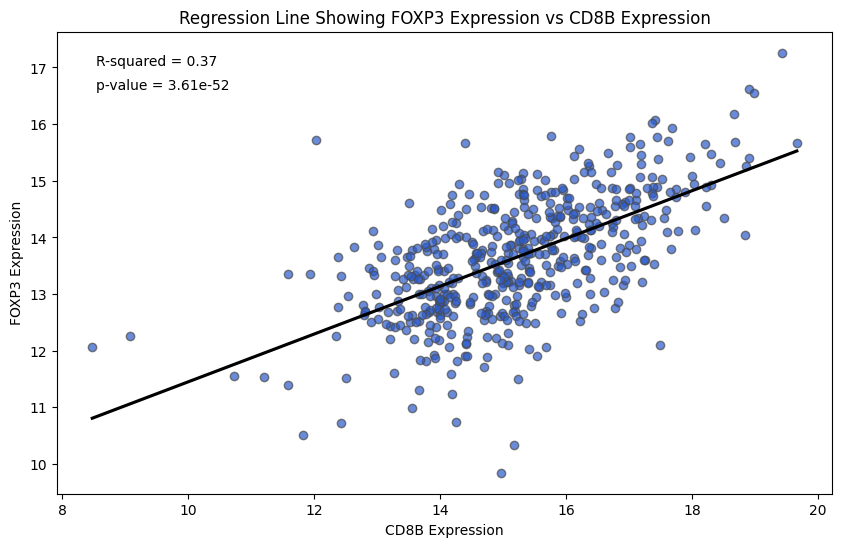

In [160]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD8B_expression'])
Y = data['FOXP3_expression']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD8B_expression', y='FOXP3_expression', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing FOXP3 Expression vs CD8B Expression')
plt.xlabel('CD8B Expression')  # Corrected label
plt.ylabel('FOXP3 Expression')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD8B_expression']

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

# save plot
plt.savefig('plots/FOXP3_CD8B_reg.svg', format='svg', bbox_inches='tight')

plt.show()

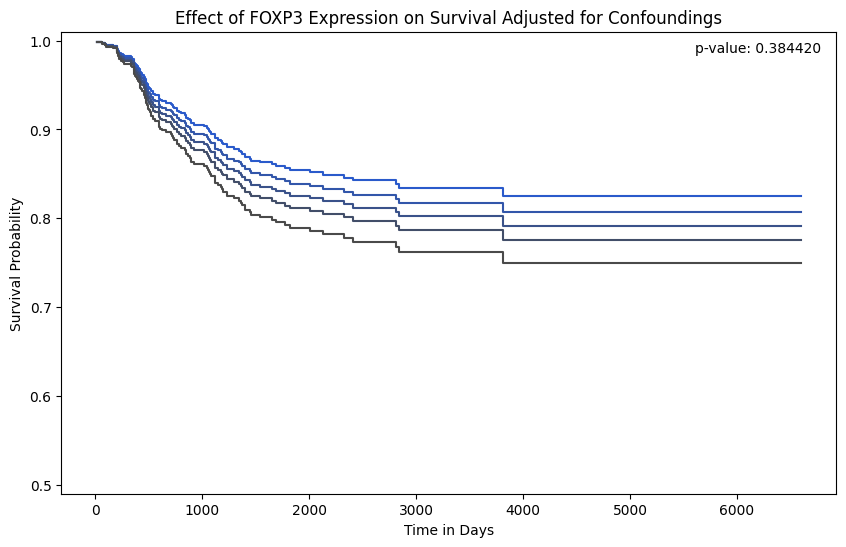

In [161]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'FOXP3_expression', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="FOXP3_expression + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['FOXP3_expression'].quantile(0.05), 
    cox_data['FOXP3_expression'].quantile(0.25), 
    cox_data['FOXP3_expression'].median(), 
    cox_data['FOXP3_expression'].quantile(0.75), 
    cox_data['FOXP3_expression'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='FOXP3_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of FOXP3 Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['FOXP3_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/FOXP3_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## GZMB

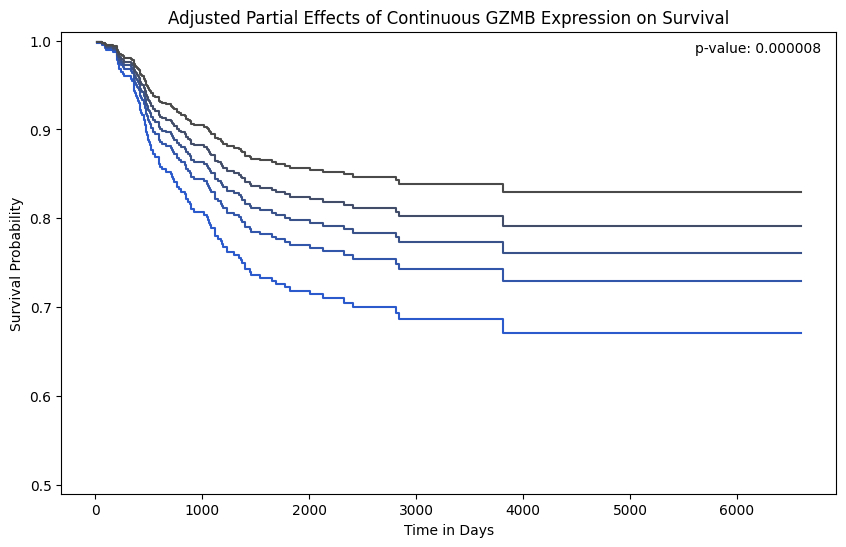

In [162]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'GZMB_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with GZMB as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="GZMB_expression")

# Plotting the effect of GZMB expression on survival
values = [
    cox_data['GZMB_expression'].quantile(0.05), 
    cox_data['GZMB_expression'].quantile(0.25), 
    cox_data['GZMB_expression'].median(), 
    cox_data['GZMB_expression'].quantile(0.75), 
    cox_data['GZMB_expression'].quantile(0.95)
]

# Custom color map from dark grey to deep blue
colors = ["#2A5ACB", "#4A4A4A"]  # Dark grey to blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='GZMB_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Adjusted Partial Effects of Continuous GZMB Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the GZMB expression from the Cox model summary
p_value = cph.summary.loc['GZMB_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/GZMB_cph.svg', format='svg', bbox_inches='tight')

plt.show()

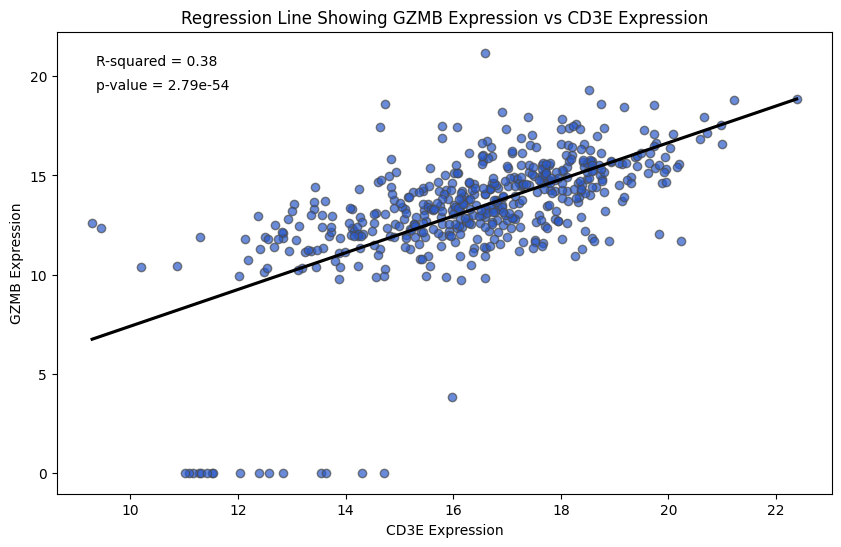

In [163]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD3E_expression'])  # Changed to CD3E_expression
Y = data['GZMB_expression']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD3E_expression', y='GZMB_expression', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing GZMB Expression vs CD3E Expression')
plt.xlabel('CD3E Expression')
plt.ylabel('GZMB Expression')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD3E_expression']  # Corrected for CD3E_expression

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

# save plot
plt.savefig('plots/GZMB_CD3E_reg.svg', format='svg', bbox_inches='tight')


plt.show()

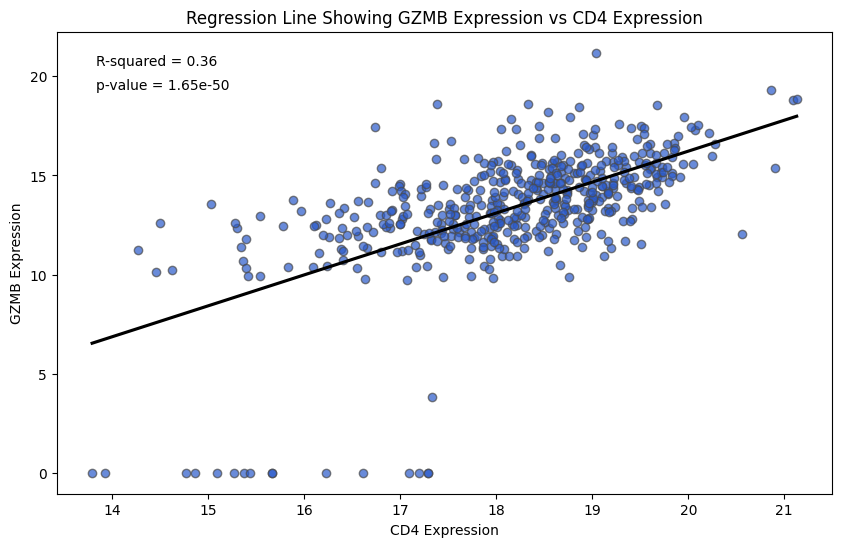

In [164]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD4_expression']) 
Y = data['GZMB_expression']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD4_expression', y='GZMB_expression', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing GZMB Expression vs CD4 Expression')
plt.xlabel('CD4 Expression')  # Corrected label
plt.ylabel('GZMB Expression')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD4_expression']

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

# save plot
plt.savefig('plots/GZMB_CD4_reg.svg', format='svg', bbox_inches='tight')

plt.show()

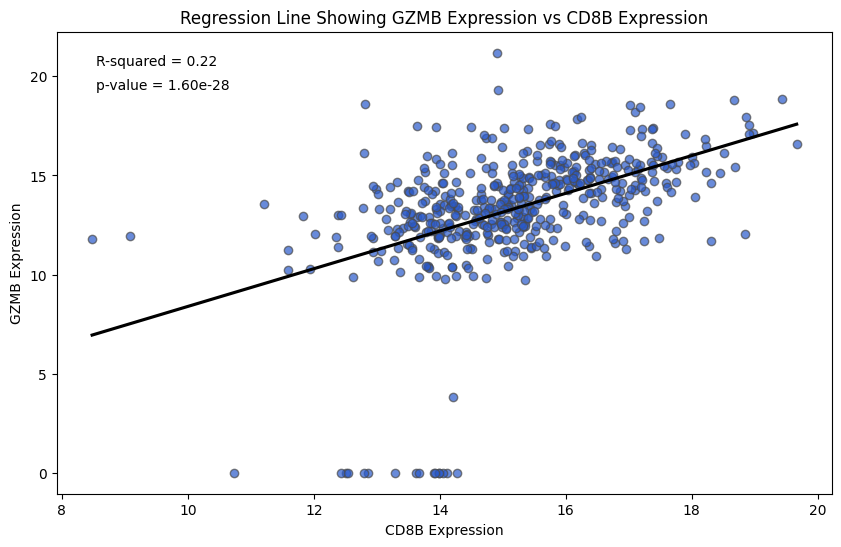

In [165]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD8B_expression'])
Y = data['GZMB_expression']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD8B_expression', y='GZMB_expression', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing GZMB Expression vs CD8B Expression')
plt.xlabel('CD8B Expression')
plt.ylabel('GZMB Expression')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD8B_expression']

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

# save plot
plt.savefig('plots/GZMB_CD8B_reg.svg', format='svg', bbox_inches='tight')

plt.show()

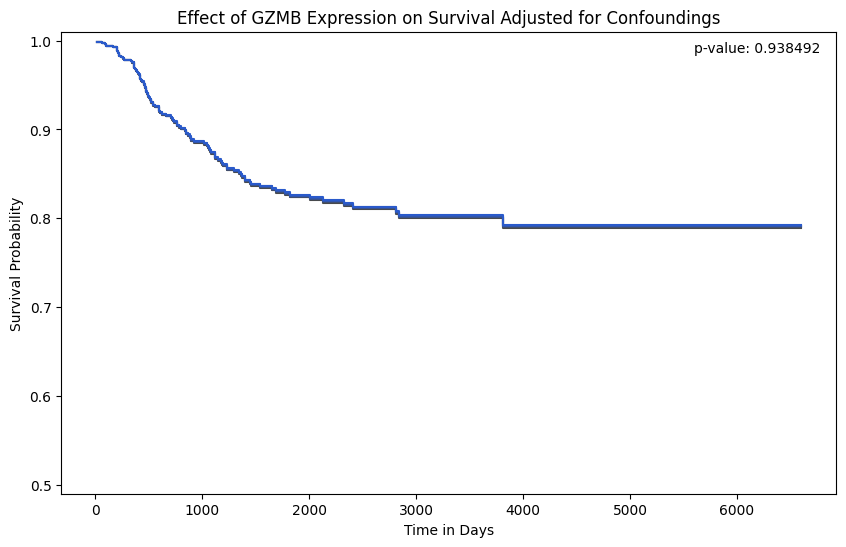

In [166]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'GZMB_expression', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="GZMB_expression + CD3E_expression + CD4_expression + CD8B_expression")

# Define the values for GZMB_expression
values = [
    cox_data['GZMB_expression'].quantile(0.05), 
    cox_data['GZMB_expression'].quantile(0.25), 
    cox_data['GZMB_expression'].median(), 
    cox_data['GZMB_expression'].quantile(0.75), 
    cox_data['GZMB_expression'].quantile(0.95)
]

# Plotting the effect of GZMB expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#4A4A4A", "#2A5ACB"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='GZMB_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of GZMB Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the GZMB expression from the Cox model summary
p_value = cph.summary.loc['GZMB_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/GZMB_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

## MYCN

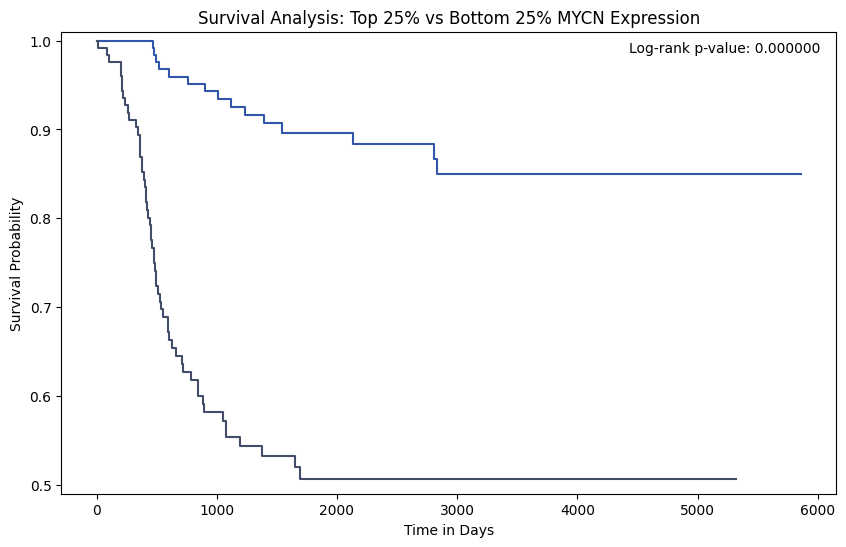

In [167]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['MYCN_expression'] >= data['MYCN_expression'].quantile(0.75)]
bottom_25 = data[data['MYCN_expression'] <= data['MYCN_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% MYCN expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% MYCN Expression')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% MYCN expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% MYCN Expression')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% MYCN Expression')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as svg without flattening
plt.savefig('plots/MYCN_km.svg', format='svg', bbox_inches='tight')

plt.show()

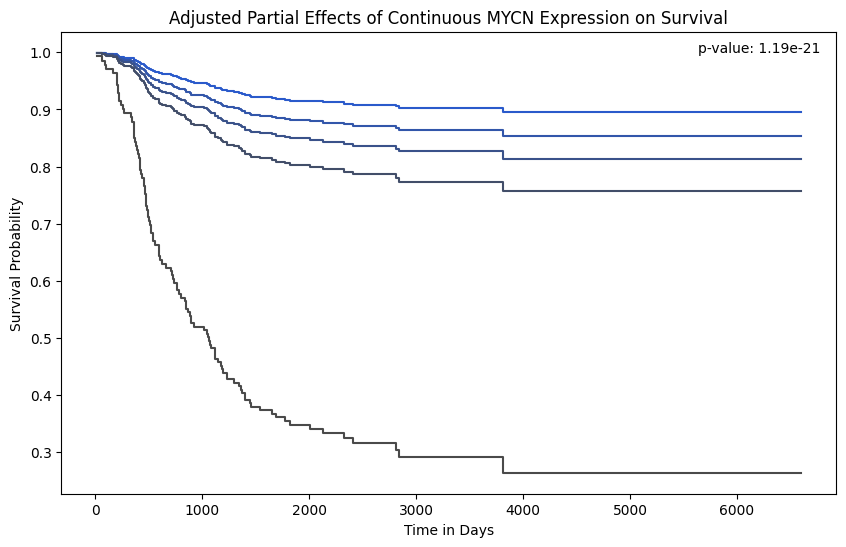

In [168]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'MYCN_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with MYCN as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="MYCN_expression")

# Plotting the effect of MYCN expression on survival
values = [
    cox_data['MYCN_expression'].quantile(0.05), 
    cox_data['MYCN_expression'].quantile(0.25), 
    cox_data['MYCN_expression'].median(), 
    cox_data['MYCN_expression'].quantile(0.75), 
    cox_data['MYCN_expression'].quantile(0.95)
]

# Custom colors from dark grey to deep blue
colors = ["#2A5ACB", "#4A4A4A"]  # blue to Dark grey
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='MYCN_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

#plt.ylim(0, 1.01)  # Set y-axis range from 0 to 1

plt.title('Adjusted Partial Effects of Continuous MYCN Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the MYCN expression from the Cox model summary
p_value = cph.summary.loc['MYCN_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/MYCN_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## ALK

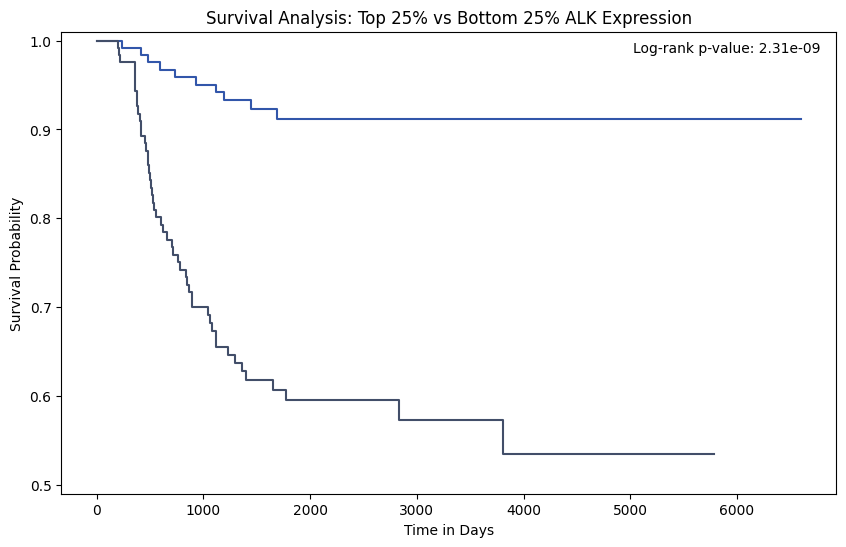

In [169]:
# Stratify samples into top 25% and bottom 25% based on ALK expression
top_25 = data[data['ALK_expression'] >= data['ALK_expression'].quantile(0.75)]
bottom_25 = data[data['ALK_expression'] <= data['ALK_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% ALK expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ALK Expression')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% ALK expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ALK Expression')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% ALK Expression')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as svg without flattening
plt.savefig('plots/ALK_km.svg', format='svg', bbox_inches='tight')

plt.show()

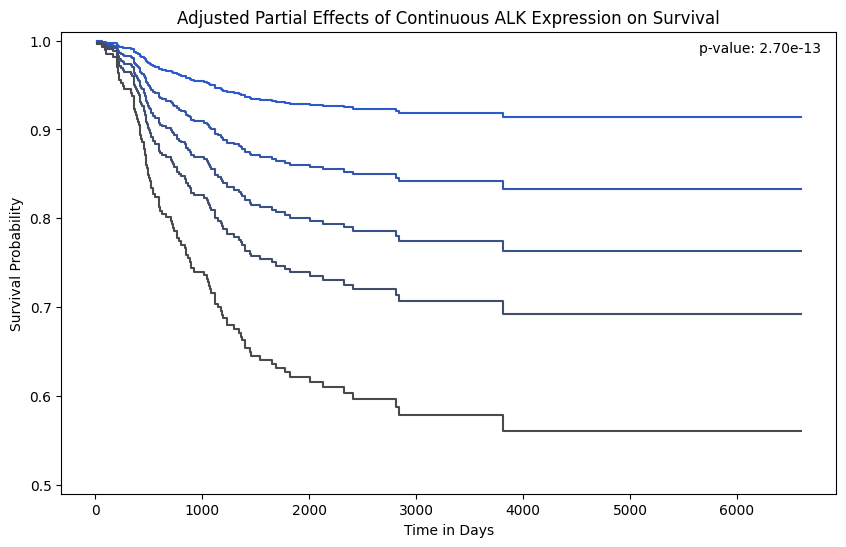

In [170]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'ALK_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with ALK as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="ALK_expression")

# Plotting the effect of ALK expression on survival
values = [
    cox_data['ALK_expression'].quantile(0.05), 
    cox_data['ALK_expression'].quantile(0.25), 
    cox_data['ALK_expression'].median(), 
    cox_data['ALK_expression'].quantile(0.75), 
    cox_data['ALK_expression'].quantile(0.95)
]

# Custom colors from dark grey to deep blue
colors = ["#2A5ACB", "#4A4A4A"]  # blue to Dark grey
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='ALK_expression', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Adjusted Partial Effects of Continuous ALK Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the ALK expression from the Cox model summary
p_value = cph.summary.loc['ALK_expression', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/ALK_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## T-cell Fetal Signature

In [171]:
# Read the gene list from the file
with open("dataset/top_50_de_fetus_genes.csv", 'r') as file:
    gene_list = file.read().splitlines()
    
gene_list

['RPL41',
 'EEF1A1',
 'RPS27',
 'B2M',
 'H3-3B',
 'RPL10',
 'MALAT1',
 'RPS15A',
 'MT-CO1',
 'RPL13',
 'RPLP1',
 'TMSB4X',
 'H3-3A',
 'RPS10',
 'RPS18',
 'TPT1',
 'RPS3',
 'RPS24',
 'RPL39',
 'RPS4X',
 'RPL26',
 'RPL37',
 'RPL28',
 'RPL34',
 'RPS19',
 'RPL32',
 'RPS28',
 'RPS12',
 'RPL18A',
 'RPS23',
 'RPS27A',
 'RPS6',
 'RPL19',
 'RPS14',
 'RPL15',
 'RPL3',
 'MT-CO2',
 'RPL11',
 'RPS3A',
 'RPL23A',
 'HSP90AA1',
 'RPS15',
 'ACTB',
 'RPL30',
 'RPS8',
 'RPS29',
 'RPLP2',
 'ENSG00000289901',
 'BBLN',
 'RPL29']

In [172]:
# List of Fetal signature genes
fetal_genes = gene_list

# Calculate fetal signature scores for each sample
fetal_scores = gene_data[gene_data['Gene'].isin(fetal_genes)].iloc[:, 8:].mean(axis=0)
fetal_scores.name = 'fetal_scores'

# Combine fetal scores with metadata
data['fetal_scores'] = data['Sample ID'].map(fetal_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetal_scores'], inplace=True)

In [173]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  TGFB3_expression  GNAS_expression  \
0            24.7943  ...           16.0817          24.1815   
1            25.2958  ...           15.3162          24.9106   
2            24.5375  ...           16.8757          24.7266   
3            24.6351  ...           17.1117          24.8053   
4            24.9948  ...           18.6260          24.9375   
..               ...  ...               ...              ...   
493          25.4461  ...           17.0877          24.8656   
494          25.1602  ...           16.5812          25.3897   
495          25.1211  ...           17.0788          25.6038   
496          24.7802  ...           16.5166          24.9727   
497          25.0471  ...           17.3601          24.2099   

     ADRB1_expression  ADRB2_expression  ADRB3_expression  tcr_scores  \
0              0.0000           14.3614            0.0000   18.351773   
1              8.1209           12.7041            9.0355   17.641285   
2              8.5208            9.7105            9.4976   15.599100   
3              6.8402           13.4866            9.4368   17.009327   
4              0.0000           11.6505            9.7566   16.168304   
..                ...               ...               ...         ...   
493            9.3716           15.3519           12.0438   17.259510   
494            9.2485           16.1540           10.8068   17.690890   
495            7.8735           12.8784            9.4285   16.512125   
496            6.8155           15.4167            9.4045   17.547460   
497            9.6810           15.1066            9.2748   18.210696   

     tcr2_genes  TCF7_expression  GZMB_expression  fetal_scores  
0     18.792294          19.4520          14.9177     22.061426  
1     18.460935          17.2688          14.6264     21.530313  
2     17.180075          14.0032           0.0000     22.852096  
3     18.224309          16.2404          13.5640     22.087991  
4     17.749510          15.4910          12.1035     22.680917  
..          ...              ...              ...           ...  
493   18.457485          17.0738          13.1696     21.967517  
494   18.724011          18.0551          16.4249     21.789235  
495   18.053765          16.8025          11.9335     22.003226  
496   18.439331          17.3541          14.4890     

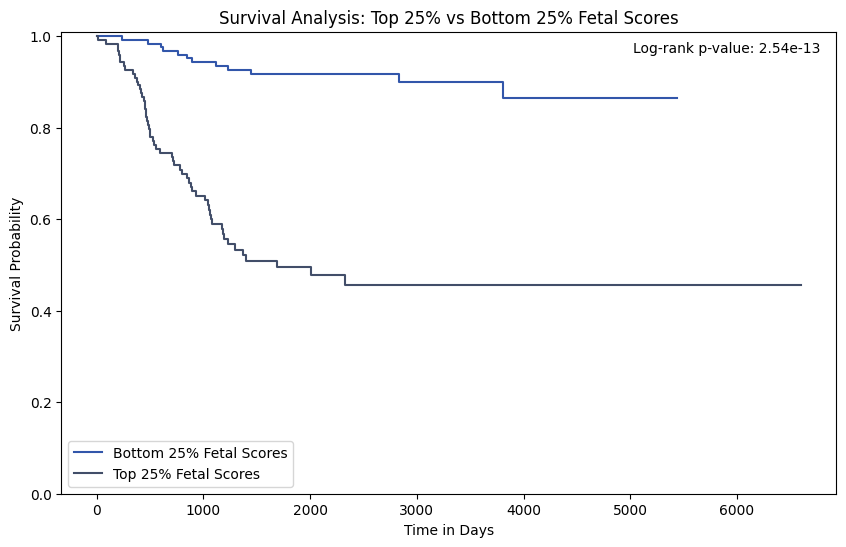

In [174]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetal_scores'] >= data['fetal_scores'].quantile(0.75)]
bottom_25 = data[data['fetal_scores'] <= data['fetal_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_km.svg', format='svg', bbox_inches='tight')

plt.show()

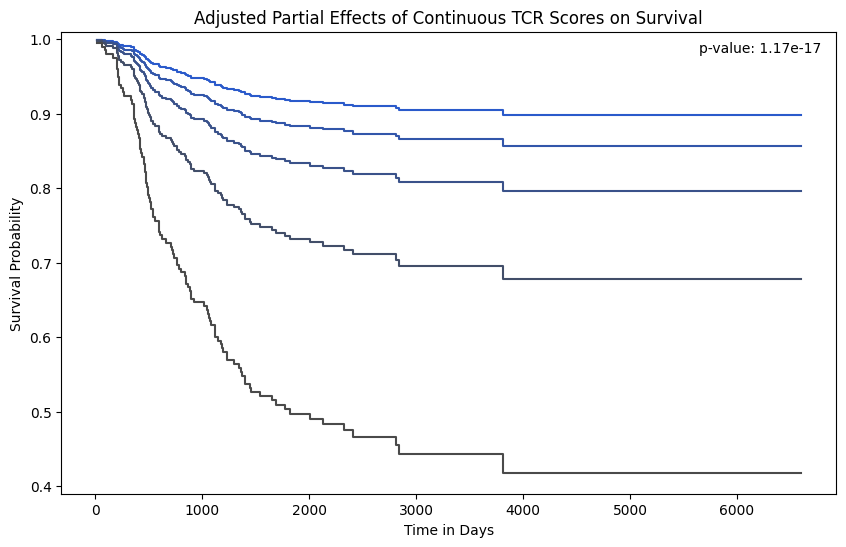

In [175]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'fetal_scores']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with tcr_scores as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetal_scores")

# Plotting the effect of tcr_scores on survival
values = [
    cox_data['fetal_scores'].quantile(0.05), 
    cox_data['fetal_scores'].quantile(0.25), 
    cox_data['fetal_scores'].median(), 
    cox_data['fetal_scores'].quantile(0.75), 
    cox_data['fetal_scores'].quantile(0.95)
]

# Custom colors from dark grey to deep blue
colors = ["#2A5ACB", "#4A4A4A"]  # blue to grey
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='fetal_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.39, 1.01)  # Set y-axis range from 0 to 1

plt.title('Adjusted Partial Effects of Continuous TCR Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the tcr_scores from the Cox model summary
p_value = cph.summary.loc['fetal_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetal_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## Adult Signature

In [176]:
# Read the gene list from the file
with open("dataset/top_50_de_adult_genes.csv", 'r') as file:
    gene_list = file.read().splitlines()
    
gene_list

['H3F3B',
 'FP236383.3',
 'KLF2',
 'TXNIP',
 'H3F3A',
 'PNRC1',
 'RBFOX2',
 'APOO',
 'DDX5',
 'ITM2B',
 'S100A6',
 'FXYD5',
 'RPS4Y1',
 'TLE5',
 'PFDN5',
 'PTPRCAP',
 'H1FX',
 'RPL36AL',
 'TOMM7',
 'C12orf57',
 'LINC01578',
 'ZFP36L2',
 'PCED1B-AS1',
 'TSC22D3',
 'COMMD6',
 'MZT2B',
 'SRSF5',
 'VIM',
 'COX4I1',
 'CIRBP',
 'HNRNPDL',
 'AC138123.1',
 'HIST1H1E',
 'EEF1D',
 'HLA-E',
 'C9orf16',
 'EIF3K',
 'ATP5MD',
 'FP671120.4',
 'DAZAP2',
 'CD48',
 'H2AFZ',
 'GSTK1',
 'YPEL3',
 'PPDPF',
 'ATP5MPL',
 'SH3BGRL3',
 'SNRPD2',
 'S100A10',
 'TAF10']

In [177]:
# List of Fetal signature genes
adult_genes = gene_list

# Calculate fetal signature scores for each sample
adult_scores = gene_data[gene_data['Gene'].isin(adult_genes)].iloc[:, 8:].mean(axis=0)
adult_scores.name = 'adult_scores'

# Combine fetal scores with metadata
data['adult_scores'] = data['Sample ID'].map(adult_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['adult_scores'], inplace=True)

In [178]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  GNAS_expression  ADRB1_expression  \
0            24.7943  ...          24.1815            0.0000   
1            25.2958  ...          24.9106            8.1209   
2            24.5375  ...          24.7266            8.5208   
3            24.6351  ...          24.8053            6.8402   
4            24.9948  ...          24.9375            0.0000   
..               ...  ...              ...               ...   
493          25.4461  ...          24.8656            9.3716   
494          25.1602  ...          25.3897            9.2485   
495          25.1211  ...          25.6038            7.8735   
496          24.7802  ...          24.9727            6.8155   
497          25.0471  ...          24.2099            9.6810   

     ADRB2_expression  ADRB3_expression  tcr_scores  tcr2_genes  \
0             14.3614            0.0000   18.351773   18.792294   
1             12.7041            9.0355   17.641285   18.460935   
2              9.7105            9.4976   15.599100   17.180075   
3             13.4866            9.4368   17.009327   18.224309   
4             11.6505            9.7566   16.168304   17.749510   
..                ...               ...         ...         ...   
493           15.3519           12.0438   17.259510   18.457485   
494           16.1540           10.8068   17.690890   18.724011   
495           12.8784            9.4285   16.512125   18.053765   
496           15.4167            9.4045   17.547460   18.439331   
497           15.1066            9.2748   18.210696   18.875753   

     TCF7_expression  GZMB_expression  fetal_scores  adult_scores  
0            19.4520          14.9177     22.061426     20.659126  
1            17.2688          14.6264     21.530313     20.164260  
2            14.0032           0.0000     22.852096     19.443766  
3            16.2404          13.5640     22.087991     19.819886  
4            15.4910          12.1035     22.680917     19.643209  
..               ...              ...           ...           ...  
493          17.0738          13.1696     21.967517     20.530480  
494          18.0551          16.4249     21.789235     20.483954  
495          16.8025          11.9335     22.003226     20.358329  
496          17.3541          14.4890     21.809113     20.033557  
497          18.6965          14.1804 

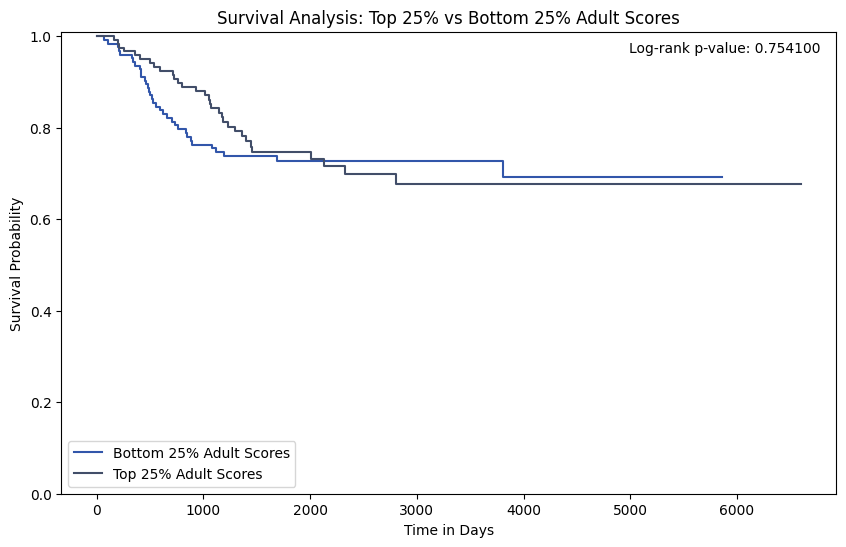

In [179]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['adult_scores'] >= data['adult_scores'].quantile(0.75)]
bottom_25 = data[data['adult_scores'] <= data['adult_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Adult Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Adult Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Adult Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/adult_km.svg', format='svg', bbox_inches='tight')

plt.show()

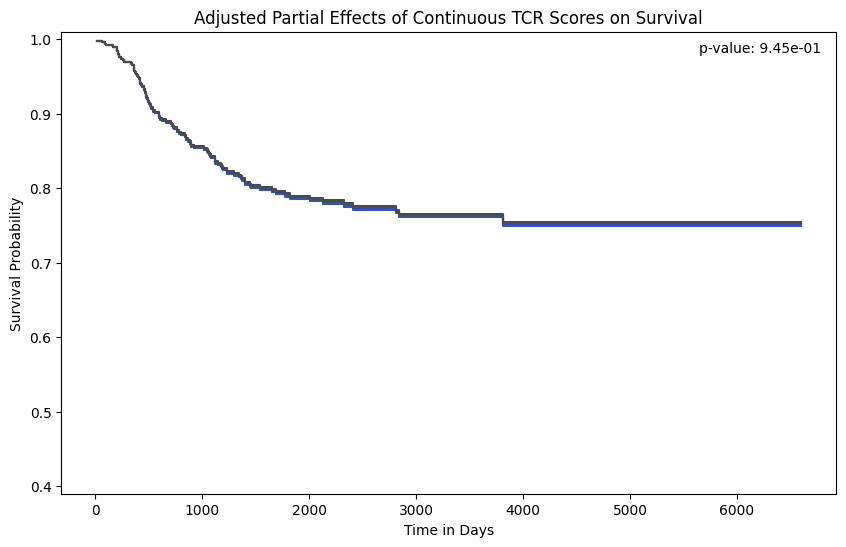

In [180]:
# Prepare the data frame for analysis, including necessary predictors
cox_data = data[['os days', 'os bin', 'adult_scores']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with tcr_scores as the sole covariate
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="adult_scores")

# Plotting the effect of tcr_scores on survival
values = [
    cox_data['adult_scores'].quantile(0.05), 
    cox_data['adult_scores'].quantile(0.25), 
    cox_data['adult_scores'].median(), 
    cox_data['adult_scores'].quantile(0.75), 
    cox_data['adult_scores'].quantile(0.95)
]

# Custom colors from dark grey to deep blue
colors = ["#2A5ACB", "#4A4A4A"]  # blue to grey
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plotting the partial effects
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot_partial_effects_on_outcome(
    covariates='adult_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Applying custom colors to the plot
)

plt.ylim(0.39, 1.01)  # Set y-axis range from 0 to 1

plt.title('Adjusted Partial Effects of Continuous TCR Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the tcr_scores from the Cox model summary
p_value = cph.summary.loc['adult_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/adult_cph.svg', format='svg', bbox_inches='tight')

plt.show()


## CD8 Fetal Signature

In [181]:
# Read the gene list from the file
with open("dataset/cd8_top_50_de_fetus_genes.csv", 'r') as file:
    gene_list = file.read().splitlines()
    
gene_list

['RPL41',
 'EEF1A1',
 'RPL10',
 'RPS27',
 'RPS15A',
 'RPL13',
 'H3-3B',
 'RPS10',
 'MALAT1',
 'RPLP1',
 'B2M',
 'RPL39',
 'RPS12',
 'TMSB4X',
 'RPS24',
 'H3-3A',
 'RPL28',
 'RPS18',
 'RPL32',
 'RPL34',
 'TPT1',
 'RPS4X',
 'RPL26',
 'RPS3',
 'RPL37',
 'RPS23',
 'RPL19',
 'RPL11',
 'RPS8',
 'MT-CO1',
 'RPL18A',
 'RPS19',
 'RPS6',
 'RPS28',
 'RPS3A',
 'RPS27A',
 'RPL3',
 'RPL29',
 'RPL12',
 'RPL15',
 'RPS14',
 'RPL30',
 'RPL37A',
 'RPS15',
 'RPS13',
 'RPL23A',
 'RPLP2',
 'RPL35A',
 'RPL7A',
 'RPS7']

In [182]:
# List of Fetal signature genes
cd8_fetal_genes = gene_list

# Calculate fetal signature scores for each sample
cd8_fetal_scores = gene_data[gene_data['Gene'].isin(cd8_fetal_genes)].iloc[:, 8:].mean(axis=0)
cd8_fetal_scores.name = 'cd8_fetal_scores'

# Combine fetal scores with metadata
data['cd8_fetal_scores'] = data['Sample ID'].map(cd8_fetal_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['cd8_fetal_scores'], inplace=True)

In [183]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  ADRB1_expression  ADRB2_expression  \
0            24.7943  ...            0.0000           14.3614   
1            25.2958  ...            8.1209           12.7041   
2            24.5375  ...            8.5208            9.7105   
3            24.6351  ...            6.8402           13.4866   
4            24.9948  ...            0.0000           11.6505   
..               ...  ...               ...               ...   
493          25.4461  ...            9.3716           15.3519   
494          25.1602  ...            9.2485           16.1540   
495          25.1211  ...            7.8735           12.8784   
496          24.7802  ...            6.8155           15.4167   
497          25.0471  ...            9.6810           15.1066   

     ADRB3_expression  tcr_scores  tcr2_genes  TCF7_expression  \
0              0.0000   18.351773   18.792294          19.4520   
1              9.0355   17.641285   18.460935          17.2688   
2              9.4976   15.599100   17.180075          14.0032   
3              9.4368   17.009327   18.224309          16.2404   
4              9.7566   16.168304   17.749510          15.4910   
..                ...         ...         ...              ...   
493           12.0438   17.259510   18.457485          17.0738   
494           10.8068   17.690890   18.724011          18.0551   
495            9.4285   16.512125   18.053765          16.8025   
496            9.4045   17.547460   18.439331          17.3541   
497            9.2748   18.210696   18.875753          18.6965   

     GZMB_expression  fetal_scores  adult_scores  cd8_fetal_scores  
0            14.9177     22.061426     20.659126         21.755825  
1            14.6264     21.530313     20.164260         21.118729  
2             0.0000     22.852096     19.443766         22.699079  
3            13.5640     22.087991     19.819886         21.769188  
4            12.1035     22.680917     19.643209         22.423408  
..               ...           ...           ...               ...  
493          13.1696     21.967517     20.530480         21.630346  
494          16.4249     21.789235     20.483954         21.456987  
495          11.9335     22.003226     20.358329         21.730987  
496          14.4890     21.809113     20.033557         21.461129  
497          14.1804     21

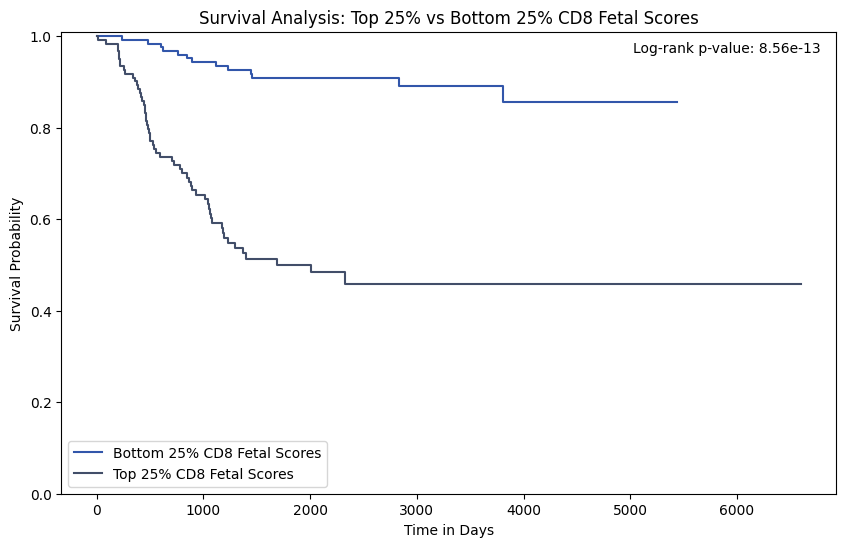

In [184]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['cd8_fetal_scores'] >= data['cd8_fetal_scores'].quantile(0.75)]
bottom_25 = data[data['cd8_fetal_scores'] <= data['cd8_fetal_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD8 Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD8 Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD8 Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_cd8_km.svg', format='svg', bbox_inches='tight')

plt.show()

### Adult

In [185]:
# Read the gene list from the file
with open("dataset/cd8_top_50_de_adult_genes.csv", 'r') as file:
    adult_gene_list = file.read().splitlines()
    
adult_gene_list

['H3F3B',
 'TXNIP',
 'CD8B',
 'H3F3A',
 'FP236383.3',
 'KLF2',
 'PNRC1',
 'DDX5',
 'RBFOX2',
 'APOO',
 'S100A6',
 'PTPRCAP',
 'ITM2B',
 'FXYD5',
 'RPL36AL',
 'RPS4Y1',
 'TLE5',
 'PFDN5',
 'TOMM7',
 'HLA-E',
 'LINC01578',
 'PCED1B-AS1',
 'TSC22D3',
 'H1FX',
 'S100A4',
 'CALM1',
 'CYBA',
 'CIRBP',
 'COMMD6',
 'ZFP36L2',
 'C12orf57',
 'MYL12A',
 'SH3BGRL3',
 'HCST',
 'HNRNPDL',
 'HIST1H1E',
 'SRSF5',
 'MZT2B',
 'AC138123.1',
 'C9orf16',
 'PPDPF',
 'S100A10',
 'ATP5MD',
 'DAZAP2',
 'CD48',
 'FP671120.4',
 'EEF1D',
 'HLA-C',
 'CD3E',
 'EIF3K']

In [186]:
# List of Fetal signature genes
cd8_adult_genes = adult_gene_list

# Calculate fetal signature scores for each sample
cd8_adult_scores = gene_data[gene_data['Gene'].isin(cd8_adult_genes)].iloc[:, 8:].mean(axis=0)
cd8_adult_scores.name = 'cd8_adult_scores'

# Combine fetal scores with metadata
data['cd8_adult_scores'] = data['Sample ID'].map(cd8_adult_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['cd8_adult_scores'], inplace=True)

In [187]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  ADRB2_expression  ADRB3_expression  tcr_scores  \
0            24.7943  ...           14.3614            0.0000   18.351773   
1            25.2958  ...           12.7041            9.0355   17.641285   
2            24.5375  ...            9.7105            9.4976   15.599100   
3            24.6351  ...           13.4866            9.4368   17.009327   
4            24.9948  ...           11.6505            9.7566   16.168304   
..               ...  ...               ...               ...         ...   
493          25.4461  ...           15.3519           12.0438   17.259510   
494          25.1602  ...           16.1540           10.8068   17.690890   
495          25.1211  ...           12.8784            9.4285   16.512125   
496          24.7802  ...           15.4167            9.4045   17.547460   
497          25.0471  ...           15.1066            9.2748   18.210696   

     tcr2_genes  TCF7_expression  GZMB_expression  fetal_scores  adult_scores  \
0     18.792294          19.4520          14.9177     22.061426     20.659126   
1     18.460935          17.2688          14.6264     21.530313     20.164260   
2     17.180075          14.0032           0.0000     22.852096     19.443766   
3     18.224309          16.2404          13.5640     22.087991     19.819886   
4     17.749510          15.4910          12.1035     22.680917     19.643209   
..          ...              ...              ...           ...           ...   
493   18.457485          17.0738          13.1696     21.967517     20.530480   
494   18.724011          18.0551          16.4249     21.789235     20.483954   
495   18.053765          16.8025          11.9335     22.003226     20.358329   
496   18.439331          17.3541          14.4890     21.809113     20.033557   
497   18.875753          18.6965          14.1804     21.924391     20.352874   

     cd8_fetal_scores  cd8_adult_scores  
0           21.755825         20.381041  
1           21.118729         19.787018  
2           22.699079         18.640165  
3           21.769188         19.288141  
4           22.423408         18.962847  
..                ...               ...  
493         21.630346         20.111756  
494         21.456987         20.140562  
495         21.730987         19.701997  
496         21.461129         19.643462  


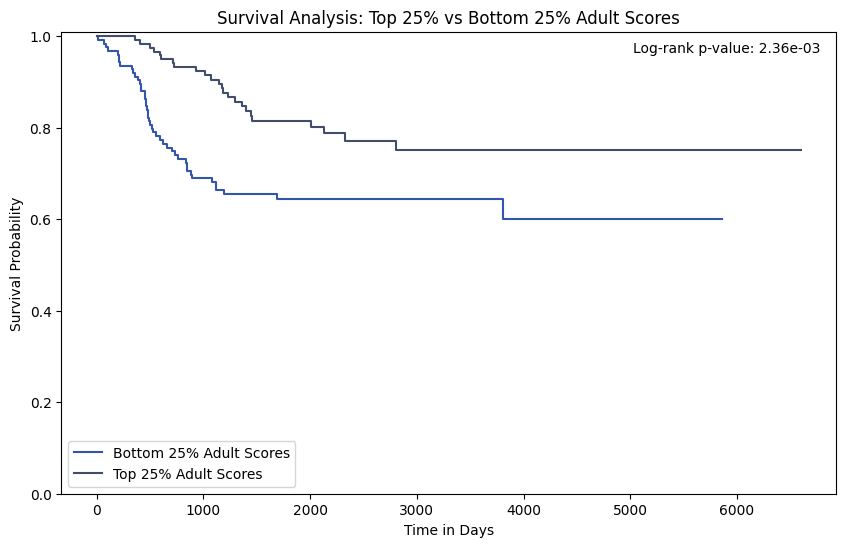

In [188]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['cd8_adult_scores'] >= data['cd8_adult_scores'].quantile(0.75)]
bottom_25 = data[data['cd8_adult_scores'] <= data['cd8_adult_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Adult Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Adult Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Adult Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/adult_km.svg', format='svg', bbox_inches='tight')

plt.show()

## Top 100 Genes T-Cells Fetal Signature

In [189]:
# Read the gene list from the file
with open("dataset/top_100_de_fetus_genes.csv", 'r') as file:
    fetal_100_gene_list = file.read().splitlines()
    
fetal_100_gene_list

['RPL41',
 'EEF1A1',
 'RPS27',
 'B2M',
 'H3-3B',
 'RPL10',
 'MALAT1',
 'RPS15A',
 'MT-CO1',
 'RPL13',
 'RPLP1',
 'TMSB4X',
 'H3-3A',
 'RPS10',
 'RPS18',
 'TPT1',
 'RPS3',
 'RPS24',
 'RPL39',
 'RPS4X',
 'RPL26',
 'RPL37',
 'RPL28',
 'RPL34',
 'RPS19',
 'RPL32',
 'RPS28',
 'RPS12',
 'RPL18A',
 'RPS23',
 'RPS27A',
 'RPS6',
 'RPL19',
 'RPS14',
 'RPL15',
 'RPL3',
 'MT-CO2',
 'RPL11',
 'RPS3A',
 'RPL23A',
 'HSP90AA1',
 'RPS15',
 'ACTB',
 'RPL30',
 'RPS8',
 'RPS29',
 'RPLP2',
 'ENSG00000289901',
 'BBLN',
 'RPL29',
 'RPL37A',
 'CYRIB',
 'HSPA1B',
 'MT-CO3',
 'RPL12',
 'RPL35A',
 'ATP5MJ',
 'HSPA1A',
 'ATP5MK',
 'RPS7',
 'HSPH1',
 'RPL7A',
 'PTMA',
 'RPL18',
 'RACK1',
 'RPS13',
 'H2AZ1',
 'RPL17',
 'HSPD1',
 'ACTG1',
 'RPL9',
 'RPL21',
 'RPS21',
 'HSPE1',
 'RPS25',
 'RPSA2',
 'TMSB10',
 'RPS9',
 'HLA-B',
 'MT-ATP6',
 'GPX1',
 'H2AZ2',
 'CACYBP',
 'PCBP2',
 'KLRB1',
 'NHERF1',
 'RPL36',
 'NR4A1',
 'RPL6',
 'MT-ND3',
 'RPS16',
 'RPL10A',
 'MATR3',
 'NKG7',
 'DNAJB1',
 'RGS2',
 'H4C3',
 'PFN1',
 '

In [190]:
# List of Fetal signature genes
fetal_genes = fetal_100_gene_list

# Calculate fetal signature scores for each sample
fetal_100genes_scores = gene_data[gene_data['Gene'].isin(fetal_genes)].iloc[:, 8:].mean(axis=0)
fetal_100genes_scores.name = 'fetal_100genes_scores'

# Combine fetal scores with metadata
data['fetal_100genes_scores'] = data['Sample ID'].map(fetal_100genes_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetal_100genes_scores'], inplace=True)

In [191]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  ADRB3_expression  tcr_scores  tcr2_genes  \
0            24.7943  ...            0.0000   18.351773   18.792294   
1            25.2958  ...            9.0355   17.641285   18.460935   
2            24.5375  ...            9.4976   15.599100   17.180075   
3            24.6351  ...            9.4368   17.009327   18.224309   
4            24.9948  ...            9.7566   16.168304   17.749510   
..               ...  ...               ...         ...         ...   
493          25.4461  ...           12.0438   17.259510   18.457485   
494          25.1602  ...           10.8068   17.690890   18.724011   
495          25.1211  ...            9.4285   16.512125   18.053765   
496          24.7802  ...            9.4045   17.547460   18.439331   
497          25.0471  ...            9.2748   18.210696   18.875753   

     TCF7_expression  GZMB_expression  fetal_scores  adult_scores  \
0            19.4520          14.9177     22.061426     20.659126   
1            17.2688          14.6264     21.530313     20.164260   
2            14.0032           0.0000     22.852096     19.443766   
3            16.2404          13.5640     22.087991     19.819886   
4            15.4910          12.1035     22.680917     19.643209   
..               ...              ...           ...           ...   
493          17.0738          13.1696     21.967517     20.530480   
494          18.0551          16.4249     21.789235     20.483954   
495          16.8025          11.9335     22.003226     20.358329   
496          17.3541          14.4890     21.809113     20.033557   
497          18.6965          14.1804     21.924391     20.352874   

     cd8_fetal_scores  cd8_adult_scores  fetal_100genes_scores  
0           21.755825         20.381041              21.271045  
1           21.118729         19.787018              20.904457  
2           22.699079         18.640165              21.654889  
3           21.769188         19.288141              21.323594  
4           22.423408         18.962847              21.743247  
..                ...               ...                    ...  
493         21.630346         20.111756              21.335821  
494         21.456987         20.140562              21.195447  
495         21.730987         19.701997              21.401309  
496         21.461129       

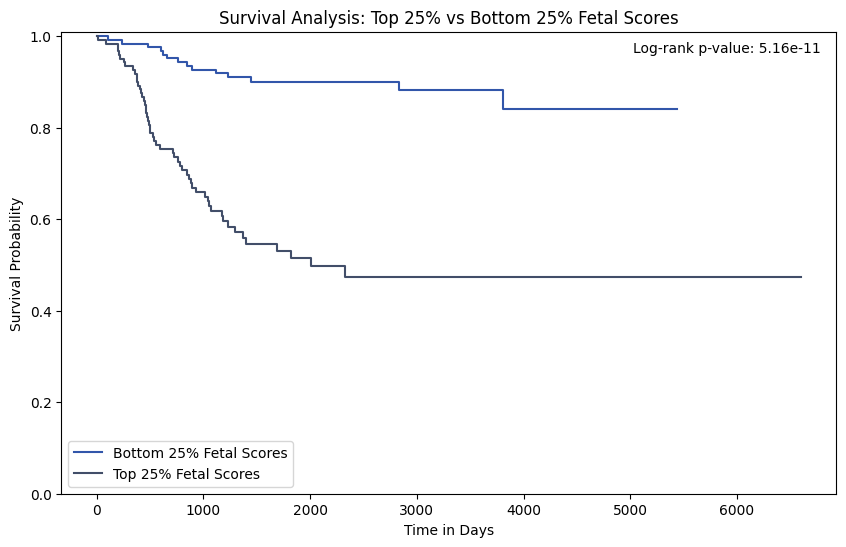

In [192]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetal_100genes_scores'] >= data['fetal_100genes_scores'].quantile(0.75)]
bottom_25 = data[data['fetal_100genes_scores'] <= data['fetal_100genes_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_km.svg', format='svg', bbox_inches='tight')

plt.show()

### Adult

In [193]:
# Read the gene list from the file
with open("dataset/top_100_de_adult_genes.csv", 'r') as file:
    adult_100_gene_list = file.read().splitlines()
    
adult_100_gene_list

['H3F3B',
 'FP236383.3',
 'KLF2',
 'TXNIP',
 'H3F3A',
 'PNRC1',
 'RBFOX2',
 'APOO',
 'DDX5',
 'ITM2B',
 'S100A6',
 'FXYD5',
 'RPS4Y1',
 'TLE5',
 'PFDN5',
 'PTPRCAP',
 'H1FX',
 'RPL36AL',
 'TOMM7',
 'C12orf57',
 'LINC01578',
 'ZFP36L2',
 'PCED1B-AS1',
 'TSC22D3',
 'COMMD6',
 'MZT2B',
 'SRSF5',
 'VIM',
 'COX4I1',
 'CIRBP',
 'HNRNPDL',
 'AC138123.1',
 'HIST1H1E',
 'EEF1D',
 'HLA-E',
 'C9orf16',
 'EIF3K',
 'ATP5MD',
 'FP671120.4',
 'DAZAP2',
 'CD48',
 'H2AFZ',
 'GSTK1',
 'YPEL3',
 'PPDPF',
 'ATP5MPL',
 'SH3BGRL3',
 'SNRPD2',
 'S100A10',
 'TAF10',
 'HIST1H4C',
 'SF1',
 'CNBP',
 'S100A4',
 'CD3E',
 'CALM1',
 'ETS1',
 'EMP3',
 'SLC9A3R1',
 'VAMP2',
 'TSPO',
 'BTG1',
 'CD37',
 'MATR3.1',
 'SON',
 'IL7R',
 'SKP1',
 'RPS20',
 'MBNL1',
 'NOP53',
 'AC243960.1',
 'H2AFV',
 'PTP4A2',
 'FYB1',
 'GMFG',
 'SELL',
 'MYL12A',
 'COX6C',
 'MYL12B',
 'NDUFA4',
 'GPSM3',
 'LAPTM5',
 'ATP5MC2',
 'SRP14',
 'SNHG6',
 'GAS5',
 'YWHAZ',
 'LDHB',
 'DUSP1',
 'RIPOR2',
 'ANXA1',
 'NOSIP',
 'PYURF',
 'ATP6V1G1',
 'SS

In [194]:
# List of Fetal signature genes
adult_genes = adult_100_gene_list

# Calculate fetal signature scores for each sample
adult_100genes_scores = gene_data[gene_data['Gene'].isin(adult_genes)].iloc[:, 8:].mean(axis=0)
adult_100genes_scores.name = 'adult_100genes_scores'

# Combine fetal scores with metadata
data['adult_100genes_scores'] = data['Sample ID'].map(adult_100genes_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['adult_100genes_scores'], inplace=True)

In [195]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  tcr_scores  tcr2_genes  TCF7_expression  \
0            24.7943  ...   18.351773   18.792294          19.4520   
1            25.2958  ...   17.641285   18.460935          17.2688   
2            24.5375  ...   15.599100   17.180075          14.0032   
3            24.6351  ...   17.009327   18.224309          16.2404   
4            24.9948  ...   16.168304   17.749510          15.4910   
..               ...  ...         ...         ...              ...   
493          25.4461  ...   17.259510   18.457485          17.0738   
494          25.1602  ...   17.690890   18.724011          18.0551   
495          25.1211  ...   16.512125   18.053765          16.8025   
496          24.7802  ...   17.547460   18.439331          17.3541   
497          25.0471  ...   18.210696   18.875753          18.6965   

     GZMB_expression  fetal_scores  adult_scores  cd8_fetal_scores  \
0            14.9177     22.061426     20.659126         21.755825   
1            14.6264     21.530313     20.164260         21.118729   
2             0.0000     22.852096     19.443766         22.699079   
3            13.5640     22.087991     19.819886         21.769188   
4            12.1035     22.680917     19.643209         22.423408   
..               ...           ...           ...               ...   
493          13.1696     21.967517     20.530480         21.630346   
494          16.4249     21.789235     20.483954         21.456987   
495          11.9335     22.003226     20.358329         21.730987   
496          14.4890     21.809113     20.033557         21.461129   
497          14.1804     21.924391     20.352874         21.607646   

     cd8_adult_scores  fetal_100genes_scores  adult_100genes_scores  
0           20.381041              21.271045              20.411157  
1           19.787018              20.904457              19.591739  
2           18.640165              21.654889              19.338214  
3           19.288141              21.323594              19.705299  
4           18.962847              21.743247              19.605241  
..                ...                    ...                    ...  
493         20.111756              21.335821              19.919627  
494         20.140562              21.195447              19.681593  
495         19.701997              21.401309    

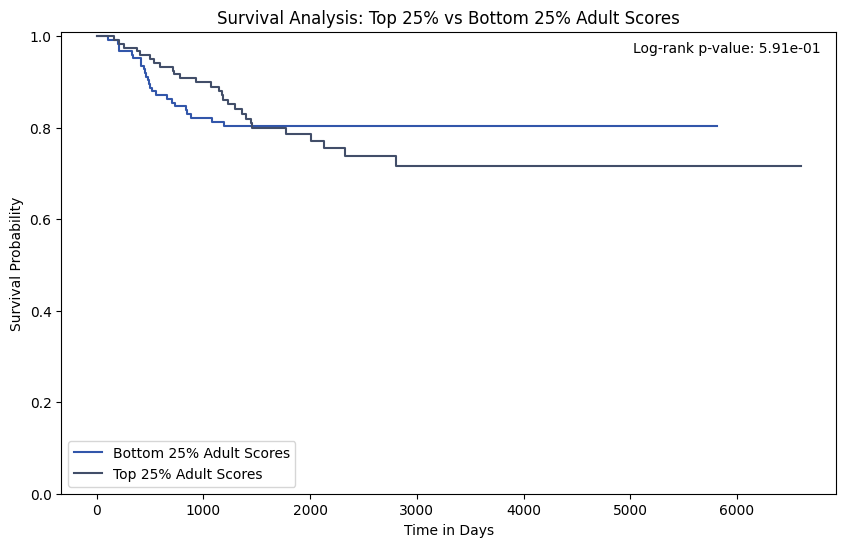

In [196]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['adult_100genes_scores'] >= data['adult_100genes_scores'].quantile(0.75)]
bottom_25 = data[data['adult_100genes_scores'] <= data['adult_100genes_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Adult Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Adult Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Adult Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/adult_100_km.svg', format='svg', bbox_inches='tight')

plt.show()

## CD4 Fetal Signature

In [197]:
# Read the gene list from the file
with open("dataset/cd4_top_50_de_fetus_genes.csv", 'r') as file:
    gene_list = file.read().splitlines()
    
gene_list

['EEF1A1',
 'H3-3B',
 'RPL41',
 'MALAT1',
 'B2M',
 'TMSB4X',
 'MT-CO1',
 'RPL10',
 'RPS27',
 'RPS10',
 'RPL28',
 'H3-3A',
 'RPS15A',
 'RPL13',
 'TPT1',
 'RPLP1',
 'RPS24',
 'RPL39',
 'RPS4X',
 'RPL37',
 'RPS12',
 'RPL32',
 'RPL26',
 'MT-CO2',
 'RPS3',
 'TMSB10',
 'RPL34',
 'RPS28',
 'ACTB',
 'RPL18A',
 'RPL11',
 'RPS18',
 'RPS8',
 'RPL19',
 'RPS23',
 'RPS19',
 'RPL30',
 'RPS3A',
 'RPS15',
 'PTMA',
 'RPL12',
 'RPS13',
 'RPS27A',
 'MT-CO3',
 'BBLN',
 'RPS6',
 'RPL15',
 'ACTG1',
 'RPL29',
 'RPS14']

In [198]:
# List of Fetal signature genes
cd4_fetal_genes = gene_list

# Calculate fetal signature scores for each sample
cd4_fetal_scores = gene_data[gene_data['Gene'].isin(cd4_fetal_genes)].iloc[:, 8:].mean(axis=0)
cd4_fetal_scores.name = 'cd4_fetal_scores'

# Combine fetal scores with metadata
data['cd4_fetal_scores'] = data['Sample ID'].map(cd4_fetal_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['cd4_fetal_scores'], inplace=True)

In [199]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  tcr2_genes  TCF7_expression  GZMB_expression  \
0            24.7943  ...   18.792294          19.4520          14.9177   
1            25.2958  ...   18.460935          17.2688          14.6264   
2            24.5375  ...   17.180075          14.0032           0.0000   
3            24.6351  ...   18.224309          16.2404          13.5640   
4            24.9948  ...   17.749510          15.4910          12.1035   
..               ...  ...         ...              ...              ...   
493          25.4461  ...   18.457485          17.0738          13.1696   
494          25.1602  ...   18.724011          18.0551          16.4249   
495          25.1211  ...   18.053765          16.8025          11.9335   
496          24.7802  ...   18.439331          17.3541          14.4890   
497          25.0471  ...   18.875753          18.6965          14.1804   

     fetal_scores  adult_scores  cd8_fetal_scores  cd8_adult_scores  \
0       22.061426     20.659126         21.755825         20.381041   
1       21.530313     20.164260         21.118729         19.787018   
2       22.852096     19.443766         22.699079         18.640165   
3       22.087991     19.819886         21.769188         19.288141   
4       22.680917     19.643209         22.423408         18.962847   
..            ...           ...               ...               ...   
493     21.967517     20.530480         21.630346         20.111756   
494     21.789235     20.483954         21.456987         20.140562   
495     22.003226     20.358329         21.730987         19.701997   
496     21.809113     20.033557         21.461129         19.643462   
497     21.924391     20.352874         21.607646         20.111941   

     fetal_100genes_scores  adult_100genes_scores  cd4_fetal_scores  
0                21.271045              20.411157         22.203144  
1                20.904457              19.591739         21.765908  
2                21.654889              19.338214         23.036496  
3                21.323594              19.705299         22.254420  
4                21.743247              19.605241         22.851544  
..                     ...                    ...               ...  
493              21.335821              19.919627         22.228668  
494              21.195447              19.681

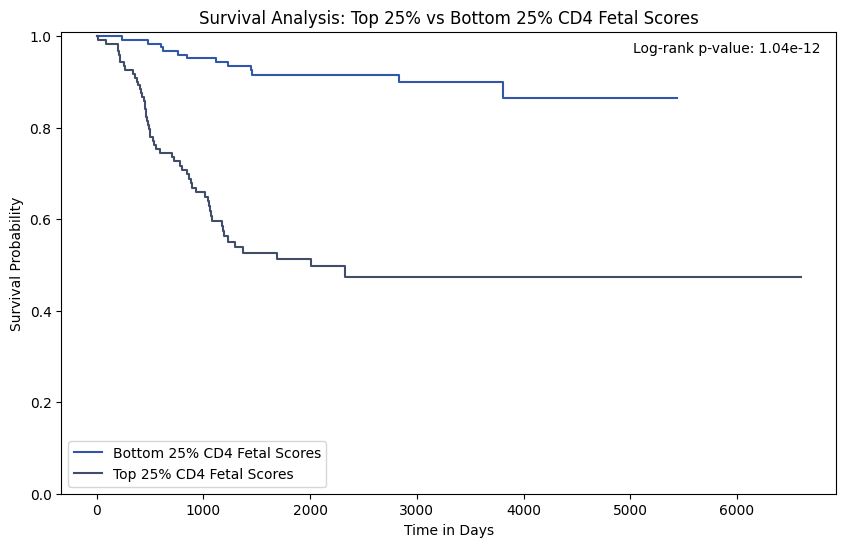

In [200]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['cd4_fetal_scores'] >= data['cd4_fetal_scores'].quantile(0.75)]
bottom_25 = data[data['cd4_fetal_scores'] <= data['cd4_fetal_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD4 Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD4 Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD4 Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_cd4_km.svg', format='svg', bbox_inches='tight')

plt.show()

### Adult

In [201]:
# Read the gene list from the file
with open("dataset/cd4_top_50_de_adult_genes.csv", 'r') as file:
    gene_list = file.read().splitlines()
    
gene_list

['H3F3B',
 'FP236383.3',
 'TXNIP',
 'H3F3A',
 'KLF2',
 'PNRC1',
 'APOO',
 'RBFOX2',
 'RPS4Y1',
 'H1FX',
 'ITM2B',
 'DDX5',
 'LINC01578',
 'PFDN5',
 'TOMM7',
 'TLE5',
 'PCED1B-AS1',
 'MZT2B',
 'PTPRCAP',
 'C12orf57',
 'CD4',
 'S100A6',
 'RPL36AL',
 'AC138123.1',
 'TSC22D3',
 'HNRNPDL',
 'COMMD6',
 'GAS5',
 'CD48',
 'SRSF5',
 'CIRBP',
 'EIF3K',
 'EEF1D',
 'ZFP36L2',
 'HIST1H1E',
 'COX4I1',
 'SNRPD2',
 'FP671120.4',
 'C9orf16',
 'H2AFZ',
 'RPS20',
 'NOP53',
 'ATP5MD',
 'GSTK1',
 'IL7R',
 'VIM',
 'YPEL3',
 'ETS1',
 'DAZAP2',
 'FYB1']

In [202]:
# List of Fetal signature genes
cd4_adult_genes = gene_list

# Calculate fetal signature scores for each sample
cd4_adult_scores = gene_data[gene_data['Gene'].isin(cd4_adult_genes)].iloc[:, 8:].mean(axis=0)
cd4_adult_scores.name = 'cd4_adult_scores'

# Combine fetal scores with metadata
data['cd4_adult_scores'] = data['Sample ID'].map(cd4_adult_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['cd4_adult_scores'], inplace=True)

In [203]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  TCF7_expression  GZMB_expression  fetal_scores  \
0            24.7943  ...          19.4520          14.9177     22.061426   
1            25.2958  ...          17.2688          14.6264     21.530313   
2            24.5375  ...          14.0032           0.0000     22.852096   
3            24.6351  ...          16.2404          13.5640     22.087991   
4            24.9948  ...          15.4910          12.1035     22.680917   
..               ...  ...              ...              ...           ...   
493          25.4461  ...          17.0738          13.1696     21.967517   
494          25.1602  ...          18.0551          16.4249     21.789235   
495          25.1211  ...          16.8025          11.9335     22.003226   
496          24.7802  ...          17.3541          14.4890     21.809113   
497          25.0471  ...          18.6965          14.1804     21.924391   

     adult_scores  cd8_fetal_scores  cd8_adult_scores  fetal_100genes_scores  \
0       20.659126         21.755825         20.381041              21.271045   
1       20.164260         21.118729         19.787018              20.904457   
2       19.443766         22.699079         18.640165              21.654889   
3       19.819886         21.769188         19.288141              21.323594   
4       19.643209         22.423408         18.962847              21.743247   
..            ...               ...               ...                    ...   
493     20.530480         21.630346         20.111756              21.335821   
494     20.483954         21.456987         20.140562              21.195447   
495     20.358329         21.730987         19.701997              21.401309   
496     20.033557         21.461129         19.643462              21.196036   
497     20.352874         21.607646         20.111941              21.372277   

     adult_100genes_scores  cd4_fetal_scores  cd4_adult_scores  
0                20.411157         22.203144         20.665953  
1                19.591739         21.765908         20.125725  
2                19.338214         23.036496         19.208900  
3                19.705299         22.254420         19.731466  
4                19.605241         22.851544         19.281569  
..                     ...               ...               ...  
493              19

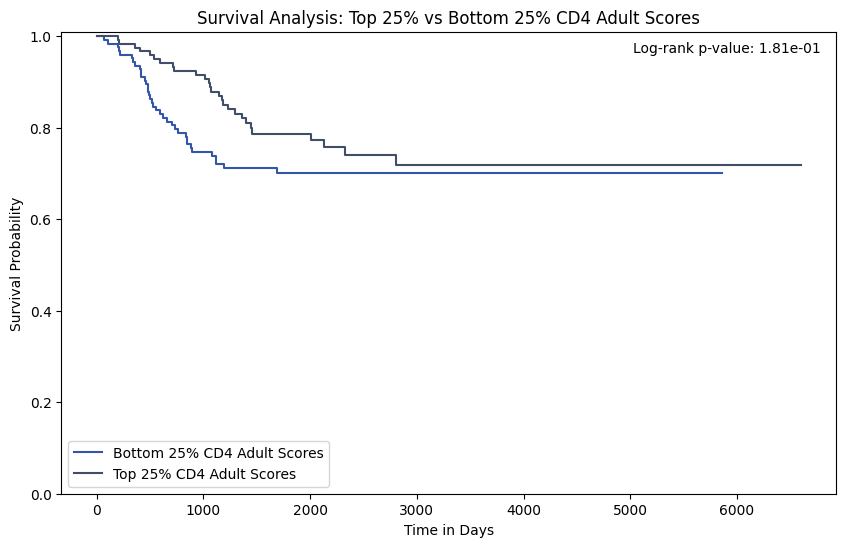

In [204]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['cd4_adult_scores'] >= data['cd4_adult_scores'].quantile(0.75)]
bottom_25 = data[data['cd4_adult_scores'] <= data['cd4_adult_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD4 Adult Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD4 Adult Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD4 Adult Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/adult_cd4_km.svg', format='svg', bbox_inches='tight')

plt.show()

## Filtered T-cells Fetus Signature

In [205]:
# Read the gene list from the file
with open("dataset/filtered_top_100_de_fetus_genes.csv", 'r') as file:
    gene_list = file.read().splitlines()
    
gene_list

['EEF1A1',
 'B2M',
 'H3-3B',
 'MALAT1',
 'MT-CO1',
 'TMSB4X',
 'H3-3A',
 'TPT1',
 'MT-CO2',
 'HSP90AA1',
 'ACTB',
 'ENSG00000289901',
 'BBLN',
 'CYRIB',
 'HSPA1B',
 'MT-CO3',
 'ATP5MJ',
 'HSPA1A',
 'ATP5MK',
 'HSPH1',
 'PTMA',
 'RACK1',
 'H2AZ1',
 'HSPD1',
 'ACTG1',
 'HSPE1',
 'TMSB10',
 'HLA-B',
 'MT-ATP6',
 'GPX1',
 'H2AZ2',
 'CACYBP',
 'PCBP2',
 'KLRB1',
 'NHERF1',
 'NR4A1',
 'MT-ND3',
 'MATR3',
 'NKG7',
 'DNAJB1',
 'RGS2',
 'H4C3',
 'PFN1',
 'PVRIG']

In [206]:
# List of Fetal signature genes
filtered_fetal_genes = gene_list

# Calculate fetal signature scores for each sample
filtered_fetal_scores = gene_data[gene_data['Gene'].isin(filtered_fetal_genes)].iloc[:, 8:].mean(axis=0)
filtered_fetal_scores.name = 'filtered_fetal_scores'

# Combine fetal scores with metadata
data['filtered_fetal_scores'] = data['Sample ID'].map(filtered_fetal_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['filtered_fetal_scores'], inplace=True)

In [207]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  GZMB_expression  fetal_scores  adult_scores  \
0            24.7943  ...          14.9177     22.061426     20.659126   
1            25.2958  ...          14.6264     21.530313     20.164260   
2            24.5375  ...           0.0000     22.852096     19.443766   
3            24.6351  ...          13.5640     22.087991     19.819886   
4            24.9948  ...          12.1035     22.680917     19.643209   
..               ...  ...              ...           ...           ...   
493          25.4461  ...          13.1696     21.967517     20.530480   
494          25.1602  ...          16.4249     21.789235     20.483954   
495          25.1211  ...          11.9335     22.003226     20.358329   
496          24.7802  ...          14.4890     21.809113     20.033557   
497          25.0471  ...          14.1804     21.924391     20.352874   

     cd8_fetal_scores  cd8_adult_scores  fetal_100genes_scores  \
0           21.755825         20.381041              21.271045   
1           21.118729         19.787018              20.904457   
2           22.699079         18.640165              21.654889   
3           21.769188         19.288141              21.323594   
4           22.423408         18.962847              21.743247   
..                ...               ...                    ...   
493         21.630346         20.111756              21.335821   
494         21.456987         20.140562              21.195447   
495         21.730987         19.701997              21.401309   
496         21.461129         19.643462              21.196036   
497         21.607646         20.111941              21.372277   

     adult_100genes_scores  cd4_fetal_scores  cd4_adult_scores  \
0                20.411157         22.203144         20.665953   
1                19.591739         21.765908         20.125725   
2                19.338214         23.036496         19.208900   
3                19.705299         22.254420         19.731466   
4                19.605241         22.851544         19.281569   
..                     ...               ...               ...   
493              19.919627         22.228668         20.474144   
494              19.681593         22.004884         20.497603   
495              19.682023         22.256172         20.275197   
496              1

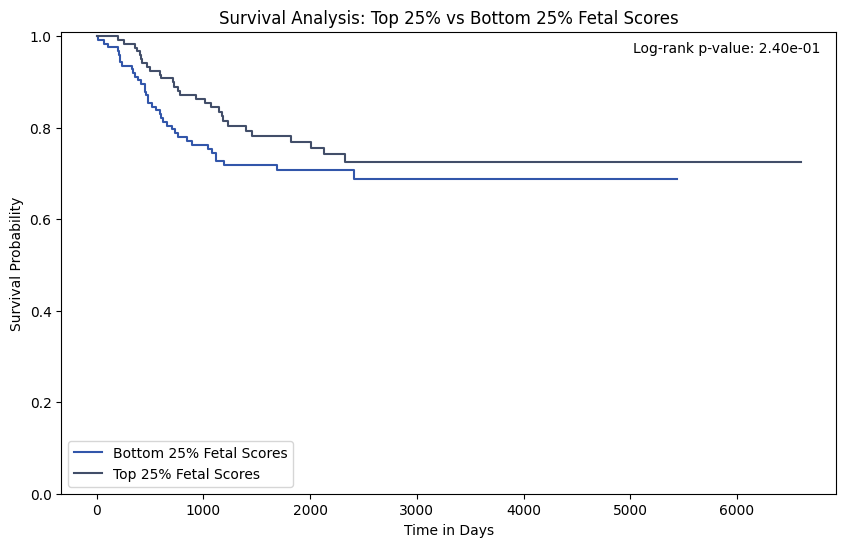

In [208]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['filtered_fetal_scores'] >= data['filtered_fetal_scores'].quantile(0.75)]
bottom_25 = data[data['filtered_fetal_scores'] <= data['filtered_fetal_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

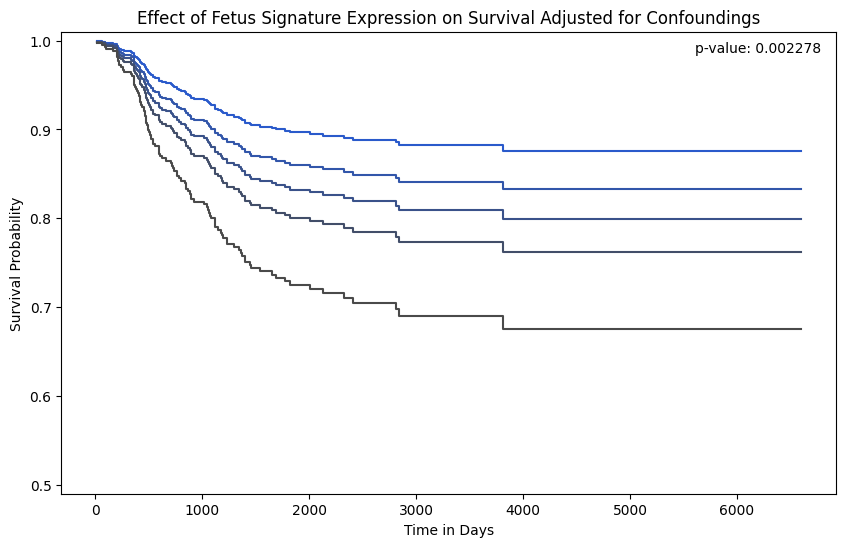

In [209]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'filtered_fetal_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="filtered_fetal_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['filtered_fetal_scores'].quantile(0.05), 
    cox_data['filtered_fetal_scores'].quantile(0.25), 
    cox_data['filtered_fetal_scores'].median(), 
    cox_data['filtered_fetal_scores'].quantile(0.75), 
    cox_data['filtered_fetal_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='filtered_fetal_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['filtered_fetal_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()


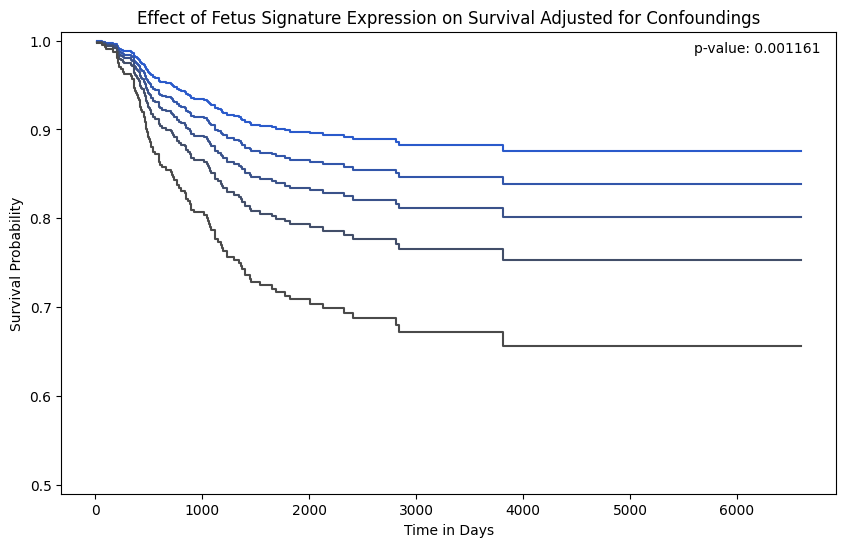

In [210]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'adult_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="adult_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['adult_scores'].quantile(0.05), 
    cox_data['adult_scores'].quantile(0.25), 
    cox_data['adult_scores'].median(), 
    cox_data['adult_scores'].quantile(0.75), 
    cox_data['adult_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='adult_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.49, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['adult_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/adult_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()


In [211]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  GZMB_expression  fetal_scores  adult_scores  \
0            24.7943  ...          14.9177     22.061426     20.659126   
1            25.2958  ...          14.6264     21.530313     20.164260   
2            24.5375  ...           0.0000     22.852096     19.443766   
3            24.6351  ...          13.5640     22.087991     19.819886   
4            24.9948  ...          12.1035     22.680917     19.643209   
..               ...  ...              ...           ...           ...   
493          25.4461  ...          13.1696     21.967517     20.530480   
494          25.1602  ...          16.4249     21.789235     20.483954   
495          25.1211  ...          11.9335     22.003226     20.358329   
496          24.7802  ...          14.4890     21.809113     20.033557   
497          25.0471  ...          14.1804     21.924391     20.352874   

     cd8_fetal_scores  cd8_adult_scores  fetal_100genes_scores  \
0           21.755825         20.381041              21.271045   
1           21.118729         19.787018              20.904457   
2           22.699079         18.640165              21.654889   
3           21.769188         19.288141              21.323594   
4           22.423408         18.962847              21.743247   
..                ...               ...                    ...   
493         21.630346         20.111756              21.335821   
494         21.456987         20.140562              21.195447   
495         21.730987         19.701997              21.401309   
496         21.461129         19.643462              21.196036   
497         21.607646         20.111941              21.372277   

     adult_100genes_scores  cd4_fetal_scores  cd4_adult_scores  \
0                20.411157         22.203144         20.665953   
1                19.591739         21.765908         20.125725   
2                19.338214         23.036496         19.208900   
3                19.705299         22.254420         19.731466   
4                19.605241         22.851544         19.281569   
..                     ...               ...               ...   
493              19.919627         22.228668         20.474144   
494              19.681593         22.004884         20.497603   
495              19.682023         22.256172         20.275197   
496              1

## Fetus Spleen Gene Signatures

In [212]:
# Read the gene list from the file
with open("dataset/top_100_genes_cd8ab_cluster_0.csv", 'r') as file:
    fetus_naive_gene_list = file.read().splitlines()
    
#fetus_naive_gene_list

In [213]:
# List of Fetal signature genes
fetus_naive_genes = fetus_naive_gene_list

# Calculate fetal signature scores for each sample
fetus_naive_scores = gene_data[gene_data['Gene'].isin(fetus_naive_genes)].iloc[:, 8:].mean(axis=0)
fetus_naive_scores.name = 'fetus_naive_scores'

# Combine fetal scores with metadata
data['fetus_naive_scores'] = data['Sample ID'].map(fetus_naive_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetus_naive_scores'], inplace=True)

In [214]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  fetal_scores  adult_scores  cd8_fetal_scores  \
0            24.7943  ...     22.061426     20.659126         21.755825   
1            25.2958  ...     21.530313     20.164260         21.118729   
2            24.5375  ...     22.852096     19.443766         22.699079   
3            24.6351  ...     22.087991     19.819886         21.769188   
4            24.9948  ...     22.680917     19.643209         22.423408   
..               ...  ...           ...           ...               ...   
493          25.4461  ...     21.967517     20.530480         21.630346   
494          25.1602  ...     21.789235     20.483954         21.456987   
495          25.1211  ...     22.003226     20.358329         21.730987   
496          24.7802  ...     21.809113     20.033557         21.461129   
497          25.0471  ...     21.924391     20.352874         21.607646   

     cd8_adult_scores  fetal_100genes_scores  adult_100genes_scores  \
0           20.381041              21.271045              20.411157   
1           19.787018              20.904457              19.591739   
2           18.640165              21.654889              19.338214   
3           19.288141              21.323594              19.705299   
4           18.962847              21.743247              19.605241   
..                ...                    ...                    ...   
493         20.111756              21.335821              19.919627   
494         20.140562              21.195447              19.681593   
495         19.701997              21.401309              19.682023   
496         19.643462              21.196036              19.910361   
497         20.111941              21.372277              20.195657   

     cd4_fetal_scores  cd4_adult_scores  filtered_fetal_scores  \
0           22.203144         20.665953              21.003937   
1           21.765908         20.125725              20.987905   
2           23.036496         19.208900              20.081663   
3           22.254420         19.731466              20.922758   
4           22.851544         19.281569              20.855305   
..                ...               ...                    ...   
493         22.228668         20.474144              21.309384   
494         22.004884         20.497603              21.205879   
495         

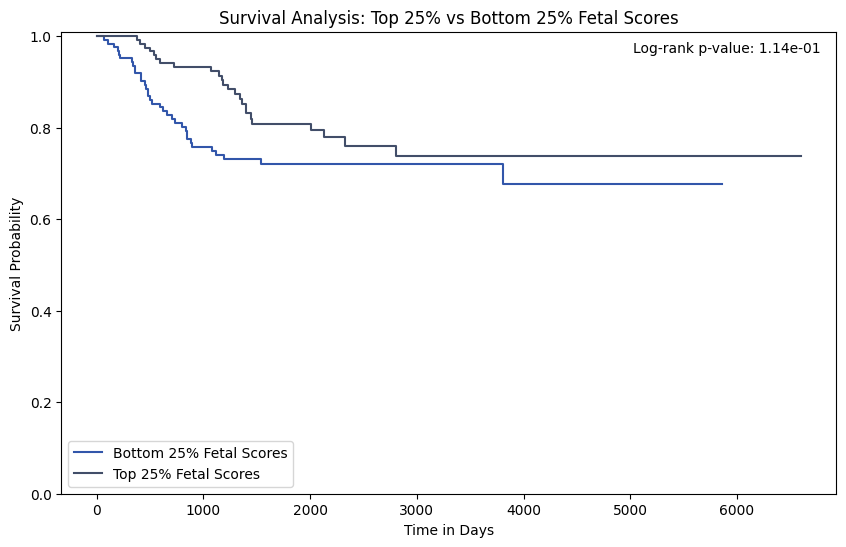

In [215]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetus_naive_scores'] >= data['fetus_naive_scores'].quantile(0.75)]
bottom_25 = data[data['fetus_naive_scores'] <= data['fetus_naive_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

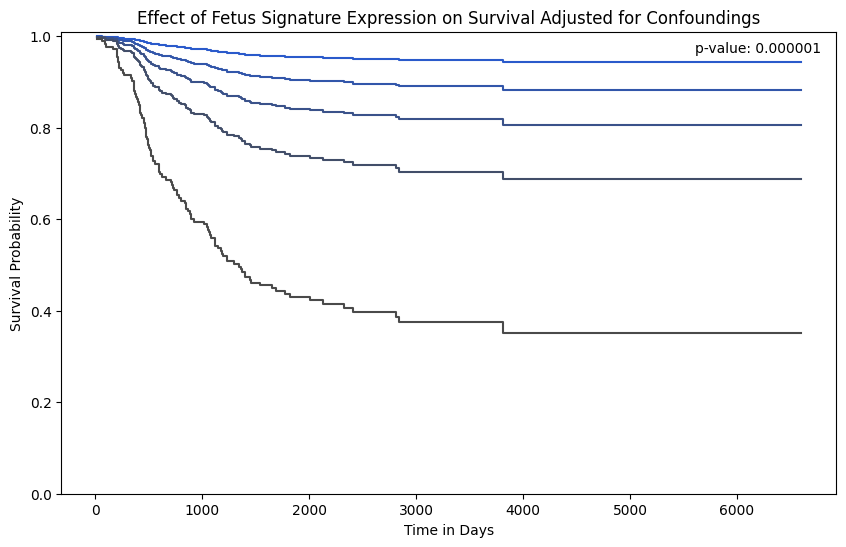

In [216]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_naive_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_naive_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_naive_scores'].quantile(0.05), 
    cox_data['fetus_naive_scores'].quantile(0.25), 
    cox_data['fetus_naive_scores'].median(), 
    cox_data['fetus_naive_scores'].quantile(0.75), 
    cox_data['fetus_naive_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_naive_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_naive_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()


In [217]:
# Read the gene list from the file
with open("dataset/top_100_genes_cd8ab_cluster_3.csv", 'r') as file:
    fetus_eff_gene_list = file.read().splitlines()
    
#fetus_naive_gene_list

In [218]:
# List of Fetal signature genes
fetus_eff_genes = fetus_eff_gene_list

# Calculate fetal signature scores for each sample
fetus_eff_scores = gene_data[gene_data['Gene'].isin(fetus_eff_genes)].iloc[:, 8:].mean(axis=0)
fetus_eff_scores.name = 'fetus_eff_scores'

# Combine fetal scores with metadata
data['fetus_eff_scores'] = data['Sample ID'].map(fetus_eff_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetus_eff_scores'], inplace=True)

In [219]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  adult_scores  cd8_fetal_scores  cd8_adult_scores  \
0            24.7943  ...     20.659126         21.755825         20.381041   
1            25.2958  ...     20.164260         21.118729         19.787018   
2            24.5375  ...     19.443766         22.699079         18.640165   
3            24.6351  ...     19.819886         21.769188         19.288141   
4            24.9948  ...     19.643209         22.423408         18.962847   
..               ...  ...           ...               ...               ...   
493          25.4461  ...     20.530480         21.630346         20.111756   
494          25.1602  ...     20.483954         21.456987         20.140562   
495          25.1211  ...     20.358329         21.730987         19.701997   
496          24.7802  ...     20.033557         21.461129         19.643462   
497          25.0471  ...     20.352874         21.607646         20.111941   

     fetal_100genes_scores  adult_100genes_scores  cd4_fetal_scores  \
0                21.271045              20.411157         22.203144   
1                20.904457              19.591739         21.765908   
2                21.654889              19.338214         23.036496   
3                21.323594              19.705299         22.254420   
4                21.743247              19.605241         22.851544   
..                     ...                    ...               ...   
493              21.335821              19.919627         22.228668   
494              21.195447              19.681593         22.004884   
495              21.401309              19.682023         22.256172   
496              21.196036              19.910361         22.010492   
497              21.372277              20.195657         22.125912   

     cd4_adult_scores  filtered_fetal_scores  fetus_naive_scores  \
0           20.665953              21.003937           19.609213   
1           20.125725              20.987905           18.841301   
2           19.208900              20.081663           18.568043   
3           19.731466              20.922758           18.943259   
4           19.281569              20.855305           18.740390   
..                ...                    ...                 ...   
493         20.474144              21.309384           19.035700   
494         20

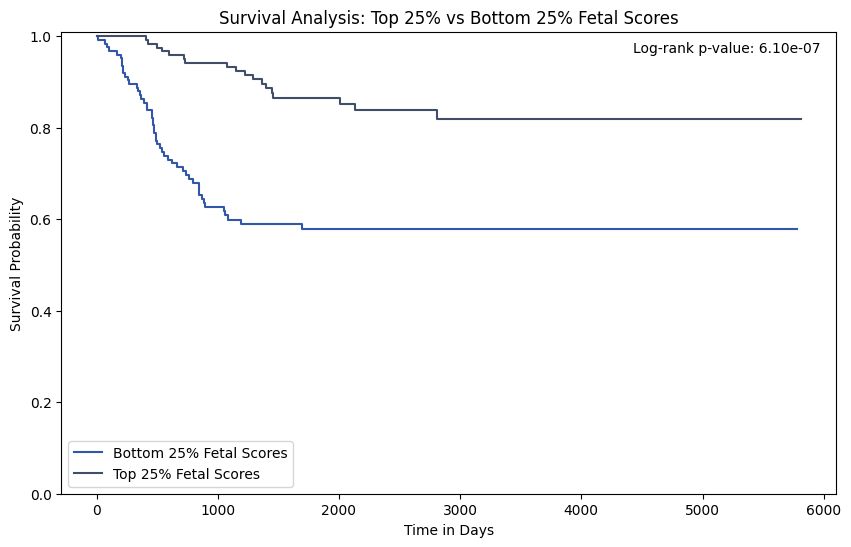

In [220]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetus_eff_scores'] >= data['fetus_eff_scores'].quantile(0.75)]
bottom_25 = data[data['fetus_eff_scores'] <= data['fetus_eff_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

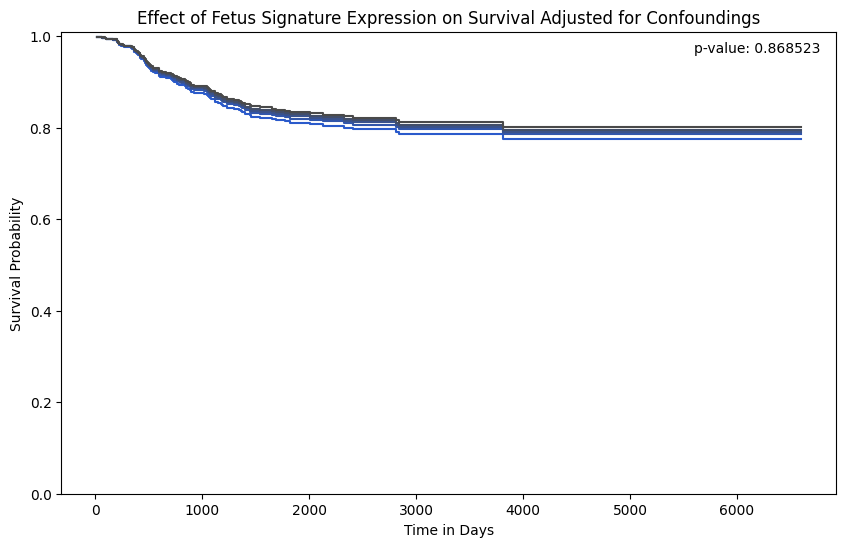

In [221]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_eff_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_eff_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_eff_scores'].quantile(0.05), 
    cox_data['fetus_eff_scores'].quantile(0.25), 
    cox_data['fetus_eff_scores'].median(), 
    cox_data['fetus_eff_scores'].quantile(0.75), 
    cox_data['fetus_eff_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_eff_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_eff_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

In [235]:
# Read the gene list from the file
with open("dataset/top_100_genes_cd8_cluster_4.csv", 'r') as file:
    fetus_effector_gene_list = file.read().splitlines()
    
#fetus_effector_gene_list

In [236]:
# List of Fetal signature genes
fetus_effector_genes = fetus_effector_gene_list

# Calculate fetal signature scores for each sample
fetus_effector_scores = gene_data[gene_data['Gene'].isin(fetus_effector_genes)].iloc[:, 8:].mean(axis=0)
fetus_effector_scores.name = 'fetus_effector_scores'

# Combine fetal scores with metadata
data['fetus_effector_scores'] = data['Sample ID'].map(fetus_effector_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetus_effector_scores'], inplace=True)

In [237]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  fetal_100genes_scores  adult_100genes_scores  \
0            24.7943  ...              21.271045              20.411157   
1            25.2958  ...              20.904457              19.591739   
2            24.5375  ...              21.654889              19.338214   
3            24.6351  ...              21.323594              19.705299   
4            24.9948  ...              21.743247              19.605241   
..               ...  ...                    ...                    ...   
493          25.4461  ...              21.335821              19.919627   
494          25.1602  ...              21.195447              19.681593   
495          25.1211  ...              21.401309              19.682023   
496          24.7802  ...              21.196036              19.910361   
497          25.0471  ...              21.372277              20.195657   

     cd4_fetal_scores  cd4_adult_scores  filtered_fetal_scores  \
0           22.203144         20.665953              21.003937   
1           21.765908         20.125725              20.987905   
2           23.036496         19.208900              20.081663   
3           22.254420         19.731466              20.922758   
4           22.851544         19.281569              20.855305   
..                ...               ...                    ...   
493         22.228668         20.474144              21.309384   
494         22.004884         20.497603              21.205879   
495         22.256172         20.275197              21.172195   
496         22.010492         20.018150              21.310279   
497         22.125912         20.328600              21.548300   

     fetus_naive_scores  fetus_eff_scores  fetus_effector_scores  \
0             19.609213         17.431620              17.263207   
1             18.841301         16.380105              16.319230   
2             18.568043         15.130395              14.971819   
3             18.943259         16.286468              16.543141   
4             18.740390         15.448838              15.922860   
..                  ...               ...                    ...   
493           19.035700         17.090534              16.909849   
494           19.150574         17.192776              17.225292   
495           18.788093         16.015423             

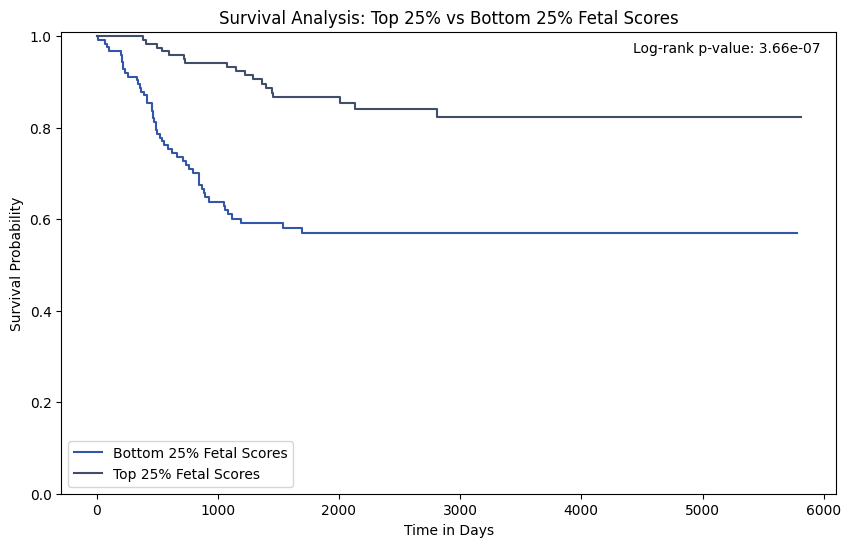

In [238]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetus_effector_scores'] >= data['fetus_effector_scores'].quantile(0.75)]
bottom_25 = data[data['fetus_effector_scores'] <= data['fetus_effector_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

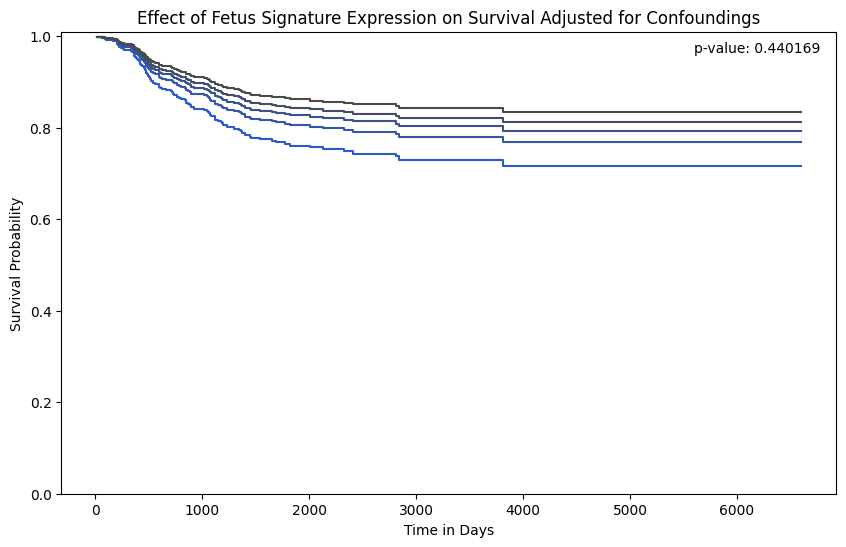

In [239]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_effector_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_effector_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_effector_scores'].quantile(0.05), 
    cox_data['fetus_effector_scores'].quantile(0.25), 
    cox_data['fetus_effector_scores'].median(), 
    cox_data['fetus_effector_scores'].quantile(0.75), 
    cox_data['fetus_effector_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_effector_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_effector_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

## Effector vs Naive

In [227]:
# Load the gene list from the TSV file
file_path = './dataset/GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_UP.v2023.2.Hs.tsv'
gene_list_df = pd.read_csv(file_path, sep='\t')

# Extract the gene symbols from the 'GENE_SYMBOLS' field
gene_symbols = gene_list_df.loc[gene_list_df['STANDARD_NAME'] == 'GENE_SYMBOLS', 'GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_UP'].values[0].split(',')

# Calculate fetal signature scores for each sample
naive_scores = gene_data[gene_data['Gene'].isin(gene_symbols)].iloc[:, 8:].mean(axis=0)
naive_scores.name = 'naive_scores'

# Combine fetal scores with metadata
data['naive_scores'] = data['Sample ID'].map(naive_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['naive_scores'], inplace=True)

In [228]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  cd8_adult_scores  fetal_100genes_scores  \
0            24.7943  ...         20.381041              21.271045   
1            25.2958  ...         19.787018              20.904457   
2            24.5375  ...         18.640165              21.654889   
3            24.6351  ...         19.288141              21.323594   
4            24.9948  ...         18.962847              21.743247   
..               ...  ...               ...                    ...   
493          25.4461  ...         20.111756              21.335821   
494          25.1602  ...         20.140562              21.195447   
495          25.1211  ...         19.701997              21.401309   
496          24.7802  ...         19.643462              21.196036   
497          25.0471  ...         20.111941              21.372277   

     adult_100genes_scores  cd4_fetal_scores  cd4_adult_scores  \
0                20.411157         22.203144         20.665953   
1                19.591739         21.765908         20.125725   
2                19.338214         23.036496         19.208900   
3                19.705299         22.254420         19.731466   
4                19.605241         22.851544         19.281569   
..                     ...               ...               ...   
493              19.919627         22.228668         20.474144   
494              19.681593         22.004884         20.497603   
495              19.682023         22.256172         20.275197   
496              19.910361         22.010492         20.018150   
497              20.195657         22.125912         20.328600   

     filtered_fetal_scores  fetus_naive_scores  fetus_eff_scores  \
0                21.003937           19.609213         17.431620   
1                20.987905           18.841301         16.380105   
2                20.081663           18.568043         15.130395   
3                20.922758           18.943259         16.286468   
4                20.855305           18.740390         15.448838   
..                     ...                 ...               ...   
493              21.309384           19.035700         17.090534   
494              21.205879           19.150574         17.192776   
495              21.172195           18.788093         16.015423   
496              21.310279           18.976422

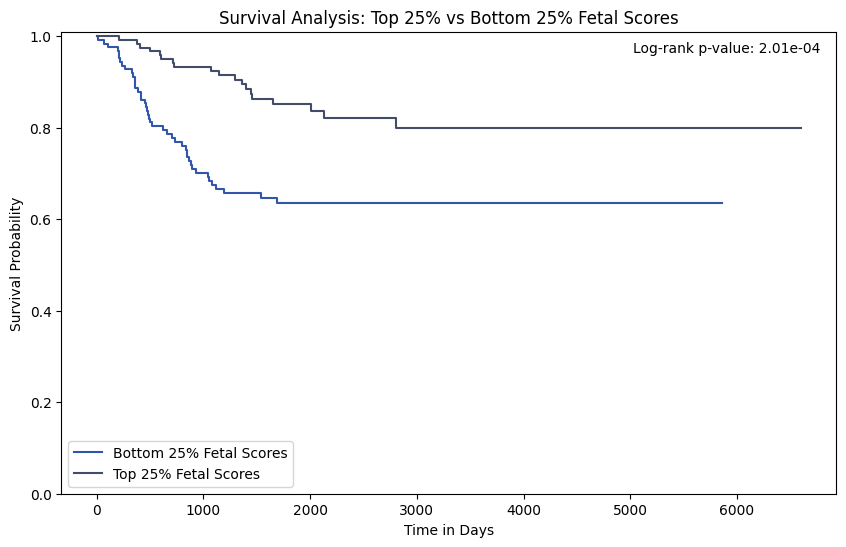

In [229]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['naive_scores'] >= data['naive_scores'].quantile(0.75)]
bottom_25 = data[data['naive_scores'] <= data['naive_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

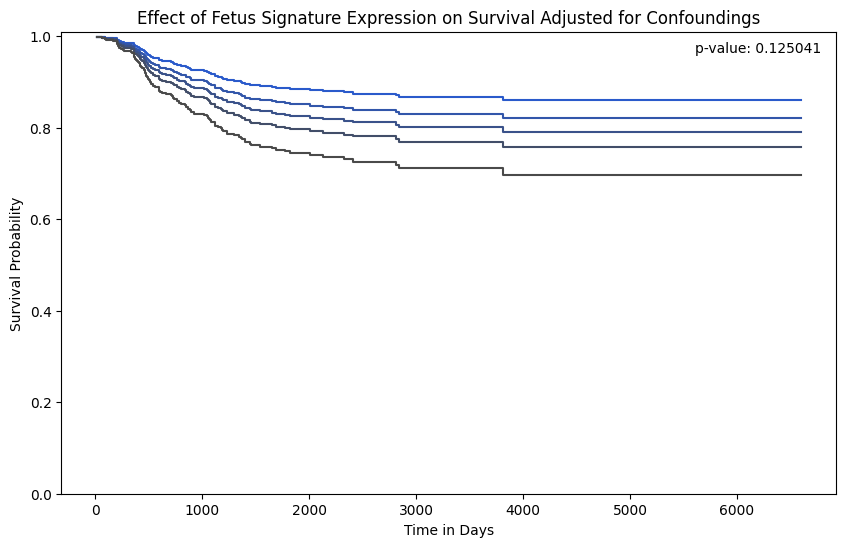

In [230]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'naive_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="naive_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['naive_scores'].quantile(0.05), 
    cox_data['naive_scores'].quantile(0.25), 
    cox_data['naive_scores'].median(), 
    cox_data['naive_scores'].quantile(0.75), 
    cox_data['naive_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='naive_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['naive_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

In [231]:
# Load the gene list from the TSV file
file_path = './dataset/GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN.v2023.2.Hs.tsv'
gene_list_df = pd.read_csv(file_path, sep='\t')

# Extract the gene symbols from the 'GENE_SYMBOLS' field
gene_symbols = gene_list_df.loc[gene_list_df['STANDARD_NAME'] == 'GENE_SYMBOLS', 'GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN'].values[0].split(',')

# Calculate fetal signature scores for each sample
naive_scores = gene_data[gene_data['Gene'].isin(gene_symbols)].iloc[:, 8:].mean(axis=0)
naive_scores.name = 'effector_scores'

# Combine fetal scores with metadata
data['effector_scores'] = data['Sample ID'].map(naive_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['effector_scores'], inplace=True)

In [232]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  fetal_100genes_scores  adult_100genes_scores  \
0            24.7943  ...              21.271045              20.411157   
1            25.2958  ...              20.904457              19.591739   
2            24.5375  ...              21.654889              19.338214   
3            24.6351  ...              21.323594              19.705299   
4            24.9948  ...              21.743247              19.605241   
..               ...  ...                    ...                    ...   
493          25.4461  ...              21.335821              19.919627   
494          25.1602  ...              21.195447              19.681593   
495          25.1211  ...              21.401309              19.682023   
496          24.7802  ...              21.196036              19.910361   
497          25.0471  ...              21.372277              20.195657   

     cd4_fetal_scores  cd4_adult_scores  filtered_fetal_scores  \
0           22.203144         20.665953              21.003937   
1           21.765908         20.125725              20.987905   
2           23.036496         19.208900              20.081663   
3           22.254420         19.731466              20.922758   
4           22.851544         19.281569              20.855305   
..                ...               ...                    ...   
493         22.228668         20.474144              21.309384   
494         22.004884         20.497603              21.205879   
495         22.256172         20.275197              21.172195   
496         22.010492         20.018150              21.310279   
497         22.125912         20.328600              21.548300   

     fetus_naive_scores  fetus_eff_scores  fetus_effector_scores  \
0             19.609213         17.431620              17.263207   
1             18.841301         16.380105              16.319230   
2             18.568043         15.130395              14.971819   
3             18.943259         16.286468              16.543141   
4             18.740390         15.448838              15.922860   
..                  ...               ...                    ...   
493           19.035700         17.090534              16.909849   
494           19.150574         17.192776              17.225292   
495           18.788093         16.015423             

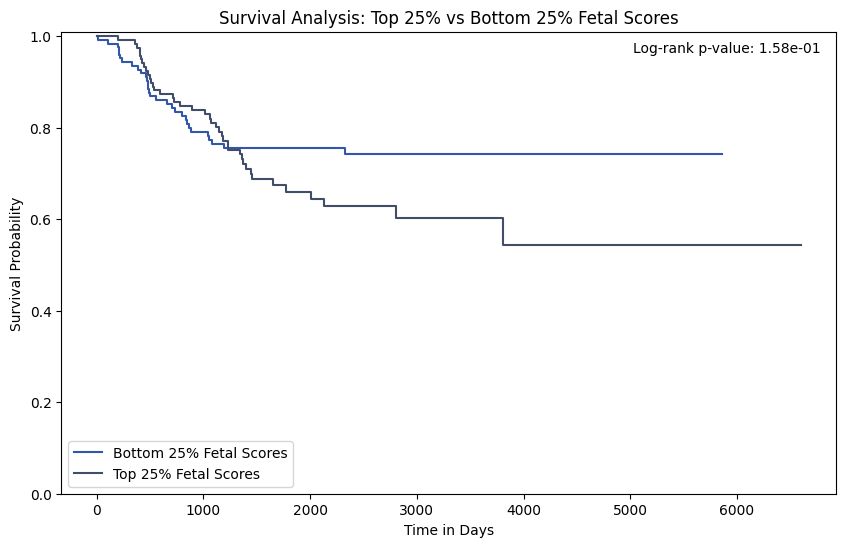

In [233]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['effector_scores'] >= data['effector_scores'].quantile(0.75)]
bottom_25 = data[data['effector_scores'] <= data['effector_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

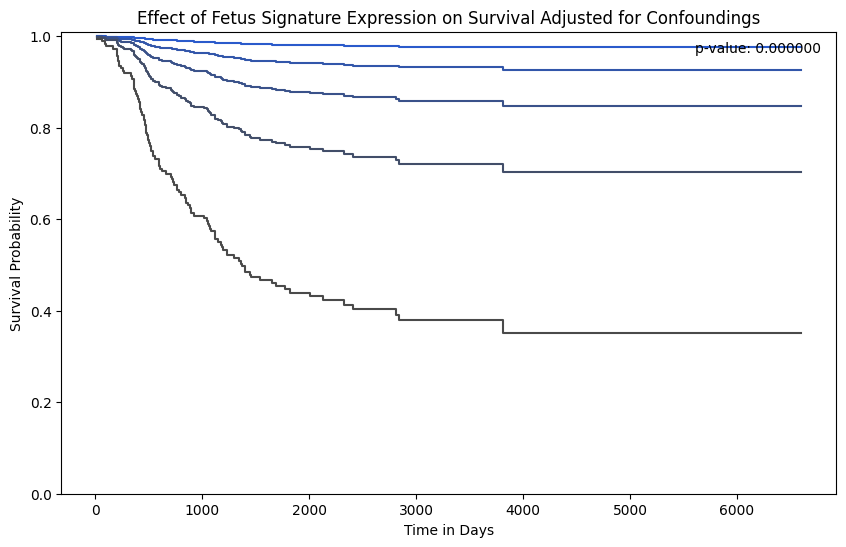

In [234]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'effector_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="effector_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['effector_scores'].quantile(0.05), 
    cox_data['effector_scores'].quantile(0.25), 
    cox_data['effector_scores'].median(), 
    cox_data['effector_scores'].quantile(0.75), 
    cox_data['effector_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='effector_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['effector_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

## Fetus Group 1 vs Group 2

In [241]:
# Read the gene list from the file
with open("dataset/top_100_genes_purecd8_group1.csv", 'r') as file:
    fetus_group1_gene_list = file.read().splitlines()
    
fetus_group1_gene_list

['genes',
 'LEF1',
 'RPS8',
 'CD52',
 'LTB',
 'RGS10',
 'LDHB',
 'RPL32',
 'RPS12',
 'RPS6',
 'TCF7',
 'CD8B',
 'IL7R',
 'RPS3A',
 'RPS13',
 'RPL12',
 'RPL18A',
 'RPL11',
 'THEMIS',
 'CAMK4',
 'RPS23',
 'RPS24',
 'RPS18',
 'RPL29',
 'NOSIP',
 'RPL39',
 'RPS4X',
 'RPL22',
 'RPL34',
 'LINC02446',
 'SELL',
 'RPL26',
 'RPL4',
 'RPS25',
 'EEF1B2',
 'RPS16',
 'TPT1',
 'SNHG29',
 'RPL36A',
 'RPL13',
 'NACA',
 'NELL2',
 'RPS5',
 'EEF1A1',
 'RPL19',
 'RACK1',
 'VIM',
 'RPL9',
 'RPL28',
 'RPL10A',
 'RPL35A',
 'RPL37',
 'LRRN3',
 'CCR7',
 'PASK',
 'RPL37A',
 'RPL36',
 'RPL7A',
 'NPM1',
 'RPS10',
 'RPL5',
 'RPS9',
 'ACTN1',
 'RPLP0',
 'TMSB10',
 'SERINC5',
 'RPS21',
 'EEF2',
 'CHI3L2',
 'RPL18',
 'RPL8',
 'RPL30',
 'RPS7',
 'AQP3',
 'RPS28',
 'SMC4',
 'TMEM123',
 'RPS3',
 'RPS19',
 'SNHG8',
 'RPL3',
 'AIF1',
 'PPA1',
 'BACH2',
 'CD27',
 'RPL10',
 'OXNAD1',
 'MAL',
 'FYB1',
 'RPS27A',
 'RPL24',
 'RPLP1',
 'SERPINF1',
 'RCAN3',
 'BTF3',
 'SLC25A5',
 'YBX1',
 'BCL11B',
 'RPL14',
 'C12orf57',
 'ABLIM1

In [244]:
# List of Fetal signature genes
fetus_group1_genes = fetus_group1_gene_list

# Calculate fetal signature scores for each sample
fetus_group1_scores = gene_data[gene_data['Gene'].isin(fetus_group1_genes)].iloc[:, 8:].mean(axis=0)
fetus_group1_scores.name = 'fetus_group1_scores'

# Combine fetal scores with metadata
data['fetus_group1_scores'] = data['Sample ID'].map(fetus_group1_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetus_group1_scores'], inplace=True)

In [245]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  adult_100genes_scores  cd4_fetal_scores  \
0            24.7943  ...              20.411157         22.203144   
1            25.2958  ...              19.591739         21.765908   
2            24.5375  ...              19.338214         23.036496   
3            24.6351  ...              19.705299         22.254420   
4            24.9948  ...              19.605241         22.851544   
..               ...  ...                    ...               ...   
493          25.4461  ...              19.919627         22.228668   
494          25.1602  ...              19.681593         22.004884   
495          25.1211  ...              19.682023         22.256172   
496          24.7802  ...              19.910361         22.010492   
497          25.0471  ...              20.195657         22.125912   

     cd4_adult_scores  filtered_fetal_scores  fetus_naive_scores  \
0           20.665953              21.003937           19.609213   
1           20.125725              20.987905           18.841301   
2           19.208900              20.081663           18.568043   
3           19.731466              20.922758           18.943259   
4           19.281569              20.855305           18.740390   
..                ...                    ...                 ...   
493         20.474144              21.309384           19.035700   
494         20.497603              21.205879           19.150574   
495         20.275197              21.172195           18.788093   
496         20.018150              21.310279           18.976422   
497         20.328600              21.548300           19.544836   

     fetus_eff_scores  fetus_effector_scores  naive_scores  effector_scores  \
0           17.431620              17.263207     18.728608        18.022976   
1           16.380105              16.319230     18.402331        17.544824   
2           15.130395              14.971819     17.990923        17.115525   
3           16.286468              16.543141     18.320017        17.580697   
4           15.448838              15.922860     18.248280        17.602904   
..                ...                    ...           ...              ...   
493         17.090534              16.909849     18.456677        17.524126   
494         17.192776              17.225292     18.507449        17.5

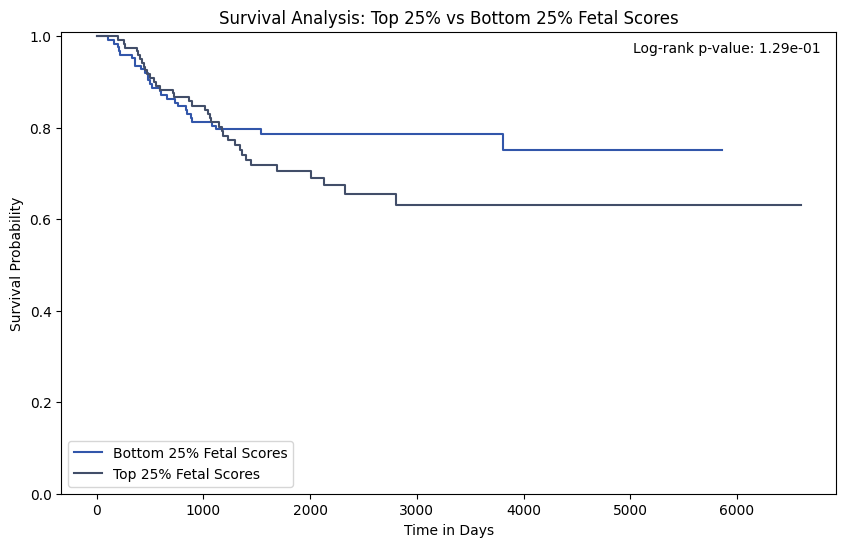

In [246]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetus_group1_scores'] >= data['fetus_group1_scores'].quantile(0.75)]
bottom_25 = data[data['fetus_group1_scores'] <= data['fetus_group1_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

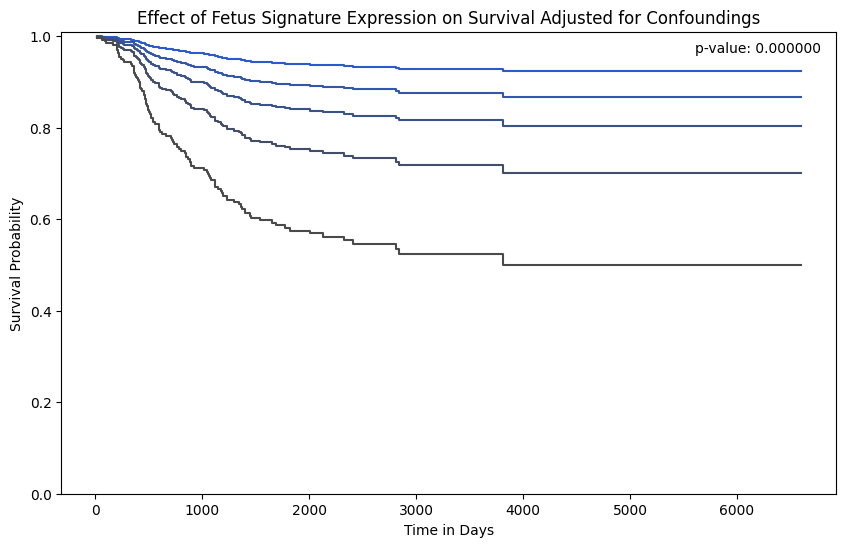

In [247]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_group1_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_group1_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_group1_scores'].quantile(0.05), 
    cox_data['fetus_group1_scores'].quantile(0.25), 
    cox_data['fetus_group1_scores'].median(), 
    cox_data['fetus_group1_scores'].quantile(0.75), 
    cox_data['fetus_group1_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_group1_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_group1_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

In [248]:
# Read the gene list from the file
with open("dataset/top_100_genes_purecd8_group2.csv", 'r') as file:
    fetus_group2_gene_list = file.read().splitlines()
    
fetus_group2_gene_list

['genes',
 'CST7',
 'NKG7',
 'CMC1',
 'TYROBP',
 'CCL4',
 'KLRC1',
 'KLRD1',
 'XCL2',
 'GZMA',
 'PRF1',
 'HOPX',
 'XCL1',
 'PLEK',
 'KLRB1',
 'ZBTB16',
 'GZMB',
 'LINGO2',
 'CCL3',
 'TRDC',
 'ALOX5AP',
 'CD160',
 'IL2RB',
 'SH2D1B',
 'TGFBR3',
 'MCTP2',
 'APMAP',
 'KLRF1',
 'GSTP1',
 'GNLY',
 'IFNG',
 'GZMH',
 'SRGN',
 'MYO1F',
 'RHOC',
 'IL18RAP',
 'CTSW',
 'PLCG2',
 'S1PR5',
 'MAP3K8',
 'FGR',
 'ZEB2',
 'LAT2',
 'C1orf21',
 'CLIC3',
 'NCR1',
 'TTC38',
 'CCL5',
 'PLCB1',
 'SH2D2A',
 'GZMM',
 'TIGIT',
 'PYHIN1',
 'FCGR3A',
 'PDGFD',
 'NFKBIA',
 'FASLG',
 'CD63',
 'GZMK',
 'AOAH',
 'FYN',
 'CD99',
 'IRF8',
 'IFITM2',
 'CYBA',
 'STOM',
 'PIK3R1',
 'CTBP2',
 'CLIC1',
 'CCL4L2',
 'CD300A',
 'HCST',
 'B2M',
 'LDB2',
 'SLA2',
 'LYN',
 'ACTN4',
 'SLAMF7',
 'PVRIG',
 'SLC4A10',
 'HDAC9',
 'EOMES',
 'NFATC2',
 'LINC01871',
 'CHST12',
 'SAMD3',
 'PIK3AP1',
 'NCAM1',
 'MEF2C',
 'MATK',
 'PPP1R15A',
 'APOBEC3G',
 'IL23R',
 'CXCR6',
 'ICAM1',
 'ENSG00000232855',
 'PTGDR',
 'IFNGR1',
 'LITAF',
 'CD2

In [249]:
# List of Fetal signature genes
fetus_group2_genes = fetus_group2_gene_list

# Calculate fetal signature scores for each sample
fetus_group2_scores = gene_data[gene_data['Gene'].isin(fetus_group2_genes)].iloc[:, 8:].mean(axis=0)
fetus_group2_scores.name = 'fetus_group2_scores'

# Combine fetal scores with metadata
data['fetus_group2_scores'] = data['Sample ID'].map(fetus_group2_scores)

# Drop samples with missing fetal scores
data.dropna(subset=['fetus_group2_scores'], inplace=True)

In [250]:
data

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0    SEQC_NB001     1362       1   18.269337        17.244859   
1    SEQC_NB002     2836       1   17.887488        16.696371   
2    SEQC_NB003     1191       1   17.871847        16.120460   
3    SEQC_NB004     2046       0   18.281798        17.053701   
4    SEQC_NB005      220       1   18.154788        16.878057   
..          ...      ...     ...         ...              ...   
493  SEQC_NB494     4828       0   18.539878        17.287050   
494  SEQC_NB495     2467       0   18.275851        17.266318   
495  SEQC_NB496     5780       0   18.463341        16.899743   
496  SEQC_NB497     4883       0   18.396722        17.171593   
497  SEQC_NB498     2772       0   18.757722        17.657234   

     il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0              16.482722           15.634172   18.813415   18.199822   
1              15.697078           15.270535   17.277249   17.047478   
2              14.869950           14.382875   16.387085   16.125509   
3              15.792001           15.186789   17.403907   17.065319   
4              15.197942           15.045142   17.422367   16.811052   
..                   ...                 ...         ...         ...   
493            16.319573           15.885961   17.375715   17.216905   
494            16.615709           16.006870   18.457729   17.929036   
495            15.547129           15.152285   16.764017   16.629451   
496            16.502210           15.930697   17.496033   17.429593   
497            16.894050           16.501148   18.137882   18.072381   

     ACTB_expression  ...  cd4_fetal_scores  cd4_adult_scores  \
0            24.7943  ...         22.203144         20.665953   
1            25.2958  ...         21.765908         20.125725   
2            24.5375  ...         23.036496         19.208900   
3            24.6351  ...         22.254420         19.731466   
4            24.9948  ...         22.851544         19.281569   
..               ...  ...               ...               ...   
493          25.4461  ...         22.228668         20.474144   
494          25.1602  ...         22.004884         20.497603   
495          25.1211  ...         22.256172         20.275197   
496          24.7802  ...         22.010492         20.018150   
497          25.0471  ...         22.125912         20.328600   

     filtered_fetal_scores  fetus_naive_scores  fetus_eff_scores  \
0                21.003937           19.609213         17.431620   
1                20.987905           18.841301         16.380105   
2                20.081663           18.568043         15.130395   
3                20.922758           18.943259         16.286468   
4                20.855305           18.740390         15.448838   
..                     ...                 ...               ...   
493              21.309384           19.035700         17.090534   
494              21.205879           19.150574         17.192776   
495              21.172195           18.788093         16.015423   
496              21.310279           18.976422         17.091249   
497              21.548300           19.544836         17.802254   

     fetus_effector_scores  naive_scores  effector_scores  \
0                17.263207     18.728608        18.022976   
1                16.319230     18.402331        17.544824   
2                14.971819     17.990923        17.115525   
3                16.543141     18.320017        17.580697   
4                15.922860     18.248280        17.602904   
..                     ...           ...              ...   
493              16.909849     18.456677        17.524126   
494              17.225292     18.507449        17.584140   
495              15.754552     18.267165        17.584577   
496              17.289315     18.399660        17.610437   
497              17.555637     18.634975        17.597621   

     fetus_group1_scores  fet

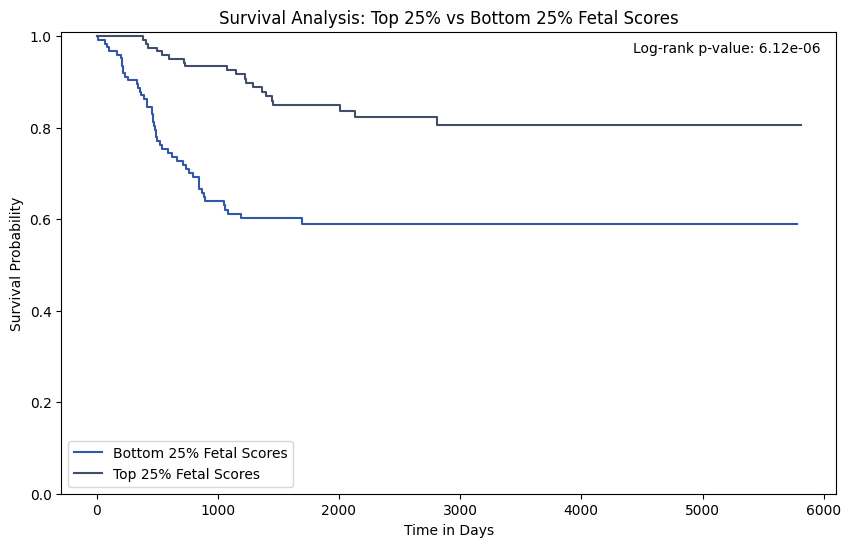

In [251]:
# Stratify samples into top 25% and bottom 25% based on fetal scores
top_25 = data[data['fetus_group2_scores'] >= data['fetus_group2_scores'].quantile(0.75)]
bottom_25 = data[data['fetus_group2_scores'] <= data['fetus_group2_scores'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Bottom 25% TCR scores
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Fetal Scores')
ax = kmf.plot_survival_function(ci_show=False, color='#3256aa')  # Plot in blue

# Top 25% TCR scores
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Fetal Scores')
kmf.plot_survival_function(ax=ax, ci_show=False, color='#424e69')  # Plot in grey

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.ylim(0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Survival Analysis: Top 25% vs Bottom 25% Fetal Scores')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Remove legend and add p-value text
# ax.legend().remove()
ax.text(0.98, 0.98, f'Log-rank p-value: {p_value:.2e}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Save the plot as SVG without flattening
plt.savefig('plots/fetal_filtered_km.svg', format='svg', bbox_inches='tight')

plt.show()

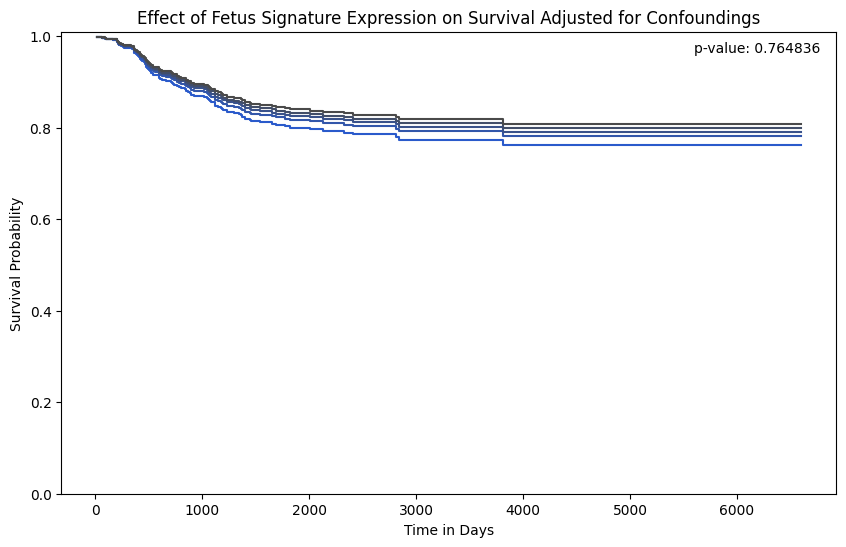

In [252]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_group2_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_group2_scores + CD3E_expression + CD4_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_group2_scores'].quantile(0.05), 
    cox_data['fetus_group2_scores'].quantile(0.25), 
    cox_data['fetus_group2_scores'].median(), 
    cox_data['fetus_group2_scores'].quantile(0.75), 
    cox_data['fetus_group2_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_group2_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_group2_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

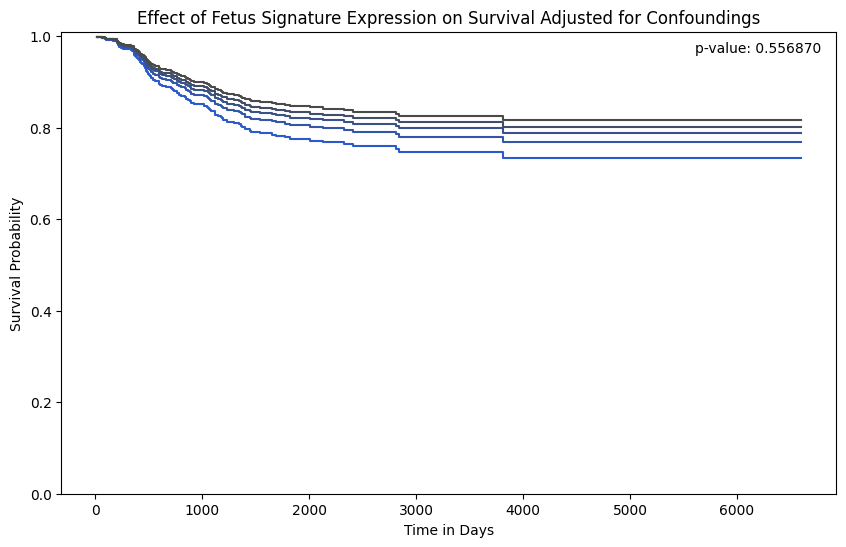

In [265]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_group2_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_group2_scores + CD3E_expression + CD4_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_group2_scores'].quantile(0.05), 
    cox_data['fetus_group2_scores'].quantile(0.25), 
    cox_data['fetus_group2_scores'].median(), 
    cox_data['fetus_group2_scores'].quantile(0.75), 
    cox_data['fetus_group2_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_group2_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_group2_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

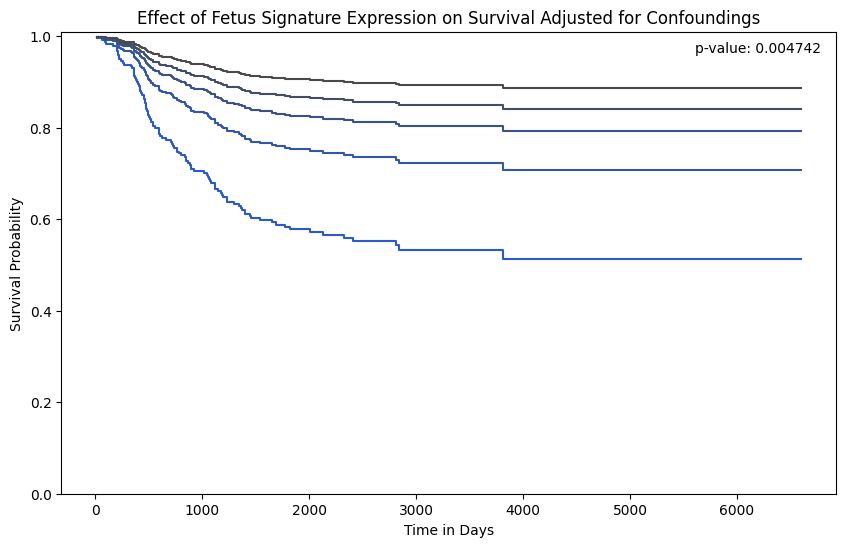

In [266]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_group2_scores', 'CD3E_expression', 'CD4_expression', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_group2_scores + CD3E_expression + CD8B_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_group2_scores'].quantile(0.05), 
    cox_data['fetus_group2_scores'].quantile(0.25), 
    cox_data['fetus_group2_scores'].median(), 
    cox_data['fetus_group2_scores'].quantile(0.75), 
    cox_data['fetus_group2_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_group2_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_group2_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

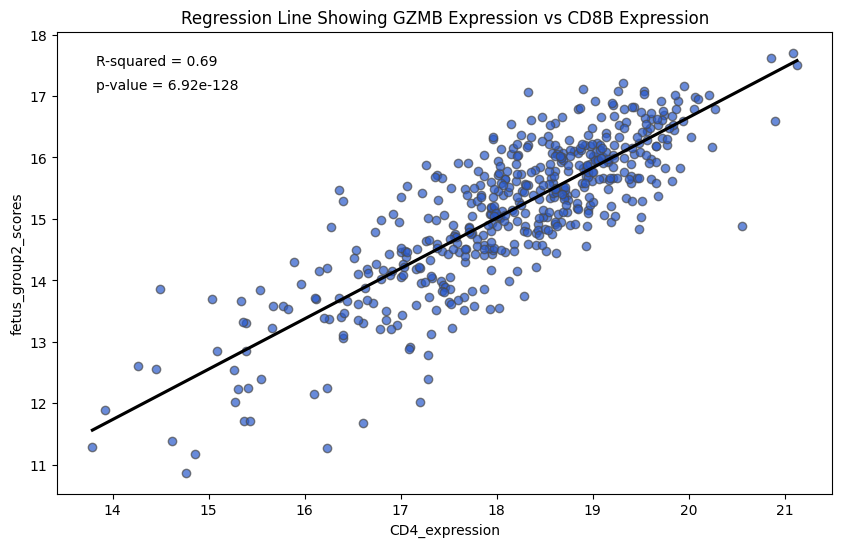

In [267]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD4_expression'])
Y = data['fetus_group2_scores']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD4_expression', y='fetus_group2_scores', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing GZMB Expression vs CD8B Expression')
plt.xlabel('CD4_expression')
plt.ylabel('fetus_group2_scores')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD4_expression']

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')

plt.show()

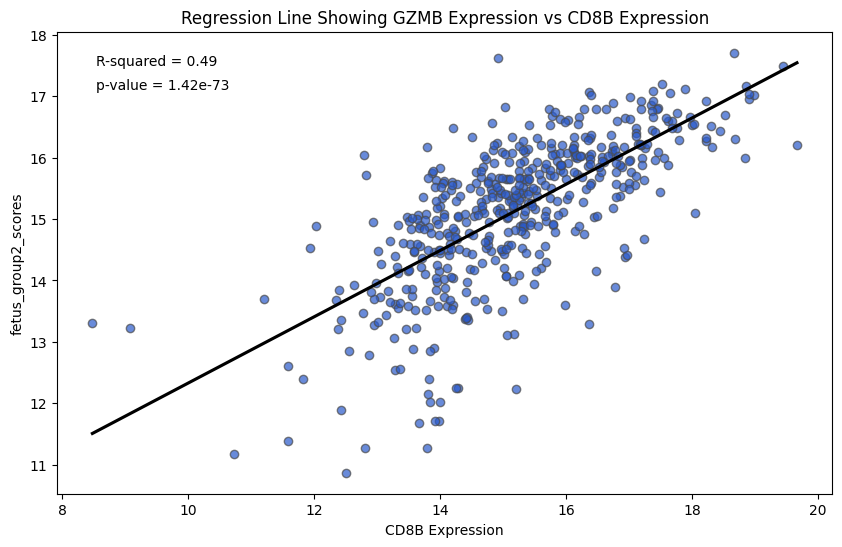

In [268]:
# Add a constant to the independent variable for regression analysis
X = sm.add_constant(data['CD8B_expression'])
Y = data['fetus_group2_scores']

# Fit the regression model using OLS
model = sm.OLS(Y, X).fit()

# Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='CD8B_expression', y='fetus_group2_scores', data=data, ci=None,
            scatter_kws={'alpha': 0.7, 'color': '#2A5ACB', 'edgecolor': '#4A4A4A'}, 
            line_kws={'color': 'black'})

plt.title('Regression Line Showing GZMB Expression vs CD8B Expression')
plt.xlabel('CD8B Expression')
plt.ylabel('fetus_group2_scores')
plt.grid(False)  # Disable the grid

# Extract the R-squared and p-value from the model
r_squared = model.rsquared
p_value = model.pvalues['CD8B_expression']

# Annotate the plot with the R-squared and p-value
plt.text(0.05, 0.95, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'p-value = {p_value:.2e}', transform=ax.transAxes, verticalalignment='top')


plt.show()

In [269]:
# Extract ACTB expression levels
cd8a_expression = gene_data.loc[gene_data['Gene'] == 'CD8A', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd8a_expression = cd8a_expression.reset_index()
cd8a_expression.columns = ['Sample ID', 'CD8A_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, cd8a_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['CD8A_expression'], inplace=True)

# Verify the data structure
data.head()

Sample ID  os days  os bin  tgfb_score  il2_stat5_score  \
0  SEQC_NB001     1362       1   18.269337        17.244859   
1  SEQC_NB002     2836       1   17.887488        16.696371   
2  SEQC_NB003     1191       1   17.871847        16.120460   
3  SEQC_NB004     2046       0   18.281798        17.053701   
4  SEQC_NB005      220       1   18.154788        16.878057   

   il6_jak_stat3_score  inflammatory_score  ifna_score  ifng_score  \
0            16.482722           15.634172   18.813415   18.199822   
1            15.697078           15.270535   17.277249   17.047478   
2            14.869950           14.382875   16.387085   16.125509   
3            15.792001           15.186789   17.403907   17.065319   
4            15.197942           15.045142   17.422367   16.811052   

   ACTB_expression  ...  cd4_adult_scores  filtered_fetal_scores  \
0          24.7943  ...         20.665953              21.003937   
1          25.2958  ...         20.125725              20.987905   
2          24.5375  ...         19.208900              20.081663   
3          24.6351  ...         19.731466              20.922758   
4          24.9948  ...         19.281569              20.855305   

   fetus_naive_scores  fetus_eff_scores  fetus_effector_scores  naive_scores  \
0           19.609213         17.431620              17.263207     18.728608   
1           18.841301         16.380105              16.319230     18.402331   
2           18.568043         15.130395              14.971819     17.990923   
3           18.943259         16.286468              16.543141     18.320017   
4           18.740390         15.448838              15.922860     18.248280   

   effector_scores  fetus_group1_scores  fetus_group2_scores  CD8A_expression  
0        18.022976            20.323239            16.057873          17.3985  
1        17.544824            19.492479            14.908927          16.9594  
2        17.115525            19.703195            12.906952          16.7592  
3        17.580697            19.630389            15.092227          16.9908  
4        17.602904            19.707883            13.980920          16.7186  

[5 rows x 50 columns]

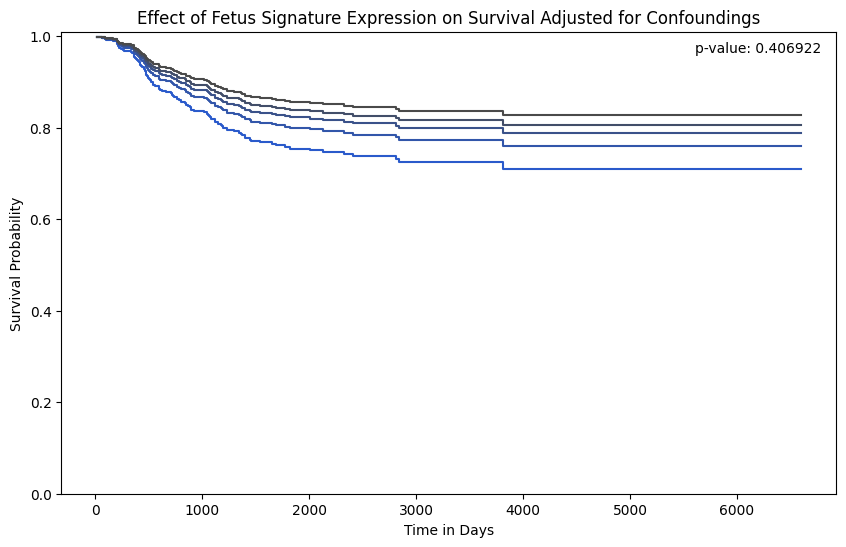

In [271]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_group2_scores', 'CD3E_expression', 'CD4_expression', 'CD8A_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_group2_scores + CD3E_expression + CD4_expression + CD8A_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_group2_scores'].quantile(0.05), 
    cox_data['fetus_group2_scores'].quantile(0.25), 
    cox_data['fetus_group2_scores'].median(), 
    cox_data['fetus_group2_scores'].quantile(0.75), 
    cox_data['fetus_group2_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_group2_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_group2_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()

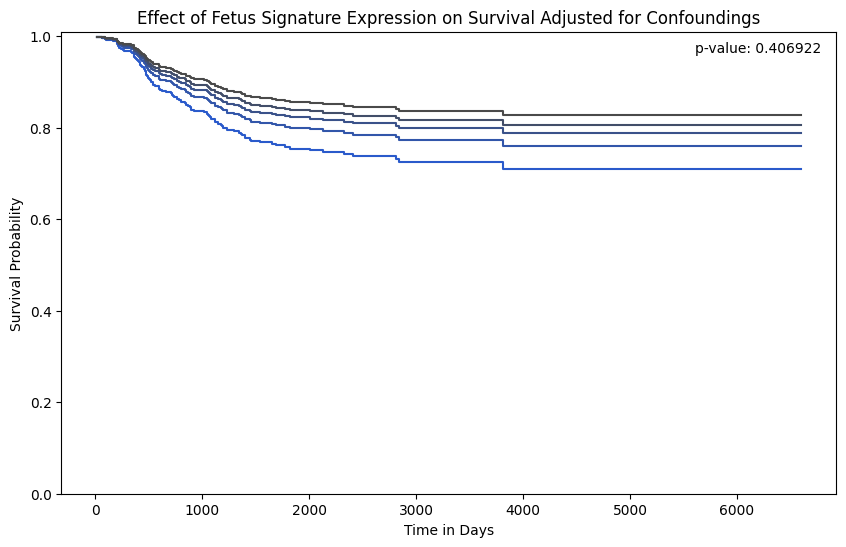

In [278]:
# Controlling for some Confounders
cox_data = data[['os days', 'os bin', 'fetus_group2_scores', 'CD3E_expression', 'CD4_expression', 'CD8A_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model, including CD3E, CD4, and CD8B expressions as covariates
cph.fit(cox_data, duration_col='os days', event_col='os bin', formula="fetus_group2_scores + CD3E_expression + CD4_expression + CD8A_expression")

# Display the results
# cph.print_summary()

# Define the values for FOXP3_expression
values = [
    cox_data['fetus_group2_scores'].quantile(0.05), 
    cox_data['fetus_group2_scores'].quantile(0.25), 
    cox_data['fetus_group2_scores'].median(), 
    cox_data['fetus_group2_scores'].quantile(0.75), 
    cox_data['fetus_group2_scores'].quantile(0.95)
]

# Plotting the effect of FOXP3 expression on survival with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#2A5ACB", "#4A4A4A"]  # Start with a dark grey, end with a deep blue
cmap = LinearSegmentedColormap.from_list("grey_to_blue", colors, N=100)

# Plot partial effects with custom colors
cph.plot_partial_effects_on_outcome(
    covariates='fetus_group2_scores', 
    values=values, 
    plot_baseline=False, 
    ax=ax, 
    cmap=cmap  # Apply custom colors to the plot
)


plt.ylim(0.0, 1.01)  # Set y-axis range from 0.5 to 1

plt.title('Effect of Fetus Signature Expression on Survival Adjusted for Confoundings')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')

# Retrieve the p-value for the FOXP3 expression from the Cox model summary
p_value = cph.summary.loc['fetus_group2_scores', 'p']

# Annotate the plot with the p-value
ax.text(0.98, 0.98, f'p-value: {p_value:.6f}', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', color='black')

# Remove the legend
ax.legend().remove()

# Save the plot as SVG for high-quality output
plt.savefig('plots/fetus_conf_cph.svg', format='svg', bbox_inches='tight')

plt.show()